# ML4B trigger analysis from structured data

In [1]:
# Data Libraries
import pandas as pd
import numpy as np
import scipy

pd.set_option('display.max_rows',None)

# Visualization Libraries
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline
plt.rcParams["figure.figsize"] = 15,15
plt.rcParams["figure.dpi"] = 300
plt.rcParams['figure.max_open_warning'] = False

# Machine Learning Libraries
from sklearn import preprocessing
from sklearn import utils
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score


# Other libraries
import pyodbc
import umap
from collections import defaultdict
from scipy.stats import mannwhitneyu, ttest_rel, ttest_ind

# Autoreload set up
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

pd.options.display.max_colwidth = 1500


In [2]:
# extracts all datasets from database with selected prefix
def extractDataset(prefix, excludeSet):
    conn = pyodbc.connect("DRIVER={SQL Server Native Client 11.0};SERVER=VHACDWRB03.vha.med.va.gov;DATABASE=ORD_Singh_201911038D;Trusted_Connection=yes")

    info_df = pd.read_sql(sql="select * from information_schema.tables where table_name like '%{}%'".format(prefix), con=conn)
    display(info_df)
    # read all the tables into pandas tables
    tables = {}
    for tname in info_df.TABLE_NAME:
        if tname.split('_')[-1] in excludeSet:
            continue
        query_str = "select * from  " + str("Dflt.")+ str(tname)
        table_df = pd.read_sql(sql=query_str,con=conn)
        tables[tname.split('_')[-1]] = table_df
    print(tables.keys())
    return tables

In [3]:
dataset = extractDataset("B00_ML4TrgPos_", {"WithRole", "AllMed",  "HF","NonVAMed", "DispensedDrug","Note","Only10daysPrior30DaysAfter"})

TABLE_CATALOG TABLE_SCHEMA  \
0   ORD_Singh_201911038D         Dflt   
1   ORD_Singh_201911038D         Dflt   
2   ORD_Singh_201911038D         Dflt   
3   ORD_Singh_201911038D         Dflt   
4   ORD_Singh_201911038D         Dflt   
5   ORD_Singh_201911038D         Dflt   
6   ORD_Singh_201911038D         Dflt   
7   ORD_Singh_201911038D         Dflt   
8   ORD_Singh_201911038D         Dflt   
9   ORD_Singh_201911038D         Dflt   
10  ORD_Singh_201911038D         Dflt   
11  ORD_Singh_201911038D         Dflt   
12  ORD_Singh_201911038D         Dflt   
13  ORD_Singh_201911038D         Dflt   
14  ORD_Singh_201911038D         Dflt   
15  ORD_Singh_201911038D         Dflt   

                                                     TABLE_NAME  TABLE_TYPE  
0                           _B00_ML4TrgPos_Y201621_01_04_cohort  BASE TABLE  
1                              _B00_ML4TrgPos_Y201621_05_04_Rad  BASE TABLE  
2                       _B00_ML4TrgPos_Y201621_30_Note_WithRole  BASE TABLE  
3                                _B00_ML4TrgPos_Y201621_30_Note  BASE TABLE  
4                              _B00_ML4TrgPos_Y201621_04_04_Lab  BASE TABLE  
5                     _B00_ML4TrgPos_Y201621_06_Med_04_RxOutpat  BASE TABLE  
6                     _B00_ML4TrgPos_Y201621_06_Med_07_NonVAMed  BASE TABLE  
7           _B00_ML4TrgPos_Y201621_06_Med_05_BCMA_DispensedDrug  BASE TABLE  
8                       _B00_ML4TrgPos_Y201621_06_Med_08_AllMed  BASE TABLE  
9                             _B00_ML4TrgPos_Y201621_08_Consult  BASE TABLE  
10                                _B00_ML4TrgPos_Y201621_12_ICD  BASE TABLE  
11                              _B00_ML4TrgPos_Y201621_14_Vital  BASE TABLE  
12                                 _B00_ML4TrgPos_Y201621_16_HF  BASE TABLE  
13                         _B00_ML4TrgPos_Y201621_05_04_Rad_new  BASE TABLE  
14                   _B00_ML4TrgPos_Y201621_01_04_Demorgraphics  BASE TABLE  
15  _B00_ML4TrgPos_Y201621_05_04_Rad_Only10daysPrior30DaysAfter  BASE TABLE

dict_keys(['cohort', 'Rad', 'Lab', 'RxOutpat', 'Consult', 'ICD', 'Vital', 'new', 'Demorgraphics'])


# Support functions
- umap plot
- cluster umap
- get labeled data on abpain trigger

In [4]:
# see if there are any clusters based on any of the considered variables

import umap
from sklearn.cluster import KMeans

# label list should be in order 0,1 

def umap_plot_label(X,y,rseed,nbrs,label_list):
    nclasses = len(label_list)
    # standard scale X
    scaler = StandardScaler()
    sX = scaler.fit_transform(X.astype(float))
    
    reducer = umap.UMAP(metric='correlation',min_dist=0.0,n_neighbors=nbrs,random_state=rseed)
    u = reducer.fit_transform(X)
    cc = plt.cm.rainbow(np.linspace(0,1,nclasses))
    colors = {0:cc[0],1:cc[1]}
    plt.subplots(figsize=(8,8))
    for i in range(nclasses):
        plt.scatter(u[y==i,0],u[y==i,1],alpha=0.5,s=40,label=label_list[i],color=colors[i])

    plt.legend()
    return u

def umap_plot_nolabel(X,rseed,nbrs):
    # standard scale X
    scaler = StandardScaler()
    sX = scaler.fit_transform(X.astype(float))
    
    reducer = umap.UMAP(metric='correlation',min_dist=0.0,n_neighbors=nbrs,random_state=rseed)
    u = reducer.fit_transform(X)
    plt.subplots(figsize=(8,8))
    plt.scatter(u[:,0],u[:,1],alpha=0.5,s=40)
    return u


In [135]:
# cluster the embedding and find the cluster composition

def cluster_umap(u,N,df):
    clust = KMeans(n_clusters = N)
    clust.fit(u)

    plt.subplots(figsize=(10,10))
    for i in range(N):
        plt.scatter(u[clust.labels_==i,0],u[clust.labels_==i,1])
    plt.legend([i+1 for i in range(N)])
    
    for i in range(N):
        print('Cluster ',i+1)
        print(df.iloc[np.where(clust.labels_==i)[0],:].label.value_counts())
    return clust

# produce median statistics of cluster 
def analyze_clusters(clust,df,feats):
    N = max(clust.labels_)
    for i in range(N):
        print('median statistics of cluster ', i)
        print(df.iloc[np.where(clust.labels_==i)[0],:].label.value_counts())
        display(df[clust.labels_==i].describe()[feats].T['50%'])

In [6]:
fname = "../ML Final data/ML_4B_Abdominal Pain/csv format/Ashish_HighRiskAbdominalPain(n=120)_09222022_VV_v1.csv"

In [7]:
def retrieveLabels_abpain(fname):
    """"
    retrieves labels for the ML4 AbdominalPain trigger
    
    Returns
    --------
    dataframe
         of reviewed entries
    dict
         label dictionary mapping ssn to label
         
    """
    abpain_df = pd.read_csv(open(fname, 'r', errors="ignore"))
    print(abpain_df.shape)
    abpain_df.dropna(subset=["DxError", "PtSSN"], inplace=True)
    print(abpain_df.shape)
    abpain_df["PtSSN"] = abpain_df["PtSSN"].astype(int)
    label_map = dict()
    
    for index, row in abpain_df.iterrows():
        if row["PtSSN"] in label_map:
            print("duplicate label???")
        if row["DxError"] in [1,2,3]:
            label_map[row["PtSSN"]] = "NoMOD"
        if row["DxError"] in [5,6]:
            label_map[row["PtSSN"]] = "MOD"
            
    labels_df = pd.DataFrame.from_dict(label_map,orient='index').reset_index()
    labels_df.columns=['PtSSN','label']
    
    return abpain_df, labels_df

# Modeling support functions
- build an LR model
- evaluate an LR model
- visualize the model coefficients


In [8]:
# build an LR model on these predictors

# L1 model with all features

#X = coded_abpain_df_labels[coded_abpain_df_labels.columns[1:-1]]
#y = np.array([1 if x=='MOD' else 0 for x in coded_abpain_df_labels['label']])
# best value for C by cross-validation 

from sklearn.model_selection import GridSearchCV

def tune_model(X,y):
    alphas = np.logspace(-4,2,30)
    tuned_parameters = [{'C':alphas}]
    nfolds = 5

    lr = LogisticRegression(max_iter=10000,penalty='l1',solver='saga')
    

    clf = GridSearchCV(lr,tuned_parameters,cv=nfolds,refit=False,scoring='f1_macro')
    clf.fit(X,y)
    scores = clf.cv_results_['mean_test_score']
    scores_std = clf.cv_results_['std_test_score']

    # plot everything
    plt.semilogx(alphas,scores)
    std_error = scores_std/np.sqrt(nfolds)

    plt.semilogx(alphas,scores+std_error,'b--')
    plt.semilogx(alphas,scores-std_error,'b--')
    plt.fill_between(alphas,scores + std_error,scores-std_error,alpha=0.2)
    plt.ylabel('CV score +/- std error')
    plt.xlabel('alpha')
    plt.axhline(np.max(scores),linestyle='--',color='r')
    plt.xlim([alphas[0],alphas[-1]])
    return clf



def build_L1_model(X,y,C):
    print(X.shape,y.shape)
    clf = LogisticRegression(C=C,max_iter=10000,penalty='l1',solver='saga')
    scores = cross_val_score(clf,X,y,cv=5,scoring='roc_auc')
    print('AUC = ',scores.mean(), scores.std())
    scores = cross_val_score(clf,X,y,cv=5,scoring='f1_macro')
    print('F1 = ',scores.mean(), scores.std())
    scores = cross_val_score(clf,X,y,cv=5,scoring='accuracy')
    print('Accuracy = ', scores.mean(), scores.std())

    clf = LogisticRegression(C=C,max_iter=10000,penalty='l1',solver='saga')
    clf.fit(X,y)
    print('Confusion matrix:')
    ypred = clf.predict(X)
    print(metrics.confusion_matrix(y,ypred))
    select_feats = list(X.columns[np.where(clf.coef_ != 0)[1]])
    print(len(select_feats), ' features chosen by L1 model.')
    return clf, select_feats

def visualize_model(clf,select_feats):
    coef_df = pd.concat([pd.DataFrame(select_feats),pd.DataFrame(clf.coef_[clf.coef_ !=0])],axis=1)
    coef_df.columns=['Name','Coef_value']
    coef_df = coef_df.sort_values(by='Coef_value')
    sns.barplot(data=coef_df,y='Name',x='Coef_value')

In [149]:
# do a ttest between MOD/NoMOD on a specified set of fields

def ttest_fields(df,fields):
    for field in fields:
        print(field,scipy.stats.ttest_ind(df[df.label=='MOD'][field],df[df.label=='NoMOD'][field] ))
        
def ttest_lab(lab_df_labeled,labname):
    tstat, pval = scipy.stats.ttest_ind(lab_df_labeled[lab_df_labeled.label=='MOD']['value'].dropna(),
                      lab_df_labeled[lab_df_labeled.label=='NoMOD']['value'].dropna())
    return labname, pval

# Code for extracting lab values

In [286]:
def matches_WBC(s):
    return s=='WBC'

def matches_albumin(s):
    return s.lower().find('albumin')>=0
def matches_glucose(s):
    return s.lower().find('glucose')>=0

def matches_sodium(s):
    return s.lower().find('sodium')>=0

def matches_calcium(s):
    return s.lower().find('calcium')>=0

def matches_potassium(s):
    return s.lower().find('potassium')>=0

def matches_chloride(s):
    return s.lower().find('chloride')>=0

def matches_lact(s):
    return s.lower().find('lact')>=0

def matches_bun(s):
    return s.lower().find('bun')>=0


def matches_creat(s):
    return s.lower().find('creatinine')>=0


def matches_CO2(s):
    return s.lower().find('co2 ')>=0

def matches_troponin(s):
    return (s.find('TROPONIN I')>=0) or (s.find('TROPONIN-I')>=0)


def matches_ast(s):
    return (s=='AST') or (s.find('AST \(S')>=0)

def matches_alt(s):
    return (s=='ALT') or (s.find('ALT \(S')>=0)

def matches_alkphos(s):
    return s.find('ALKALINE') >= 0

def matches_lipase(s):
    return s.find('LIPASE')>=0

def matches_amylase(s):
    return s.find('AMYLASE')>=0

def matches_urine(s):
    return s.find('URINE') >=0

In [16]:
def lab_values(matchfn,abpain_cohort,abpain_labs):
    lab_vals = {}
    cnt = 0
    for PtSSN in abpain_cohort.PtSSN.unique():
  
        recs = abpain_labs[abpain_labs.PtSSN==PtSSN].sort_values(by='LabChemSpecimenDateTime')
        lab_recs = recs[recs.LabChemTestName.apply(matchfn)]
    
        if lab_recs.shape[0] > 0:
        # get value for each admission
            lab_recs_grp = lab_recs.groupby('EDStartDateTime')
        
            for k in lab_recs_grp.groups.keys():
                
                g = lab_recs_grp.get_group(k)
                lab_val = max(g.LabChemResultNumericValue.values)
                if 'H' in g.Abnormal.values:
                    lab_abnormal = 'H'
                else:
                    lab_abnormal = None
                lab_vals[cnt] = {'PtSSN':PtSSN,'EDStartDateTime':k,'value': lab_val, 'abnormal':lab_abnormal}
                cnt = cnt + 1
        else:
            edstart = abpain_cohort[abpain_cohort.PtSSN==PtSSN].sort_values(by='EDStartDateTime').iloc[0].EDStartDateTime
            lab_vals[cnt] = {'PtSSN':PtSSN,'EDStartDateTime':edstart,'value': None, 'abnormal':None}
            cnt = cnt + 1

    return pd.DataFrame.from_dict(lab_vals,orient='index')


# Function for checking SIRS criterion
- 2 out of the following four
    - temp > 100.4 ir temp < 96.8
    - heart rate > 90
    - resp rate > 20
    - WBC > 12000 or WBC < 4000
- check lactate levels (> 18 mg/DL or 2 mmol/L) if available

In [235]:
def meets_sirs(row):
    count = 0
    if row.TEMPERATURE > 100.4: count = count + 1
    if row.TEMPERATURE < 96.8: count = count + 1
    if row.PULSE > 90: count = count + 1
    if row.RESPIRATION > 20: count = count + 1
    if row.wbc_max > 12000: count = count + 1
    if row.wbc_min < 4000: count = count + 1
    if (count>=2):
        return 1
    else:
        return 0
        

In [237]:
df6['SIRS'] = df6.apply(lambda x: meets_sirs(x),axis=1)


In [239]:
df6[df6.PtSSN.isin(mistakes)][['SIRS','lactate_count']]

SIRS  lactate_count
9       1              1
16      0              1
17      1              1
18      0              1
19      1              1
42      1              0
52      1              0
55      1              0
64      1              1
72      1              1
73      1              0
76      1              0
83      1              0
84      0              0
86      1              1
87      1              1
99      1              1
100     1              0
101     1              0
102     1              0
103     1              0
109     1              0
110     1              0
111     1              0
112     1              0
113     1              0

# Get the labeled data and all trigger positive data

In [9]:
abpain_df, labels_df = retrieveLabels_abpain(fname)
print(abpain_df.shape, labels_df.shape)

(120, 95)
(104, 95)
(104, 95) (104, 2)


In [10]:
labels_df.label.value_counts()

NoMOD    73
MOD      31
Name: label, dtype: int64

# Cohort dataframe processing
- take a visit centric view
- for every visit, one row
    - time in ER in hours 
    - days between ER discharge and first hospitalization (ed_inp_delta)
    - number of ER visits (visits)
   
    
- Abpain cohort has more repeat visits to ER than Stroke/Dizziness trigger

In [ ]:
cohort_df = dataset['cohort']
abpain_cohort1 = cohort_df[cohort_df.TriggerType=='AbdominalPain'].copy()
abpain_cohort1.rename(columns={'patientSSN':'PtSSN','B':'DischargeDateTime'},inplace=True)

abpain_cohort1['ed_duration'] = (abpain_cohort1['EDEndDateTime'] - abpain_cohort1['EDStartDateTime'])/pd.Timedelta(hours=1)
abpain_cohort1['ed_inp_delta'] = (abpain_cohort1['AdmitDateTime'] - abpain_cohort1['EDEndDateTime'])/pd.Timedelta(days=1)
abpain_cohort1.PtSSN = abpain_cohort1.PtSSN.astype('int32')

# get number of visits to date for abpain_cohort1
visits1 = {}
c = 0
for index, row in abpain_cohort1.iterrows():
    edstart = row.EDStartDateTime
    PtSSN = row.PtSSN
    recs = abpain_cohort1[abpain_cohort1.PtSSN==PtSSN].sort_values(by='EDStartDateTime')
    visits1[c] = recs[recs.EDStartDateTime < edstart].shape[0]
    c = c + 1
    
visits1_df = pd.DataFrame.from_dict(visits1,orient='index')


abpain_cohort1 = pd.concat([abpain_cohort1,visits1_df],axis=1)
abpain_cohort1.rename(columns={0:'visits'},inplace=True)

In [144]:
# get the labeled subset of cohort
abpain_cohort1_labeled = pd.merge(abpain_cohort1,labels_df,on='PtSSN')
abpain_cohort_labeled = pd.merge(abpain_cohort,labels_df,on='PtSSN')
print(abpain_cohort1.shape,abpain_cohort1_labeled.shape)

(915, 15) (131, 16)


# Relevant fields in cohort df for MOD/NoMOD
- ed_inp_delta

In [151]:
cohort_fields = ['ed_duration','ed_inp_delta','visits']

ttest_fields(abpain_cohort1_labeled,cohort_fields)

ed_duration Ttest_indResult(statistic=0.23860506163114875, pvalue=0.8117904668119504)
ed_inp_delta Ttest_indResult(statistic=-1.921245258365204, pvalue=0.05690680813169933)
visits Ttest_indResult(statistic=1.6904685905314893, pvalue=0.09335330869054867)


#  Repeat visits
- 795 patients, 915 visits 

Number of unique patients =  (795,)
Number of patient visits =  (915, 15)


<AxesSubplot:ylabel='Frequency'>

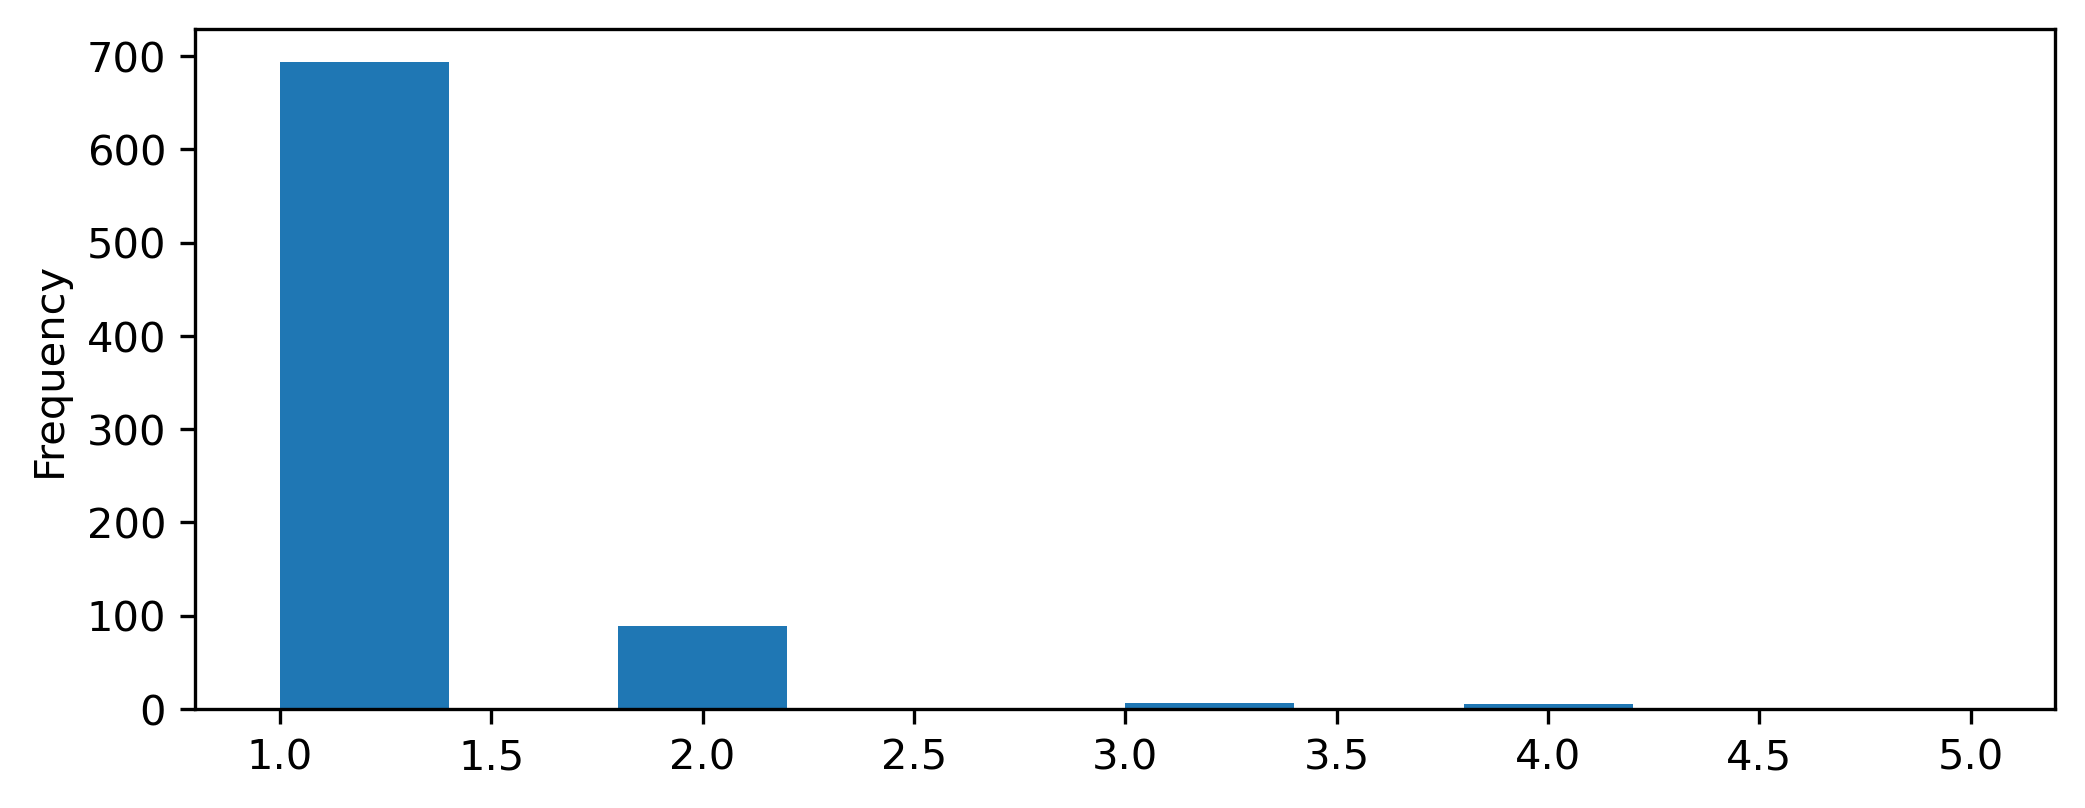

In [15]:
print('Number of unique patients = ',abpain_cohort1['PtSSN'].unique().shape)
print('Number of patient visits = ', abpain_cohort1.shape)
plt.figure(figsize=(8,3))
abpain_cohort1.groupby(['PtSSN'])[('PtSSN')].agg('count').plot(kind='hist')

# Multiple visits are  tricky
- PtSSN nnn
- generally indicate care escalation

In [ ]:
recs = abpain_cohort1[abpain_cohort1.PtSSN==nnn].sort_values(by='EDStartDateTime')

display(recs)

for i in range(recs.shape[0]):
    print(i,recs[recs.AdmitDateTime <= recs.iloc[i].EDStartDateTime].shape[0])
    
# time in hours between successive ED visits for those with multiple visits
for i in range(recs.shape[0]-1):
    print(i,recs.iloc[i+1].EDStartDateTime - recs.iloc[i].EDEndDateTime)


# Process demographics
- age, gender, ethnicity, race for each patient

In [145]:
demo_df = dataset['Demorgraphics']

demo_df.rename(columns={'patientSSN':'PtSSN'},inplace=True)
demo_df.PtSSN = demo_df.PtSSN.astype('int32')

abpain_demo = pd.merge(abpain_cohort[['PtSSN']],demo_df,on='PtSSN')
abpain_demo['age'] = (abpain_demo['IndexDateTime'] - abpain_demo['DOB'])/np.timedelta64(1,'Y')

def clean_race_values(x):
    if (x=='DECLINED TO ANSWER') | (x=='UNKNOWN BY PATIENT'):
        return 'UNKNOWN'
    if (x=='AMERICAN INDIAN OR ALASKA NATIVE') | (x=='NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER'):
        return 'ALASKA/PACIFIC'
    return x

abpain_demo['new_race'] = abpain_demo.Race.apply(lambda x: clean_race_values(x))
print(abpain_demo.shape)

abpain_demo_labeled = pd.merge(abpain_demo,labels_df,on='PtSSN')
print(abpain_demo_labeled.shape)

(795, 9)
(104, 10)


In [ ]:
abpain_demo.head()

In [15]:
abpain_demo.new_race.value_counts()

WHITE                        519
BLACK OR AFRICAN AMERICAN    202
UNKNOWN                       33
ALASKA/PACIFIC                19
ASIAN                          9
Name: new_race, dtype: int64

# Code categorical fields in demo df
- gender and ethnicity are boolean
- new_race has 5 categories (use get_dummies)
- none of age, race, ethnicity are significant in the labeled examples

In [156]:
# code Gender, Ethnicity, new_race using get_dummies
tmp1 = pd.get_dummies(abpain_demo[['new_race']])
tmp2 = pd.DataFrame(abpain_demo['Gender'].apply(lambda x: 1 if x=='M' else 0))
tmp3 = pd.DataFrame(abpain_demo['Ethnicity'].apply(lambda x: 1 if x=='HISPANIC OR LATINO' else 0))
abpain_demo_df = pd.concat([abpain_demo[['PtSSN','age',]],tmp1,tmp2,tmp3],axis=1)
abpain_demo_df_labeled = pd.merge(abpain_demo_df,labels_df,on='PtSSN')
print(abpain_demo_df.shape,abpain_demo_df_labeled.shape)

demo_fields = abpain_demo_df.columns[1:]
ttest_fields(abpain_demo_df_labeled,demo_fields)

(795, 9) (104, 10)
age Ttest_indResult(statistic=-0.26682926258740697, pvalue=0.7901393320205181)
new_race_ALASKA/PACIFIC Ttest_indResult(statistic=0.6254942727738887, pvalue=0.5330437111232542)
new_race_ASIAN Ttest_indResult(statistic=0.6254942727738887, pvalue=0.5330437111232542)
new_race_BLACK OR AFRICAN AMERICAN Ttest_indResult(statistic=-0.7232056815492273, pvalue=0.47120870255026925)
new_race_UNKNOWN Ttest_indResult(statistic=-0.6498273932558098, pvalue=0.5172645382674323)
new_race_WHITE Ttest_indResult(statistic=0.4420006521708172, pvalue=0.6594244579977162)
Gender Ttest_indResult(statistic=0.8924784174495595, pvalue=0.37423726273421776)
Ethnicity Ttest_indResult(statistic=1.7856825162529937, pvalue=0.07712248449172046)


# Process Labs

- labs are by visit date in ER; 
    - WBC
    - BMP (Glucose, Calcium, Sodium, Potassium, CO2, Chloride, BUN, Creatinine) 
    - Urine Analysis
    - Lactate, amylase

In [157]:
labs_df = dataset['Lab']

labs_df.rename(columns={'PatientSSN':'PtSSN','PatientSID':'patientsid'},inplace=True)
labs_df.PtSSN = labs_df.PtSSN.astype('int32')

# restrict labs to abpain cohort
abpain_labs1 = pd.merge(labs_df,abpain_cohort1[['PtSSN','EDStartDateTime','EDEndDateTime']],on=['PtSSN'])

# restrict labs to abpain cohort within the ED Start and End Times
abpain_labs2 = abpain_labs1[(abpain_labs1.LabChemSpecimenDateTime >= abpain_labs1.EDStartDateTime) & (abpain_labs1.LabChemSpecimenDateTime <= abpain_labs1.EDEndDateTime)].copy()

abpain_labs2.shape

(48930, 14)

(812, 4) 795


<AxesSubplot:ylabel='Frequency'>

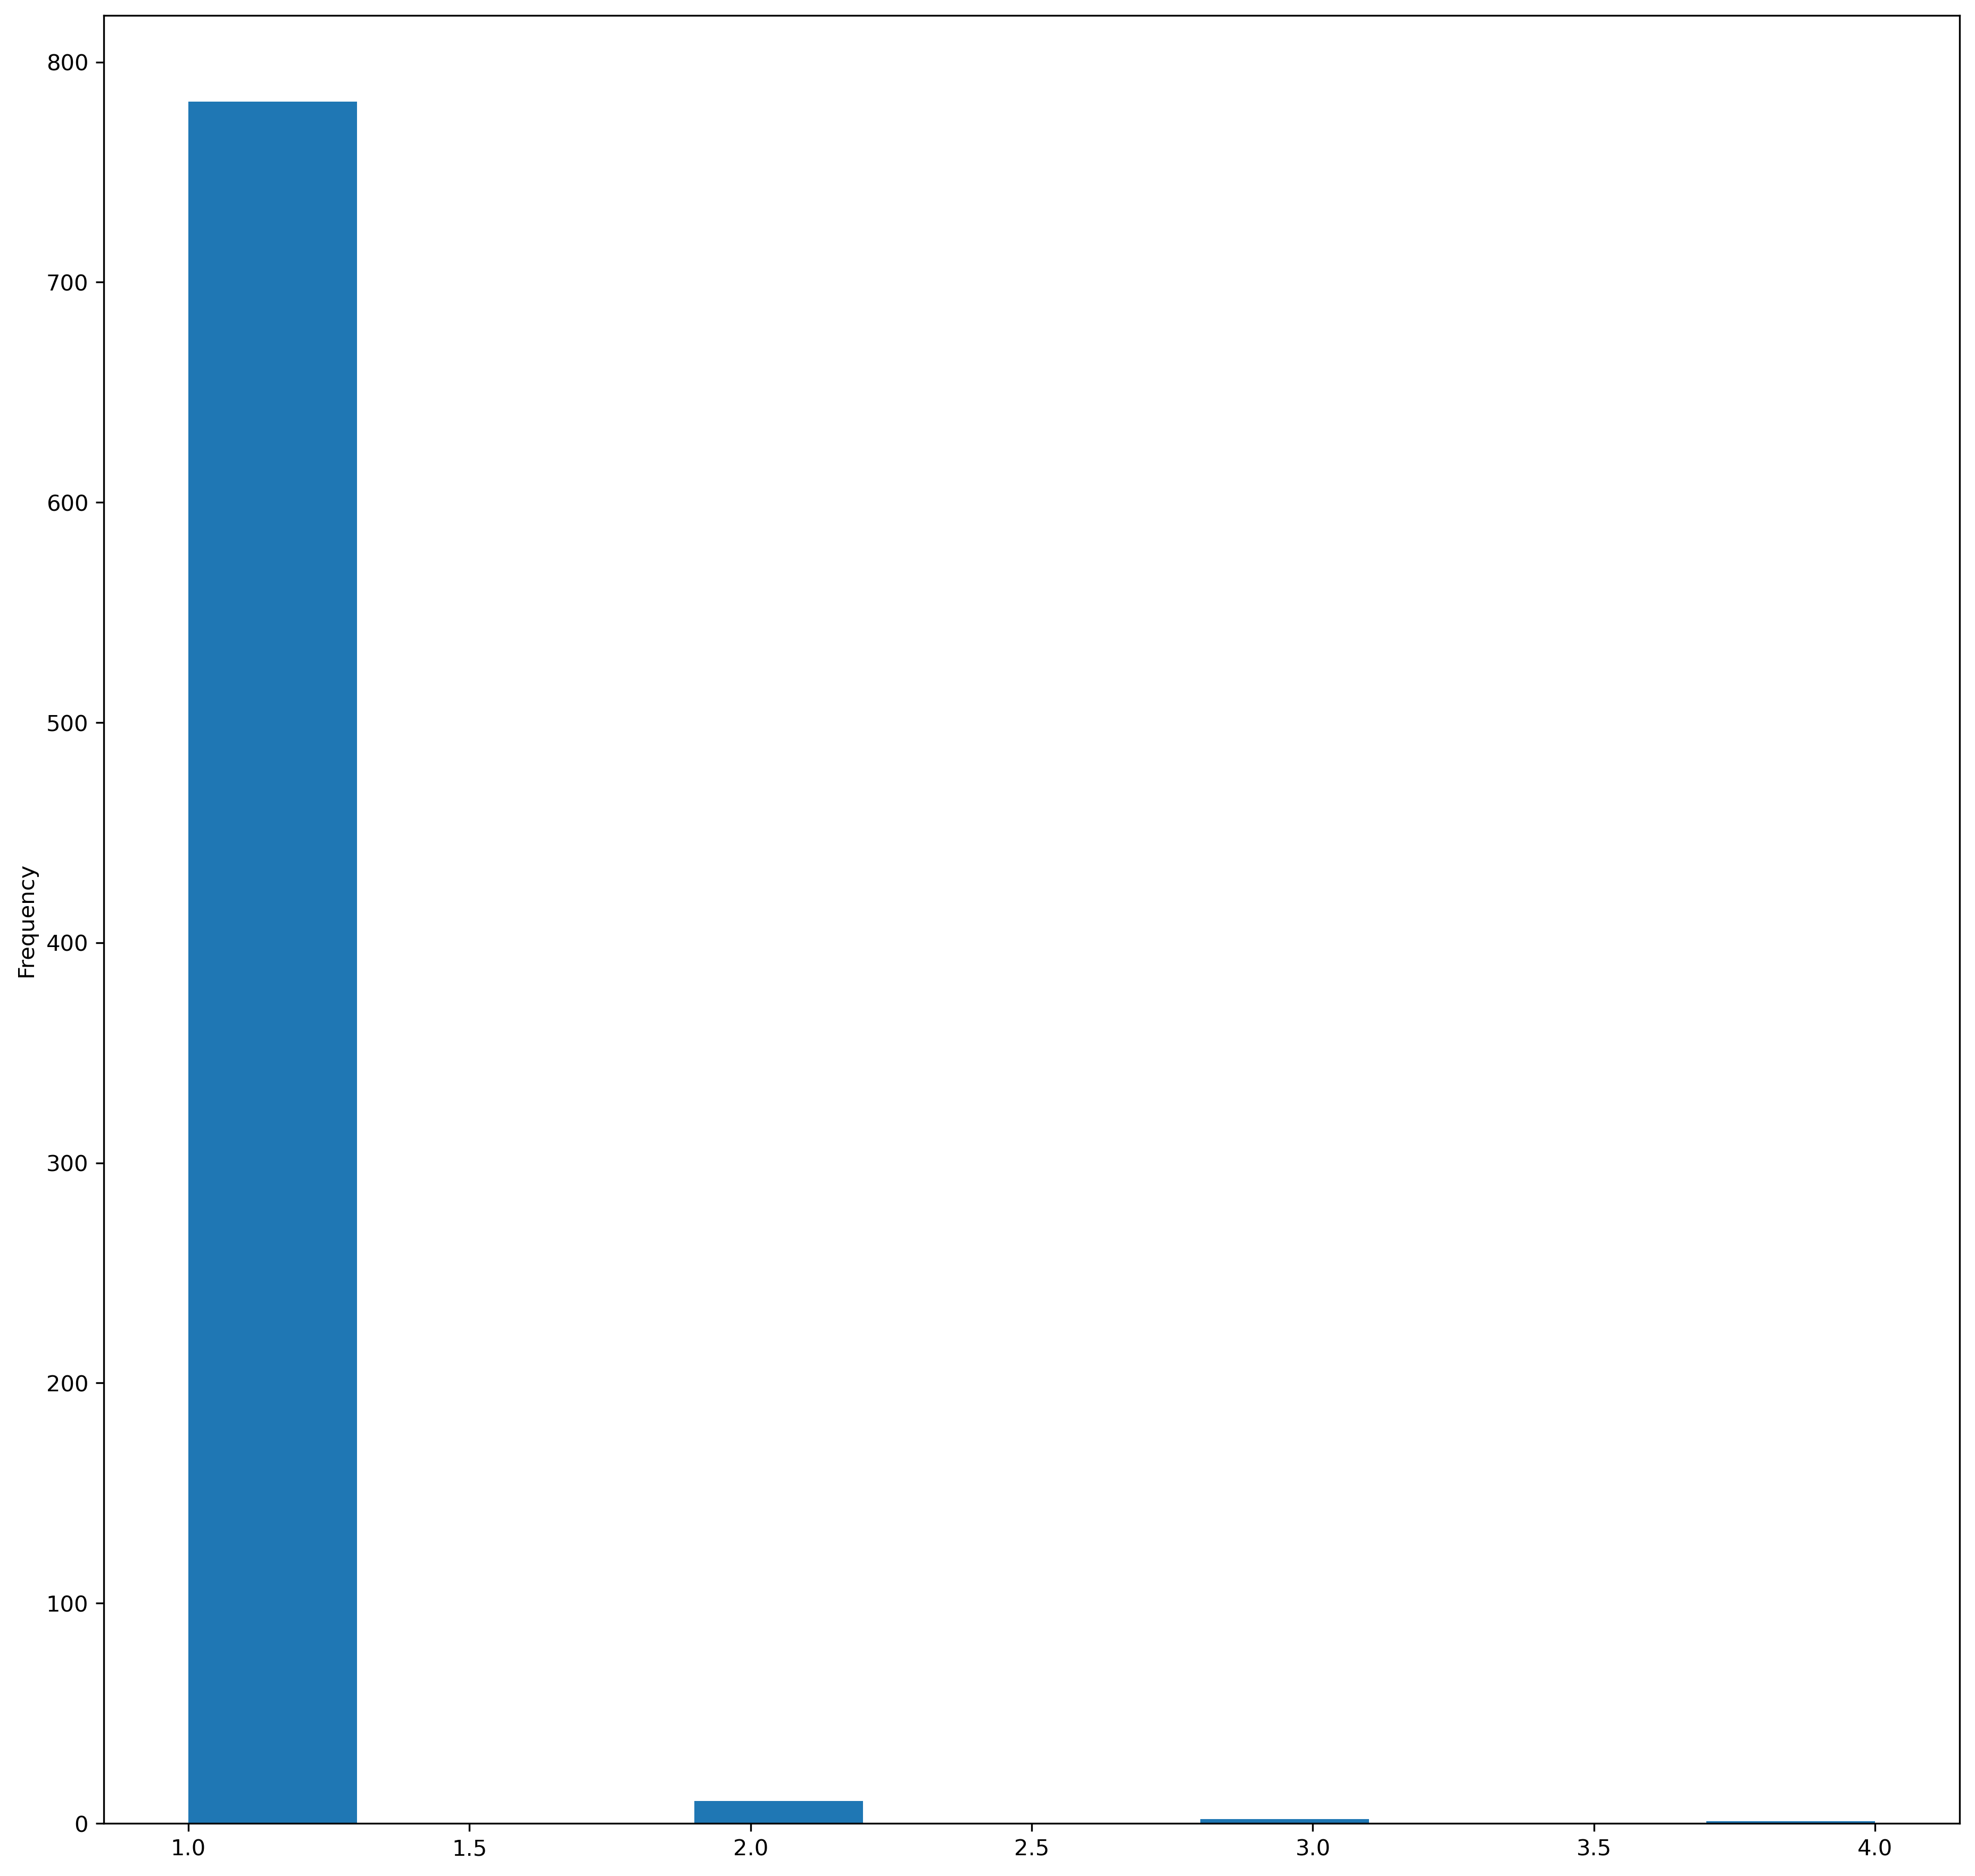

In [158]:
wbc_df = lab_values(matches_WBC,abpain_cohort1,abpain_labs2)
wbc_df_labeled = pd.merge(wbc_df,labels_df,on='PtSSN')
print(wbc_df.shape, len(wbc_df.PtSSN.unique()))
wbc_df.groupby('PtSSN')['PtSSN'].agg('count').plot(kind='hist')

In [288]:
albumin_df = lab_values(matches_albumin,abpain_cohort1,abpain_labs2)
albumin_df.shape
albumin_df_labeled = pd.merge(albumin_df,labels_df,on='PtSSN')
albumin_df_labeled.shape

(112, 5)

In [159]:
glucose_df = lab_values(matches_glucose,abpain_cohort1,abpain_labs2)
sodium_df = lab_values(matches_sodium,abpain_cohort1,abpain_labs2)
albumin_df = lab_values(matches_albumin,abpain_cohort1,abpain_labs2)
potassium_df = lab_values(matches_potassium,abpain_cohort1,abpain_labs2)
calcium_df = lab_values(matches_calcium,abpain_cohort1,abpain_labs2)
lactate_df = lab_values(matches_lact,abpain_cohort1,abpain_labs2)
chloride_df = lab_values(matches_chloride,abpain_cohort1,abpain_labs2)
bun_df = lab_values(matches_bun,abpain_cohort1,abpain_labs2)
creat_df = lab_values(matches_creat,abpain_cohort1,abpain_labs2)
troponin_df = lab_values(matches_troponin,abpain_cohort1,abpain_labs2)
co2_df = lab_values(matches_CO2,abpain_cohort1,abpain_labs2)
ast_df = lab_values(matches_ast,abpain_cohort1,abpain_labs2)
alt_df = lab_values(matches_alt,abpain_cohort1,abpain_labs2)
alkphos_df = lab_values(matches_alkphos,abpain_cohort1,abpain_labs2)
lipase_df = lab_values(matches_lipase,abpain_cohort1,abpain_labs2)
amylase_df = lab_values(matches_amylase,abpain_cohort1,abpain_labs2)
urine_df = lab_values(matches_urine,abpain_cohort1,abpain_labs2)

In [160]:
glucose_df_labeled = pd.merge(glucose_df,labels_df,on='PtSSN')
sodium_df_labeled = pd.merge(sodium_df,labels_df,on='PtSSN')
albumin_df_labeled = pd.merge(albumin_df,labels_df,on='PtSSN')
potassium_df_labeled = pd.merge(potassium_df,labels_df,on='PtSSN')
calcium_df_labeled = pd.merge(calcium_df,labels_df,on='PtSSN')
lactate_df_labeled = pd.merge(lactate_df,labels_df,on='PtSSN')
chloride_df_labeled = pd.merge(chloride_df,labels_df,on='PtSSN')
bun_df_labeled = pd.merge(bun_df,labels_df,on='PtSSN')
creat_df_labeled = pd.merge(creat_df,labels_df,on='PtSSN')
troponin_df_labeled = pd.merge(troponin_df,labels_df,on='PtSSN')
co2_df_labeled = pd.merge(co2_df,labels_df,on='PtSSN')
ast_df_labeled = pd.merge(ast_df,labels_df,on='PtSSN')
alt_df_labeled = pd.merge(alt_df,labels_df,on='PtSSN')
alkphos_df_labeled = pd.merge(alkphos_df,labels_df,on='PtSSN')
lipase_df_labeled = pd.merge(lipase_df,labels_df,on='PtSSN')
amylase_df_labeled = pd.merge(amylase_df,labels_df,on='PtSSN')
urine_df_labeled = pd.merge(urine_df,labels_df,on='PtSSN')

In [289]:
labnames = ['wbc','glucose','sodium','potassium','calcium','lactate','chloride','bun','creat','troponin',
           'co2','ast','alt','alkphos','lipase','amylase','urine','albumin']
for lab in labnames:
    print(ttest_lab(eval(lab+'_df_labeled'),lab))

('wbc', 0.20906286451505957)
('glucose', 0.3916776205477682)
('sodium', 0.022182473863827292)
('potassium', 0.14141953089917658)
('calcium', 0.8822191480126496)
('lactate', 0.529243235268157)
('chloride', 0.05200279083152278)
('bun', 0.7542329719055834)
('creat', 0.4621198338806696)
('troponin', 0.015432181314474406)
('co2', 0.6910143856621904)
('ast', 0.2951197973939715)
('alt', 0.4946419291992358)
('alkphos', 0.9917789201256554)
('lipase', 0.7524799088351337)
('amylase', 0.03921549028307911)
('urine', 0.19924016912243883)
('albumin', 0.7180684534065164)


In [26]:
# how many non NA troponin?
troponin_df_labeled.value.isna().sum()

92

# Diagnosis at ED

In [24]:
icd_df = dataset['ICD']
icd_df.rename(columns={'PatientSSN':'PtSSN'},inplace=True)
icd_df.PtSSN = icd_df.PtSSN.astype('int32')

# restrict to patients in abpain_cohort visit# restrict labs to abpain cohort
abpain_icd1 = pd.merge(icd_df,abpain_cohort1[['PtSSN','EDStartDateTime','EDEndDateTime']],on='PtSSN')

# restrict to abpain cohort within the ED Start and End Times
abpain_icd2 = abpain_icd1[(abpain_icd1.DiagDateTime >= abpain_icd1.EDStartDateTime) & (abpain_icd1.DiagDateTime <= abpain_icd1.EDEndDateTime)]

# restrict to PrincipalDiagnosis
abpain_icd3 = abpain_icd2[abpain_icd2.IsPrincipalDiag==1].copy()
abpain_icd3_labeled = pd.merge(abpain_icd3,labels_df,on='PtSSN')
print(abpain_icd3.shape, abpain_icd3_labeled.shape)
print(abpain_icd3.ICD.value_counts().shape)
print(abpain_icd3_labeled.ICD.value_counts().shape)


(1860, 7) (264, 8)
(253,)
(55,)


In [ ]:
abpain_icd3.head()

In [25]:
abpain_icd3_labeled.ICDDiagnosis.value_counts()

Unspecified abdominal pain                                      41
Generalized abdominal pain                                      23
Lower abdominal pain, unspecified                               20
Epigastric pain                                                 17
Fever, unspecified                                              14
Upper abdominal pain, unspecified                               12
Encntr for obs for oth suspected diseases and cond ruled out    12
Nausea with vomiting, unspecified                               12
Encounter for screening for cardiovascular disorders             9
Right lower quadrant pain                                        6
Oth symptoms and signs involving the circ and resp systems       5
Tachycardia, unspecified                                         5
Left lower quadrant pain                                         4
Type 2 diabetes mellitus with hyperglycemia                      4
Other nonspecific abnormal finding of lung field              

# Analysis of differences between MOD and NoMOD cohort in principal ED diagnosis

In [104]:
mod_icds = abpain_icd3_labeled[abpain_icd3_labeled.label=='MOD'].groupby('ICDDiagnosis')['ICD'].agg('count').reset_index()
mod_icds.columns = ['ICDDiagnosis','icd_count']
mod_icds = mod_icds.sort_values(by='icd_count',ascending=False)

nomod_icds = abpain_icd3_labeled[abpain_icd3_labeled.label=='NoMOD'].groupby('ICDDiagnosis')['ICD'].agg('count').reset_index()
nomod_icds.columns = ['ICDDiagnosis','icd_count']
nomod_icds = nomod_icds.sort_values(by='icd_count',ascending=False)

display(mod_icds)
display(nomod_icds)
mod_icds.to_csv('mod_icds.csv')
nomod_icds.to_csv('nomod_icds.csv')

# which ICDs are exclusively in MOD but not in NoMOD
diff_icds = list(set(mod_icds.ICDDiagnosis).difference(set(nomod_icds.ICDDiagnosis)))


only_mods = abpain_icd3_labeled[abpain_icd3_labeled.ICDDiagnosis.isin(diff_icds)].groupby('ICDDiagnosis')['ICD'].agg('count').reset_index().sort_values(by='ICD',ascending=False)
only_mods.to_csv('only_mods.csv')

ICDDiagnosis  icd_count
22                                    Unspecified abdominal pain         15
8                                             Fever, unspecified         14
14                             Nausea with vomiting, unspecified         11
10                                    Generalized abdominal pain         11
20                                     Right lower quadrant pain          6
7                                                Epigastric pain          5
21                                      Tachycardia, unspecified          4
24                             Upper abdominal pain, unspecified          4
3   Encntr for obs for oth suspected diseases and cond ruled out          4
11      Hepatomegaly with splenomegaly, not elsewhere classified          3
12                                      Left lower quadrant pain          3
17              Other nonspecific abnormal finding of lung field          3
1                                                          Cough          2
5           Encounter for screening for cardiovascular disorders          2
19                                                  Palpitations          2
18                          Other specified diseases of pancreas          1
23      Unspecified complication of procedure, initial encounter          1
0                                 Acute pharyngitis, unspecified          1
13                             Lower abdominal pain, unspecified          1
16                                                 Other malaise          1
15    Oth symptoms and signs involving the circ and resp systems          1
9              Gastro-esophageal reflux disease with esophagitis          1
6               Encounter for screening for other viral diseases          1
4   Encntr for surgical aftcr following surgery on the dgstv sys          1
2     Dvrtclos of lg int w/o perforation or abscess w/o bleeding          1
25                   Urinary tract infection, site not specified          1

ICDDiagnosis  icd_count
39                                    Unspecified abdominal pain         34
27                             Lower abdominal pain, unspecified         20
20                                               Epigastric pain         16
22                                    Generalized abdominal pain         15
15  Encntr for obs for oth suspected diseases and cond ruled out         10
42                             Upper abdominal pain, unspecified          9
17          Encounter for screening for cardiovascular disorders          8
31    Oth symptoms and signs involving the circ and resp systems          4
38                   Type 2 diabetes mellitus with hyperglycemia          4
24                                          Illness, unspecified          3
12                                         Diarrhea, unspecified          3
16               Encounter for other administrative examinations          2
36                               Retention of urine, unspecified          2
35     Problem related to unspecified psychosocial circumstances          2
23                                    Heart failure, unspecified          2
7                                        Chest pain, unspecified          2
28                             Nausea with vomiting, unspecified          2
40                               Unspecified atrial fibrillation          1
41                                    Unspecified hydronephrosis          1
37                                      Tachycardia, unspecified          1
29                                      Obstruction of bile duct          1
30            Oth problems related to psychosocial circumstances          1
26                                      Left lower quadrant pain          1
33              Other nonspecific abnormal finding of lung field          1
34                                 Other specified health status          1
32                      Other cholelithiasis without obstruction          1
0                     Abnormal results of liver function studies          1
25           Infectious gastroenteritis and colitis, unspecified          1
1                           Atrioventricular block, first degree          1
19                             Enlarged lymph nodes, unspecified          1
18               Encounter for therapeutic drug level monitoring          1
14     Dvtrcli of lg int w/o perforation or abscess w/o bleeding          1
13                                   Duodenitis without bleeding          1
11    Crohn's disease of small intestine with other complication          1
10                                       Counseling, unspecified          1
9                                                          Cough          1
8                                      Constipation, unspecified          1
6                                                   Cardiomegaly          1
5      Calculus of gallbladder w/o cholecystitis w/o obstruction          1
4    Calculus of bile duct w/o cholangitis or cholecyst w/o obst          1
3     Calculus of GB and bile duct w/o cholecyst w/o obstruction          1
2                                       Bradycardia, unspecified          1
21                                            Fever, unspecified          1

In [28]:
only_mods

ICDDiagnosis  ICD
4                                             Fever, unspecified   14
10                                     Right lower quadrant pain    6
6       Hepatomegaly with splenomegaly, not elsewhere classified    2
9                                                   Palpitations    2
0                                 Acute pharyngitis, unspecified    1
1     Dvrtclos of lg int w/o perforation or abscess w/o bleeding    1
2   Encntr for surgical aftcr following surgery on the dgstv sys    1
3               Encounter for screening for other viral diseases    1
5              Gastro-esophageal reflux disease with esophagitis    1
7                                                  Other malaise    1
8                           Other specified diseases of pancreas    1
11                   Urinary tract infection, site not specified    1

In [116]:
# group ICDs based on type
relevant_ICDs = ['Unspecified abdominal pain', 'Fever, unspecified',
       'Nausea with vomiting, unspecified', 'Generalized abdominal pain',
       'Right lower quadrant pain', 'Epigastric pain',
       'Upper abdominal pain, unspecified','Lower abdominal pain, unspecified',
       ]

# merge counts of unspecified abdominal pain and generalized abdominal pain
# count up presence/absence of these discharge codes on a per visit basis

c = 0
icd_dx_labeled = {}
for PtSSN in abpain_cohort1_labeled.PtSSN.unique():
    recs = abpain_icd3_labeled[abpain_icd3_labeled.PtSSN==PtSSN]
    diags = recs.ICDDiagnosis
    tmp_vc = pd.merge(diags,pd.DataFrame(relevant_ICDs,columns=['ICDDiagnosis']),on='ICDDiagnosis').ICDDiagnosis.value_counts()
    icd_dx_labeled[c] = {'PtSSN':PtSSN}
    for icd in relevant_ICDs:
        if icd in tmp_vc:
            icd_dx_labeled[c][icd] = tmp_vc[icd]
        else:
            icd_dx_labeled[c][icd] = 0
    c = c + 1
icd_dx_labeled_df = pd.DataFrame.from_dict(icd_dx_labeled,orient='index')
icd_dx_labeled_df = pd.merge(icd_dx_labeled_df,labels_df,on='PtSSN')

In [118]:
for field in icd_dx_labeled_df.columns[1:-1]:
    print(field,scipy.stats.ttest_ind(icd_dx_labeled_df[icd_dx_labeled_df.label=='MOD'][field],
                      icd_dx_labeled_df[icd_dx_labeled_df.label=='NoMOD'][field] ))

Unspecified abdominal pain Ttest_indResult(statistic=0.12082233556634861, pvalue=0.9040694462655744)
Fever, unspecified Ttest_indResult(statistic=1.7272612123253805, pvalue=0.08714768530115559)
Nausea with vomiting, unspecified Ttest_indResult(statistic=1.550064217738766, pvalue=0.12422340040861164)
Generalized abdominal pain Ttest_indResult(statistic=1.0262225370029403, pvalue=0.30721425183999507)
Right lower quadrant pain Ttest_indResult(statistic=1.5448425361629774, pvalue=0.12548138176666324)
Epigastric pain Ttest_indResult(statistic=-0.3339587482202263, pvalue=0.7390963142563101)
Upper abdominal pain, unspecified Ttest_indResult(statistic=0.07400298786119071, pvalue=0.9411529420040415)
Lower abdominal pain, unspecified Ttest_indResult(statistic=-1.246280164408872, pvalue=0.2155162770467624)


In [44]:
# count up presence/absence of these discharge codes on a per visit basis
c = 0
icd_dx_labeled = {}
for PtSSN in abpain_cohort1_labeled.PtSSN.unique():
    recs = abpain_icd3_labeled[abpain_icd3_labeled.PtSSN==PtSSN]
    diags = recs.ICDDiagnosis
    tmp_vc = pd.merge(diags,dx_codes_df,on='ICDDiagnosis').ICDDiagnosis.value_counts()
    icd_dx_labeled[c] = {'PtSSN':PtSSN}
    for icd in dx_codes_df.ICDDiagnosis:
        if icd in tmp_vc:
            icd_dx_labeled[c][icd] = tmp_vc[icd]
        else:
            icd_dx_labeled[c][icd] = 0
    c = c + 1
icd_dx_labeled_df = pd.DataFrame.from_dict(icd_dx_labeled,orient='index')

In [222]:
c = 0
icd_dx = {}
for PtSSN in abpain_cohort1.PtSSN.unique():
    recs = abpain_icd3[abpain_icd3.PtSSN==PtSSN]
    diags = recs.ICDDiagnosis
    tmp_vc = pd.merge(diags,dx_codes_df,on='ICDDiagnosis').ICDDiagnosis.value_counts()
    icd_dx[c] = {'PtSSN':PtSSN}
    for icd in dx_codes_df.ICDDiagnosis:
        if icd in tmp_vc:
            icd_dx[c][icd] = tmp_vc[icd]
        else:
            icd_dx[c][icd] = 0
    c = c + 1
icd_dx_df = pd.DataFrame.from_dict(icd_dx,orient='index')
icd_dx_labeled_df = pd.merge(icd_dx_df,labels_df,on=['PtSSN'])

In [ ]:
icd_dx_df.head()

In [100]:
# how frequent are these in the general trigger positive set?
abpain_icd3[abpain_icd3.ICDDiagnosis.isin(diff_icds)].groupby('ICDDiagnosis')['ICD'].agg('count').reset_index().sort_values(by='ICD',ascending=False)

ICDDiagnosis  ICD
4                                             Fever, unspecified   83
11                   Urinary tract infection, site not specified   21
10                                     Right lower quadrant pain   14
7                                                  Other malaise    6
3               Encounter for screening for other viral diseases    5
6       Hepatomegaly with splenomegaly, not elsewhere classified    3
5              Gastro-esophageal reflux disease with esophagitis    2
9                                                   Palpitations    2
0                                 Acute pharyngitis, unspecified    1
1     Dvrtclos of lg int w/o perforation or abscess w/o bleeding    1
2   Encntr for surgical aftcr following surgery on the dgstv sys    1
8                           Other specified diseases of pancreas    1

In [101]:
abpain_icd3.groupby('ICDDiagnosis')['ICD'].agg('count').reset_index().sort_values(by='ICD',ascending=False)

ICDDiagnosis  ICD
236                                    Unspecified abdominal pain  350
245                             Upper abdominal pain, unspecified  161
110                                    Generalized abdominal pain  127
144                             Lower abdominal pain, unspecified  119
100                                               Epigastric pain   91
104                                            Fever, unspecified   83
90           Encounter for screening for cardiovascular disorders   68
78   Encntr for obs for oth suspected diseases and cond ruled out   64
152                             Nausea with vomiting, unspecified   51
43                                        Chest pain, unspecified   28
216                                     Right upper quadrant pain   27
246                   Urinary tract infection, site not specified   21
94                Encounter for therapeutic drug level monitoring   19
185                                    Other specified counseling   19
8                                                   Acute abdomen   15
61                                          Diarrhea, unspecified   14
215                                     Right lower quadrant pain   14
137                                      Left lower quadrant pain   14
101                              Essential (primary) hypertension   13
228                                      Tachycardia, unspecified   13
182              Other nonspecific abnormal finding of lung field   12
51                                      Constipation, unspecified   11
190                                 Other specified health status   11
232        Ulcerative colitis, unspecified, without complications   11
77    Encntr for general adult medical exam w/o abnormal findings   11
113                                                      Headache    9
170                                              Other chest pain    9
209     Problem related to unspecified psychosocial circumstances    9
156         Noninfective gastroenteritis and colitis, unspecified    8
33                                       Bradycardia, unspecified    8
96                              Enlarged lymph nodes, unspecified    8
241                            Unspecified intestinal obstruction    8
53                                                          Cough    7
143                                                 Low back pain    7
37      Calculus of gallbladder w/o cholecystitis w/o obstruction    7
153          Neoplasm of uncertain behavior of left adrenal gland    7
181                                                 Other malaise    6
253                                         Vomiting, unspecified    6
180                        Other long term (current) drug therapy    6
81         Encounter for administrative examinations, unspecified    6
141                                Localized enlarged lymph nodes    6
72      Dvtrcli of lg int w/o perforation or abscess w/o bleeding    6
17                 Acute upper respiratory infection, unspecified    6
83                        Encounter for other general examination    6
171                      Other cholelithiasis without obstruction    5
166    Oth symptoms and signs involving the circ and resp systems    5
117                                        Hematuria, unspecified    5
93               Encounter for screening for other viral diseases    5
138                                      Left upper quadrant pain    5
54                                        Counseling, unspecified    5
202                                  Plantar fascial fibromatosis    5
38                                             Calculus of kidney    5
40                                             Calculus of ureter    5
222                                           Shortness of breath    5
48   Chronic obstructive pulmonary disease w (acute) exacerbation    4
173                                      Other cirrhosis of liver    4
212   

In [108]:
# aggregate by number of ICDs at discharge and check if there is difference bwteen mod and nomod
# no difference in number of ICDs between MOD and NoMOD
num_icds_labeled = pd.merge(abpain_icd3.groupby('PtSSN')['ICD'].agg('count').reset_index(),labels_df,on='PtSSN')
num_icds_labeled.groupby('label').describe()
scipy.stats.ttest_ind(num_icds_labeled[num_icds_labeled.label=='MOD'].ICD,
                     num_icds_labeled[num_icds_labeled.label=='NoMOD'].ICD)

Ttest_indResult(statistic=1.473835130998445, pvalue=0.14426379512862525)

# Get vitals data for abpain cohort

In [25]:
vitals = dataset['Vital']
vitals.rename(columns={'PatientSSN':'PtSSN'},inplace=True)
vitals.PtSSN = vitals.PtSSN.astype('int32')
# restrict vitals to abpain cohort
abpain_vitals1 = pd.merge(vitals,abpain_cohort1,on='PtSSN')

# restrict vitals to abpain cohort within the ED Start and End Times
abpain_vitals2 = abpain_vitals1[(abpain_vitals1.VitalSignTakenDateTime >= abpain_vitals1.EDStartDateTime) & (abpain_vitals1.VitalSignTakenDateTime <= abpain_vitals1.EDEndDateTime)].copy()


In [26]:
# get vitals for a patient for a specific ED visit
abpain_vitals2.columns
vital_columns = ['VitalSignTakenDateTime', 'VitalType', 'VitalResult',
       'VitalResultNumeric', 'Systolic', 'Diastolic', 'SupplementalO2',
       'LocationSID', 'VitalSignSID']
vital_fields = ['BLOOD PRESSURE','PULSE','RESPIRATION','PULSE OXIMETRY','PAIN','TEMPERATURE']

vital_dict = {}

# take the first vital sign upon admission (likely to be the worst)

for PtSSN in abpain_cohort.PtSSN.unique():
    vital_dict[PtSSN] = {}
    rec = abpain_vitals2[abpain_vitals2.PtSSN==PtSSN][vital_columns].sort_values(by='VitalSignTakenDateTime')
    
    for field in vital_fields:
        if (field != 'BLOOD PRESSURE'):
            results = rec[rec.VitalType==field]
            if results.shape[0] > 0:
                result = results.iloc[0].VitalResultNumeric
            else:
                result = None
            vital_dict[PtSSN][field] = result
           
        else:
            results = rec[rec.VitalType==field]
            if results.shape[0] > 0:
                (sbp, dbp) = results.iloc[0].VitalResult.split('/')
                    
                if sbp:
                    vital_dict[PtSSN]['SBP'] = float(sbp)
                else:
                    vital_dict[PtSSN]['SBP'] = None
                if dbp:
                    vital_dict[PtSSN]['DBP'] = float(dbp)
                else:
                    vital_dict[PtSSN]['DBP'] = None
            else:
                vital_dict[PtSSN]['SBP'] = None
                vital_dict[PtSSN]['DBP'] = None
            # print(field, float(sbp),float(dbp) )


clean_vitals_df = pd.DataFrame.from_dict(vital_dict,orient='index').reset_index()
clean_vitals_df.rename(columns={'index':'PtSSN'},inplace=True)

clean_vitals_df_labeled = pd.merge(clean_vitals_df,labels_df,on='PtSSN')


In [166]:
vitals_fields = clean_vitals_df_labeled.columns[1:-1]
ttest_fields(clean_vitals_df_labeled,vitals_fields)

SBP Ttest_indResult(statistic=0.3607413034486637, pvalue=0.7190388653632338)
DBP Ttest_indResult(statistic=-1.012051939780153, pvalue=0.3139079576440444)
PULSE Ttest_indResult(statistic=1.4115839667812846, pvalue=0.16111573150440128)
RESPIRATION Ttest_indResult(statistic=0.11831332622462089, pvalue=0.9060520829704695)
PULSE OXIMETRY Ttest_indResult(statistic=nan, pvalue=nan)
PAIN Ttest_indResult(statistic=nan, pvalue=nan)
TEMPERATURE Ttest_indResult(statistic=1.7730973841049027, pvalue=0.07919748823212376)


In [227]:
# how many have high temperature and tachycardia
clean_vitals_df[(clean_vitals_df.TEMPERATURE > 100.4) & (clean_vitals_df.PULSE > 90)].shape

(86, 8)

# Imaging for abpain cohort
- ct images: how many ordered, how many w/contrast, how many abnormal
- xr images: how many ordered, how many abnormal
- us images: how many ordered, how many abnormal

In [28]:
images = dataset['Rad']
images.rename(columns={'PatientSSN':'PtSSN'},inplace=True)
images.PtSSN = images.PtSSN.astype('int32')
# restrict vitals to abpain cohort
abpain_img1 = pd.merge(images,abpain_cohort1[['PtSSN','EDStartDateTime','EDEndDateTime']],on='PtSSN')

# restrict vitals to abpain cohort within the ED Start and End Times
abpain_img2 = abpain_img1[(abpain_img1.ExamDateTime >= abpain_img1.EDStartDateTime) & (abpain_img1.ExamDateTime <= abpain_img1.EDEndDateTime)].copy()

abpain_img2.shape

(1143, 11)

In [31]:
#abpain_img2[abpain_img2.CPTName.str.contains('CT')].value_counts()
abpain_img3 = abpain_img2.dropna(subset={'CPTName'})
abpain_img3[abpain_img3.CPTName.str.contains('US ')].CPTName.value_counts()
#abpain_img3[abpain_img3.CPTName.str.contains('US ')].RadiologyDiagnosticCode.value_counts()

TRANSVAGINAL US NON-OB          3
US EXAM SCROTUM                 3
US COMPL JOINT R-T W/IMG        2
US EXAM ABDO BACK WALL LIM      2
US EXAM PELVIC LIMITED          2
US EXAM PELVIC COMPLETE         2
US EXAM ABDOM COMPLETE          2
US EXAM OF HEAD AND NECK        2
INJECT SINUS TRACT FOR X-RAY    1
LUNG VENTILAT&PERFUS IMAGING    1
Name: CPTName, dtype: int64

In [29]:
def is_img_abnormal(radiology_code):
    if radiology_code:
        return ('abormal' in radiology_code.lower()) | ('malignan' in radiology_code.lower())  ## FIXME 2023-02-22
    else:
        return False
    
def is_ct_with_contrast(cptname):
    return ('w/contrast' in cptname.lower()) | ('w/dye' in cptname.lower())

In [32]:
img_cols = ['PtSSN', 'ExamDateTime', 'CPTCode', 'CPTName',
       'RadiologyDiagnosticCode']

# need to look at it on a visit basis, not a patient basis
# REDO
ct_img = {}

for PtSSN in abpain_cohort.PtSSN.unique():
    recs = abpain_img3[abpain_img3.PtSSN==PtSSN].sort_values(by='ExamDateTime')[img_cols]
    ct_recs = recs[recs.CPTName.str.contains('CT ABD')]
    if ct_recs.shape[0] > 0:
        abcount = 0
        contrast = 0
        for i in range(ct_recs.shape[0]):
            if is_img_abnormal(ct_recs.iloc[i].RadiologyDiagnosticCode):
                abcount = abcount + 1
            if is_ct_with_contrast(ct_recs.iloc[i].CPTName):
                contrast = contrast + 1
        ct_img[PtSSN] = {'num_ct': ct_recs.shape[0],'num_abnormal_ct':abcount,'num_contrast':contrast}
    else:
        ct_img[PtSSN] = {'num_ct': 0,'num_abnormal_ct':0,'num_contrast':0}
        
   
ct_df = pd.DataFrame.from_dict(ct_img,orient='index').reset_index()
ct_df.rename(columns={'index':'PtSSN'},inplace=True)

xr_img = {}
for PtSSN in abpain_cohort.PtSSN.unique():
    recs = abpain_img3[abpain_img3.PtSSN==PtSSN].sort_values(by='ExamDateTime')[img_cols]
    xr_recs = recs[recs.CPTName.str.contains('X-RAY ')]
    if xr_recs.shape[0] > 0:
        abcount = 0
        for i in range(xr_recs.shape[0]):
            if is_img_abnormal(xr_recs.iloc[i].RadiologyDiagnosticCode):
                abcount = abcount + 1
        xr_img[PtSSN] = {'num_xr': xr_recs.shape[0],'num_abnormal_xr':abcount}
    else:
        xr_img[PtSSN] = {'num_xr': 0,'num_abnormal_xr':0}
        
   
xr_df = pd.DataFrame.from_dict(xr_img,orient='index').reset_index()
xr_df.rename(columns={'index':'PtSSN'},inplace=True)

us_img = {}
for PtSSN in abpain_cohort.PtSSN.unique():
    recs = abpain_img3[abpain_img3.PtSSN==PtSSN].sort_values(by='ExamDateTime')[img_cols]
    us_recs = recs[recs.CPTName.str.contains('US ')]
    if us_recs.shape[0] > 0:
        abcount = 0
        for i in range(us_recs.shape[0]):
            if is_img_abnormal(us_recs.iloc[i].RadiologyDiagnosticCode):
                abcount = abcount + 1
        us_img[PtSSN] = {'num_us': us_recs.shape[0],'num_abnormal_us':abcount}
    else:
        us_img[PtSSN] = {'num_us': 0,'num_abnormal_us':0}
        
us_df = pd.DataFrame.from_dict(us_img,orient='index').reset_index()
us_df.rename(columns={'index':'PtSSN'},inplace=True)


In [33]:
# make labeled versions of these three dataframes
ct_df_labeled = pd.merge(ct_df,labels_df,on='PtSSN')
xr_df_labeled = pd.merge(xr_df,labels_df,on='PtSSN')
us_df_labeled = pd.merge(us_df,labels_df,on='PtSSN')

In [34]:
# check if any of the columns are different between MOD and NoMOD
for field in ct_df.columns[1:]:
    tstat,pval = scipy.stats.ttest_ind(ct_df_labeled[ct_df_labeled.label=='MOD'][field].dropna(),
                                      ct_df_labeled[ct_df_labeled.label=='NoMOD'][field].dropna())
    print(field,pval)
    
for field in xr_df.columns[1:]:
    tstat,pval = scipy.stats.ttest_ind(xr_df_labeled[xr_df_labeled.label=='MOD'][field].dropna(),
                                      xr_df_labeled[xr_df_labeled.label=='NoMOD'][field].dropna())
    print(field,pval)
    
for field in us_df.columns[1:]:
    tstat,pval = scipy.stats.ttest_ind(us_df_labeled[us_df_labeled.label=='MOD'][field].dropna(),
                                      us_df_labeled[us_df_labeled.label=='NoMOD'][field].dropna())
    print(field,pval)

num_ct 0.587438003064197
num_abnormal_ct 0.12548138176666326
num_contrast 0.5919080493902652
num_xr 0.09449392726619411
num_abnormal_xr nan
num_us 0.35691944042997203
num_abnormal_us nan


# Consults

In [ ]:
consult_df = dataset['Consult']
consult_df.rename(columns={'PatientSSN':'PtSSN'},inplace=True)
consult_df.PtSSN = consult_df.PtSSN.astype('int32')
# restrict consult to abpain cohort
abpain_consult1 = pd.merge(consult_df,abpain_cohort1[['PtSSN','EDStartDateTime','EDEndDateTime']],on='PtSSN')

# restrict consult to abpain cohort within the ED Start and End Times
abpain_consult2 = abpain_consult1[(abpain_consult1.requestDateTime >= abpain_consult1.EDStartDateTime) & 
                                  (abpain_consult1.requestDateTime <= abpain_consult1.EDEndDateTime)].copy()

abpain_consult2.shape
abpain_consult2.head()

In [36]:
abpain_consult2_labeled = pd.merge(abpain_consult2,labels_df,on='PtSSN')
print(len(abpain_consult2_labeled.PtSSN.unique()))
abpain_consult2_labeled.label.value_counts()

18


NoMOD    22
MOD      14
Name: label, dtype: int64

In [61]:
# lets count number of consults ordered
# unfortunately, none were ordered during visit for the MOD; only a few of the NoMODs got consults

num_consults = {}
c = 0
for index,row in abpain_cohort1.iterrows():
    PtSSN = row.PtSSN
    edstart = row.EDStartDateTime
    edend = row.EDEndDateTime
    recs = abpain_consult2[abpain_consult2.PtSSN==PtSSN].sort_values(by='EDStartDateTime')
    num_consults[c] = recs[(recs.requestDateTime >= edstart) & (recs.requestDateTime <= edend)].shape[0]
    c = c + 1

num_consults_df = pd.concat([abpain_cohort1_labeled[['PtSSN']],pd.DataFrame.from_dict(num_consults,orient='index')],axis=1)
num_consults_df.rename(columns={0:'nconsults'},inplace=True)
num_consults_df_labeled = pd.merge(num_consults_df,labels_df,on='PtSSN')

In [195]:
field = 'nconsults'
scipy.stats.ttest_ind(num_consults_df_labeled[num_consults_df_labeled.label=='MOD'][field],
                                      num_consults_df_labeled[num_consults_df_labeled.label=='NoMOD'][field])

Ttest_indResult(statistic=-0.4727966879636421, pvalue=0.6372783111531515)

In [196]:
num_consults_df_labeled.groupby('label')['nconsults'].describe()

count      mean       std  min  25%  50%  75%   max
label                                                     
MOD     37.0  0.648649  1.917988  0.0  0.0  0.0  0.0  10.0
NoMOD   77.0  0.818182  1.729978  0.0  0.0  0.0  1.0  10.0

label
MOD      AxesSubplot(0.125,0.125;0.775x0.755)
NoMOD    AxesSubplot(0.125,0.125;0.775x0.755)
Name: nconsults, dtype: object

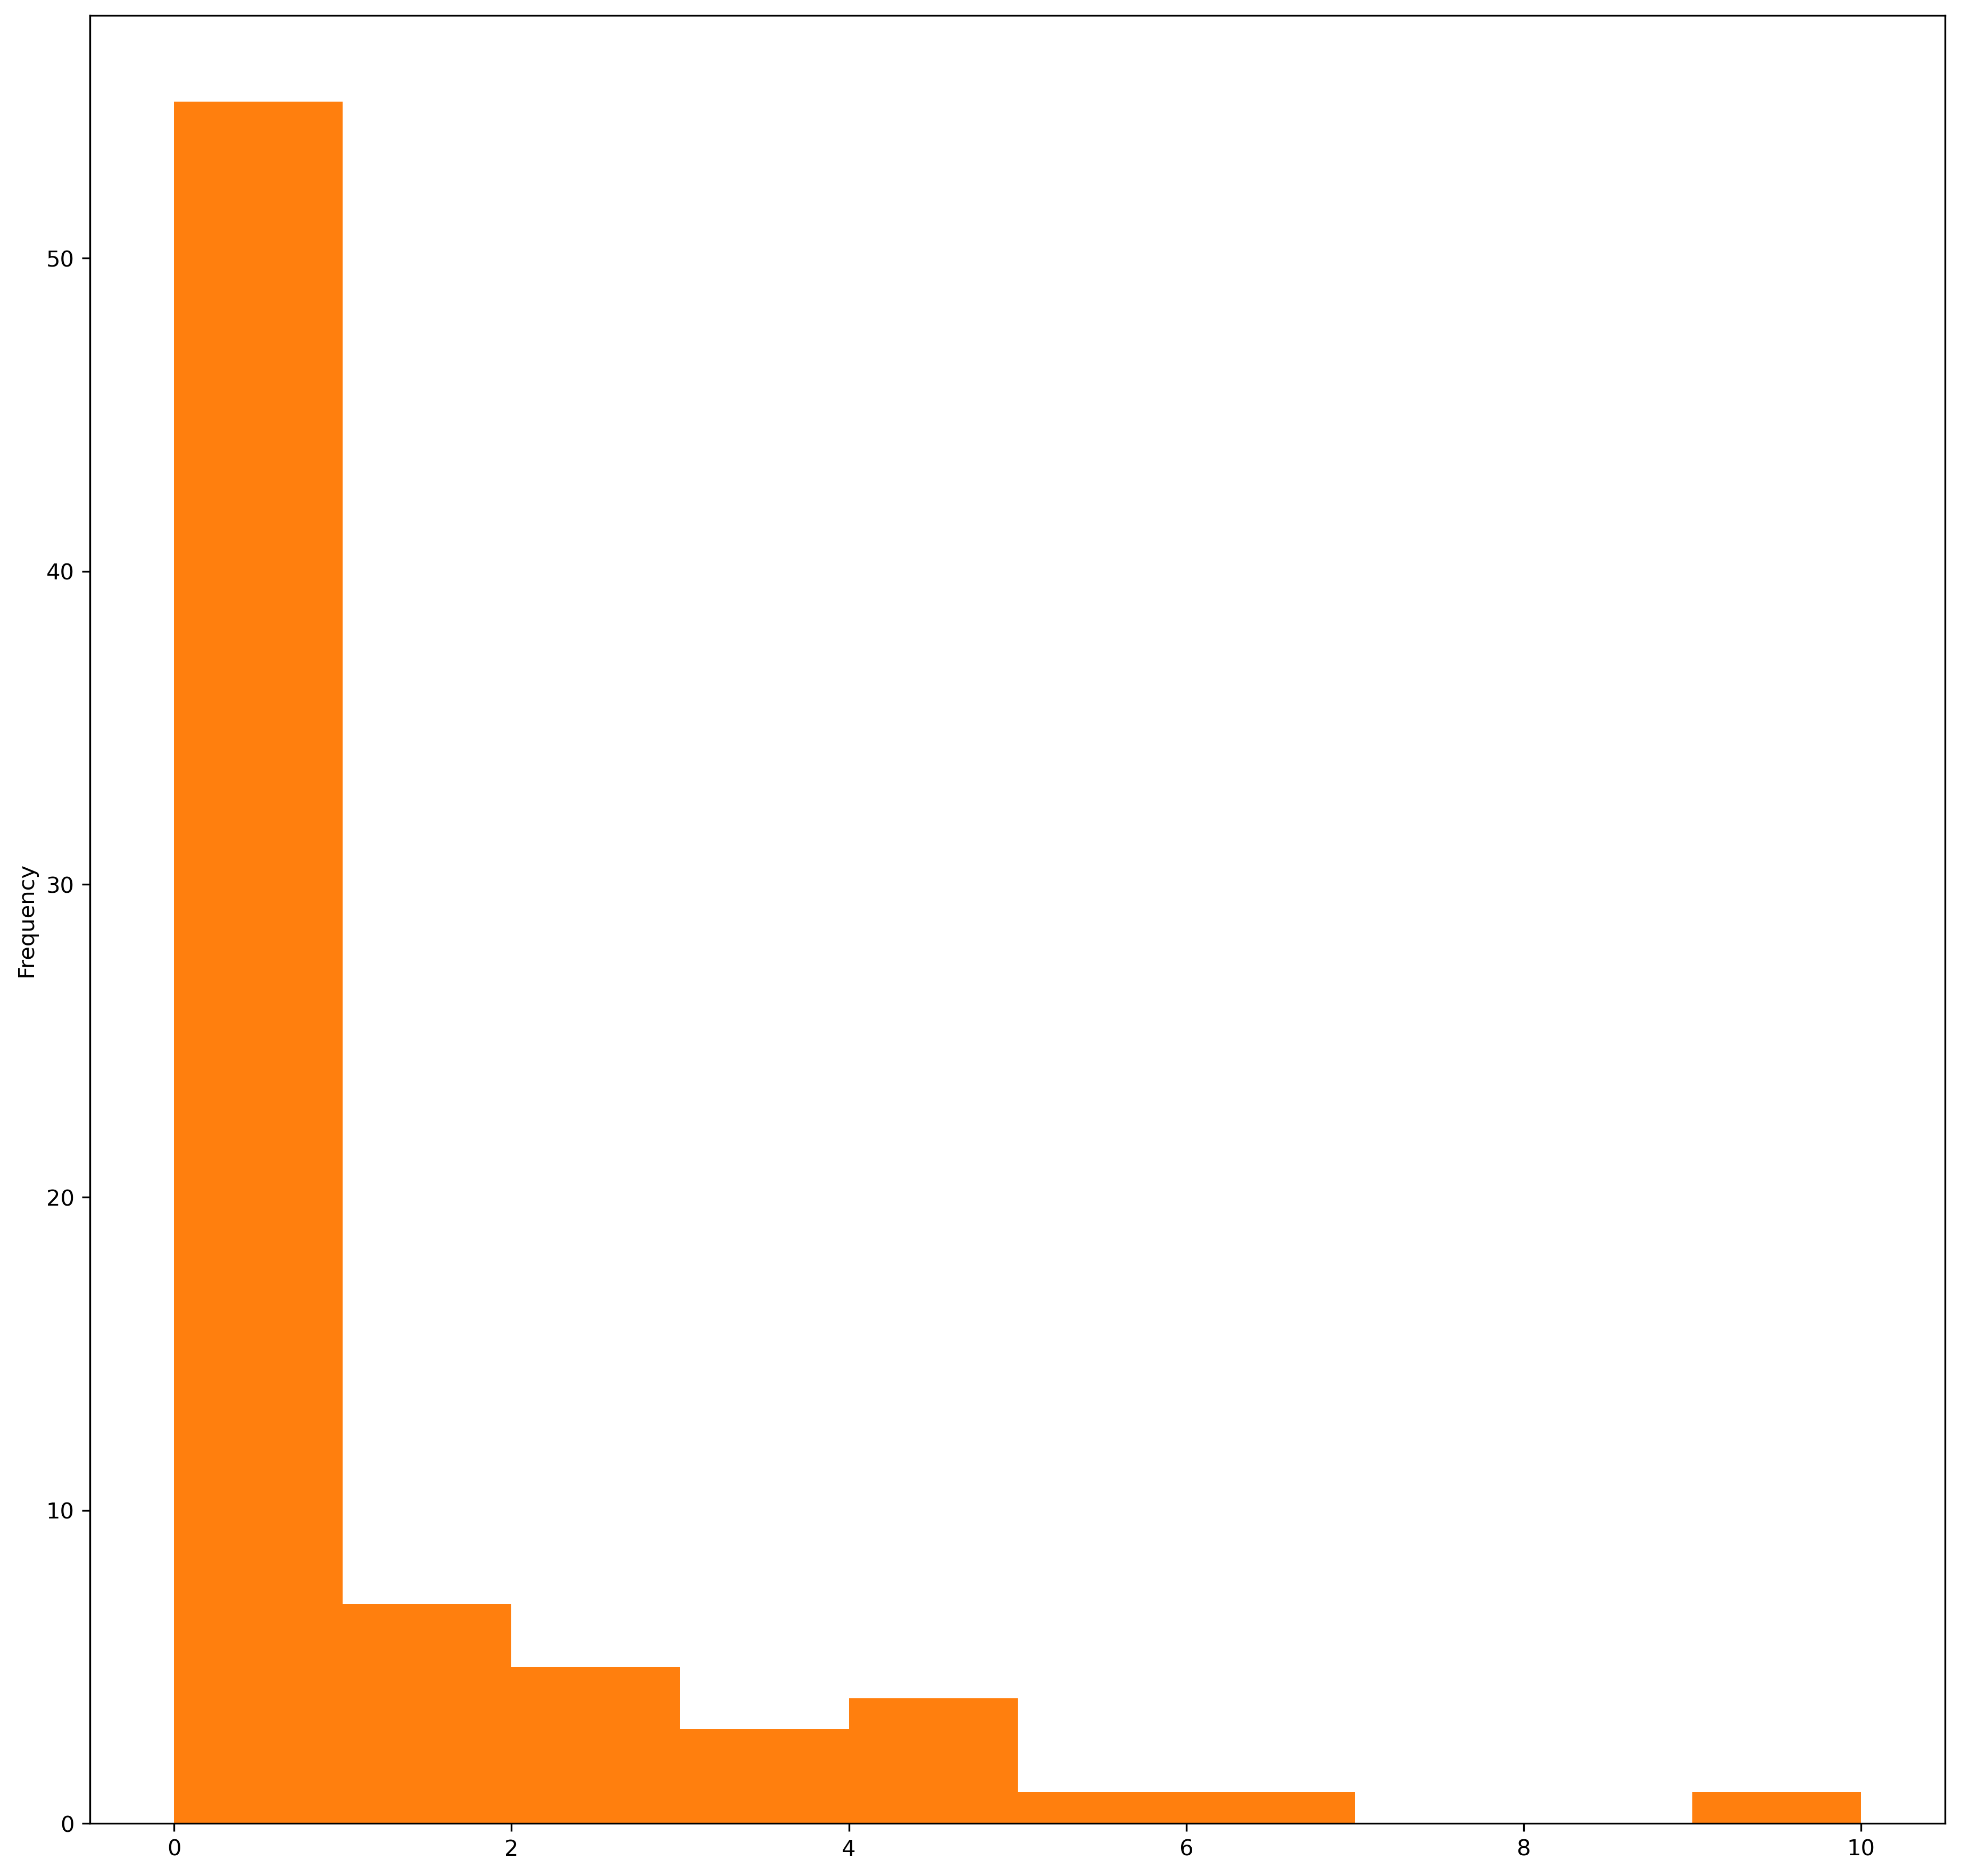

In [197]:
num_consults_df_labeled.groupby('label')['nconsults'].plot(kind='hist')

In [37]:
# look at which departments are being consulted (pick top seven)
top7_consult_df = pd.DataFrame(list(abpain_consult2.ConStopCodeName.value_counts()[:7].index),columns=['ConStopCodeName'])
top7_consult_df

ConStopCodeName
0   GENERAL SURGERY
1               EKG
2     CHART CONSULT
3    UROLOGY CLINIC
4  GASTROENTEROLOGY
5      GI ENDOSCOPY
6        CARDIOLOGY

In [ ]:
c = 0
consult_dept = {}
for PtSSN in abpain_cohort1.PtSSN.unique():
    recs = abpain_consult2[abpain_consult2.PtSSN==PtSSN]
    con = recs.ConStopCodeName
    tmp_vc = pd.merge(con,top7_consult_df,on='ConStopCodeName').ConStopCodeName.value_counts()
    consult_dept[c] = {'PtSSN':PtSSN}
    for code in top7_consult_df.ConStopCodeName:
        if code in tmp_vc:
            consult_dept[c][code] = tmp_vc[code]
        else:
            consult_dept[c][code] = 0
    c = c + 1
consult_dept_df = pd.DataFrame.from_dict(consult_dept,orient='index')
consult_dept_df

In [40]:
consult_dept_df_labeled = pd.merge(consult_dept_df,labels_df,on='PtSSN')

# is any consult significant
for field in consult_dept_df_labeled.columns[2:-1]:
    print(field)
    print(scipy.stats.ttest_ind(consult_dept_df_labeled[consult_dept_df_labeled.label=='MOD'][field],
                                      consult_dept_df_labeled[consult_dept_df_labeled.label=='NoMOD'][field]))

EKG
Ttest_indResult(statistic=1.6175480690538753, pvalue=0.10884850895828647)
CHART CONSULT
Ttest_indResult(statistic=-0.8767192025210492, pvalue=0.38269934543053397)
UROLOGY CLINIC
Ttest_indResult(statistic=nan, pvalue=nan)
GASTROENTEROLOGY
Ttest_indResult(statistic=-0.6498273932558098, pvalue=0.5172645382674323)
GI ENDOSCOPY
Ttest_indResult(statistic=0.6254942727738887, pvalue=0.5330437111232542)
CARDIOLOGY
Ttest_indResult(statistic=nan, pvalue=nan)


# Code for extracting meds

In [254]:
meds = dataset['RxOutpat']

meds.rename(columns={'PatientSSN':'PtSSN'},inplace=True)
meds.PtSSN = meds.PtSSN.astype('int32')
# restrict meds to abpain cohort
abpain_meds1 = pd.merge(meds,abpain_cohort1[['PtSSN','EDStartDateTime','EDEndDateTime']],on='PtSSN')

# restrict meds to abpain cohort within the ED Start and End Times
abpain_meds2 = abpain_meds1[(abpain_meds1.DispensedDate >= abpain_meds1.EDStartDateTime) & 
                                  (abpain_meds1.DispensedDate <= abpain_meds1.EDEndDateTime)].copy()

print(abpain_meds2.shape)

(1603, 15)


In [260]:
# is a drug an antibiotic?

antibiotics_list = ['CIPRO','AMOXI','CEF','CEPH','CLIND','DOXYC','METRONIDA','VANCO']
def is_antibiotic(drug):
    for a in antibiotics_list:
        if drug.find(a)>= 0:
            print(drug)
            return 1
    return 0



In [262]:
vc = abpain_meds2.LocalDrugNameWithDose.value_counts()
[(a,is_antibiotic(a)) for a in list(vc.index) if is_antibiotic(a)]
#abpain_meds2.columns

[('CIPROFLOXACIN HCL 500MG TAB', 1),
 ('AMOXICILLIN 875/CLAV K 125MG TAB', 1),
 ('METRONIDAZOLE 500MG TAB', 1),
 ('METRONIDAZOLE 250MG TAB', 1),
 ('DOXYCYCLINE HYCLATE 100MG TAB', 1),
 ('CEFDINIR 300MG CAP', 1),
 ('CEPHALEXIN 500MG CAP', 1),
 ('DOXYCYCLINE MONOHYDRATE 100MG CAP', 1),
 ('METRONIDAZOLE TAB 500MG', 1),
 ('CEFPODOXIME PROXETIL 200MG TAB', 1),
 ('CLINDAMYCIN HCL 150MG CAP', 1),
 ('AMOXICILLIN 500/CLAV K 125MG TAB', 1),
 ('CIPROFLOXACIN HCL 250MG TAB', 1),
 ('CEPHALEXIN 250MG CAP', 1),
 ('CEFUROXIME AXETIL 500MG TAB', 1),
 ('CEFTRIAXONE SOD INJ 500 MG VIAL', 1),
 ('VANCOMYCIN HCL 125MG CAP', 1),
 ('AMOXICILLIN 875/CLAVUL K 125MG TAB', 1),
 ('VANCOMYCIN 125MG CAP', 1),
 ('CIPROFLOXACIN  500 MG TAB', 1),
 ('CEFPODOXIME 200MG TAB', 1),
 ('CIPROFLOXACIN HCL TAB 250MG', 1),
 ('CLINDAMYCIN HCL 300MG CAP', 1),
 ('VANCOMYCIN HCL 250MG CAP', 1),
 ('CIPROFLOXACIN 500MG TAB ##', 1)]

In [271]:
# for every patient in abpain_cohort check if they were given antibiotics a

abpain_cohort_meds = pd.merge(abpain_cohort,abpain_meds2[['PtSSN','LocalDrugNameWithDose']],on='PtSSN',how='left')

antibiotics = {}
for PtSSN in abpain_cohort.PtSSN:
    recs = abpain_cohort_meds[abpain_cohort_meds.PtSSN==PtSSN]
    antibiotics[PtSSN] = recs.LocalDrugNameWithDose.dropna().apply(is_antibiotic).sum()

antibiotics_df = pd.DataFrame.from_dict(antibiotics,orient='index').reset_index()
antibiotics_df.rename(columns={'index':'PtSSN'},inplace=True)

antibiotics_df_labeled = pd.merge(antibiotics_df,labels_df,on='PtSSN')

# Build models gradually adding more information
- demographics and cohort information alone

In [42]:
abpain_demo.columns

Index(['PtSSN', 'rowid', 'IndexDateTime', 'DOB', 'Gender', 'Ethnicity', 'Race',
       'age', 'new_race'],
      dtype='object')

In [ ]:
cohort_features = ['ed_duration','ed_inp_delta','visits']
demo_features = ['Gender','Ethnicity','age','new_race']

df1 = pd.merge(abpain_cohort1_labeled,abpain_demo_labeled,on=['PtSSN','label'])[['PtSSN','label'] + cohort_features + demo_features]
df1.head()

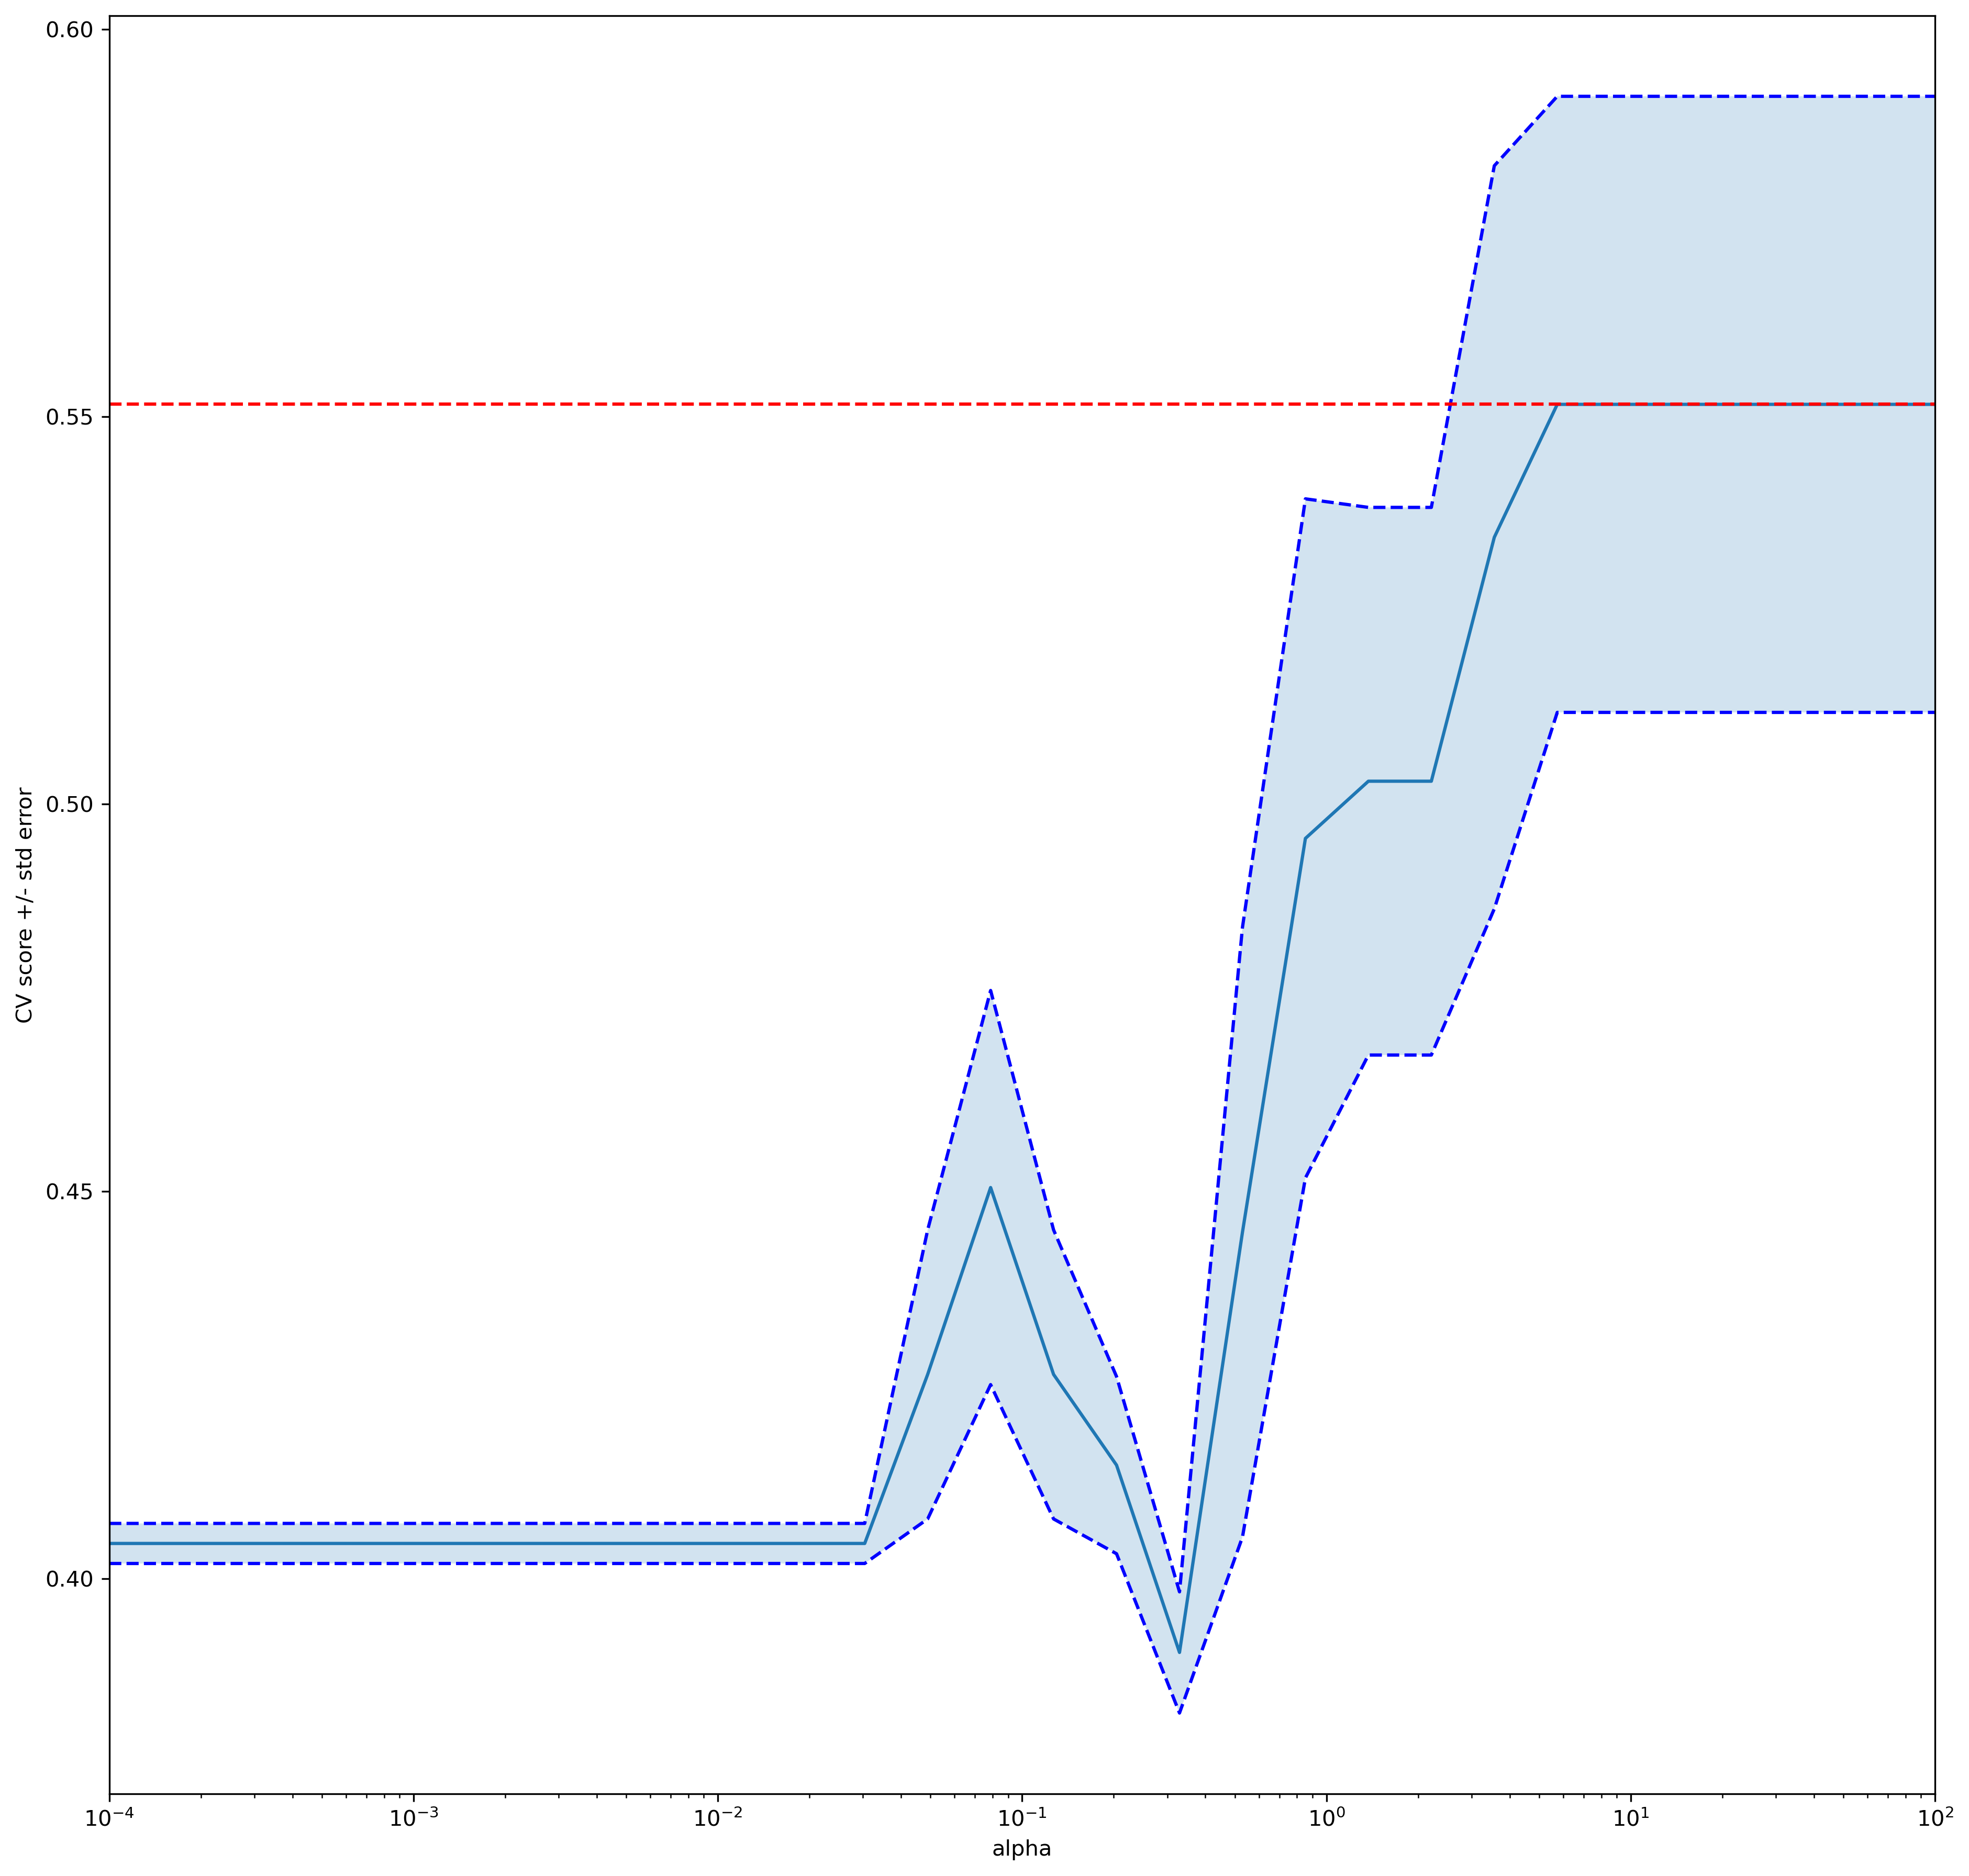

In [167]:
# code Gender, Ethnicity, new_race using get_dummies
tmp1 = pd.get_dummies(df1[['new_race']])
tmp2 = pd.DataFrame(df1['Gender'].apply(lambda x: 1 if x=='M' else 0))
tmp3 = pd.DataFrame(df1['Ethnicity'].apply(lambda x: 1 if x=='HISPANIC OR LATINO' else 0))
df_cohort_demo = pd.concat([df1[['PtSSN','label','age','ed_duration','ed_inp_delta','visits']],tmp1,tmp2,tmp3],axis=1)


X = df_cohort_demo[df_cohort_demo.columns[2:]]
y = np.array([1 if x=='MOD' else 0 for x in df_cohort_demo['label']])


clf = tune_model(X,y)

In [168]:
clf.best_params_['C']

5.736152510448681

(131, 11) (131,)
AUC =  0.5489560639070443 0.09991333034826035
F1 =  0.5515665848913602 0.08891528240373396
Accuracy =  0.68005698005698 0.06252636394952509
Confusion matrix:
[[84  5]
 [29 13]]
11  features chosen by L1 model.


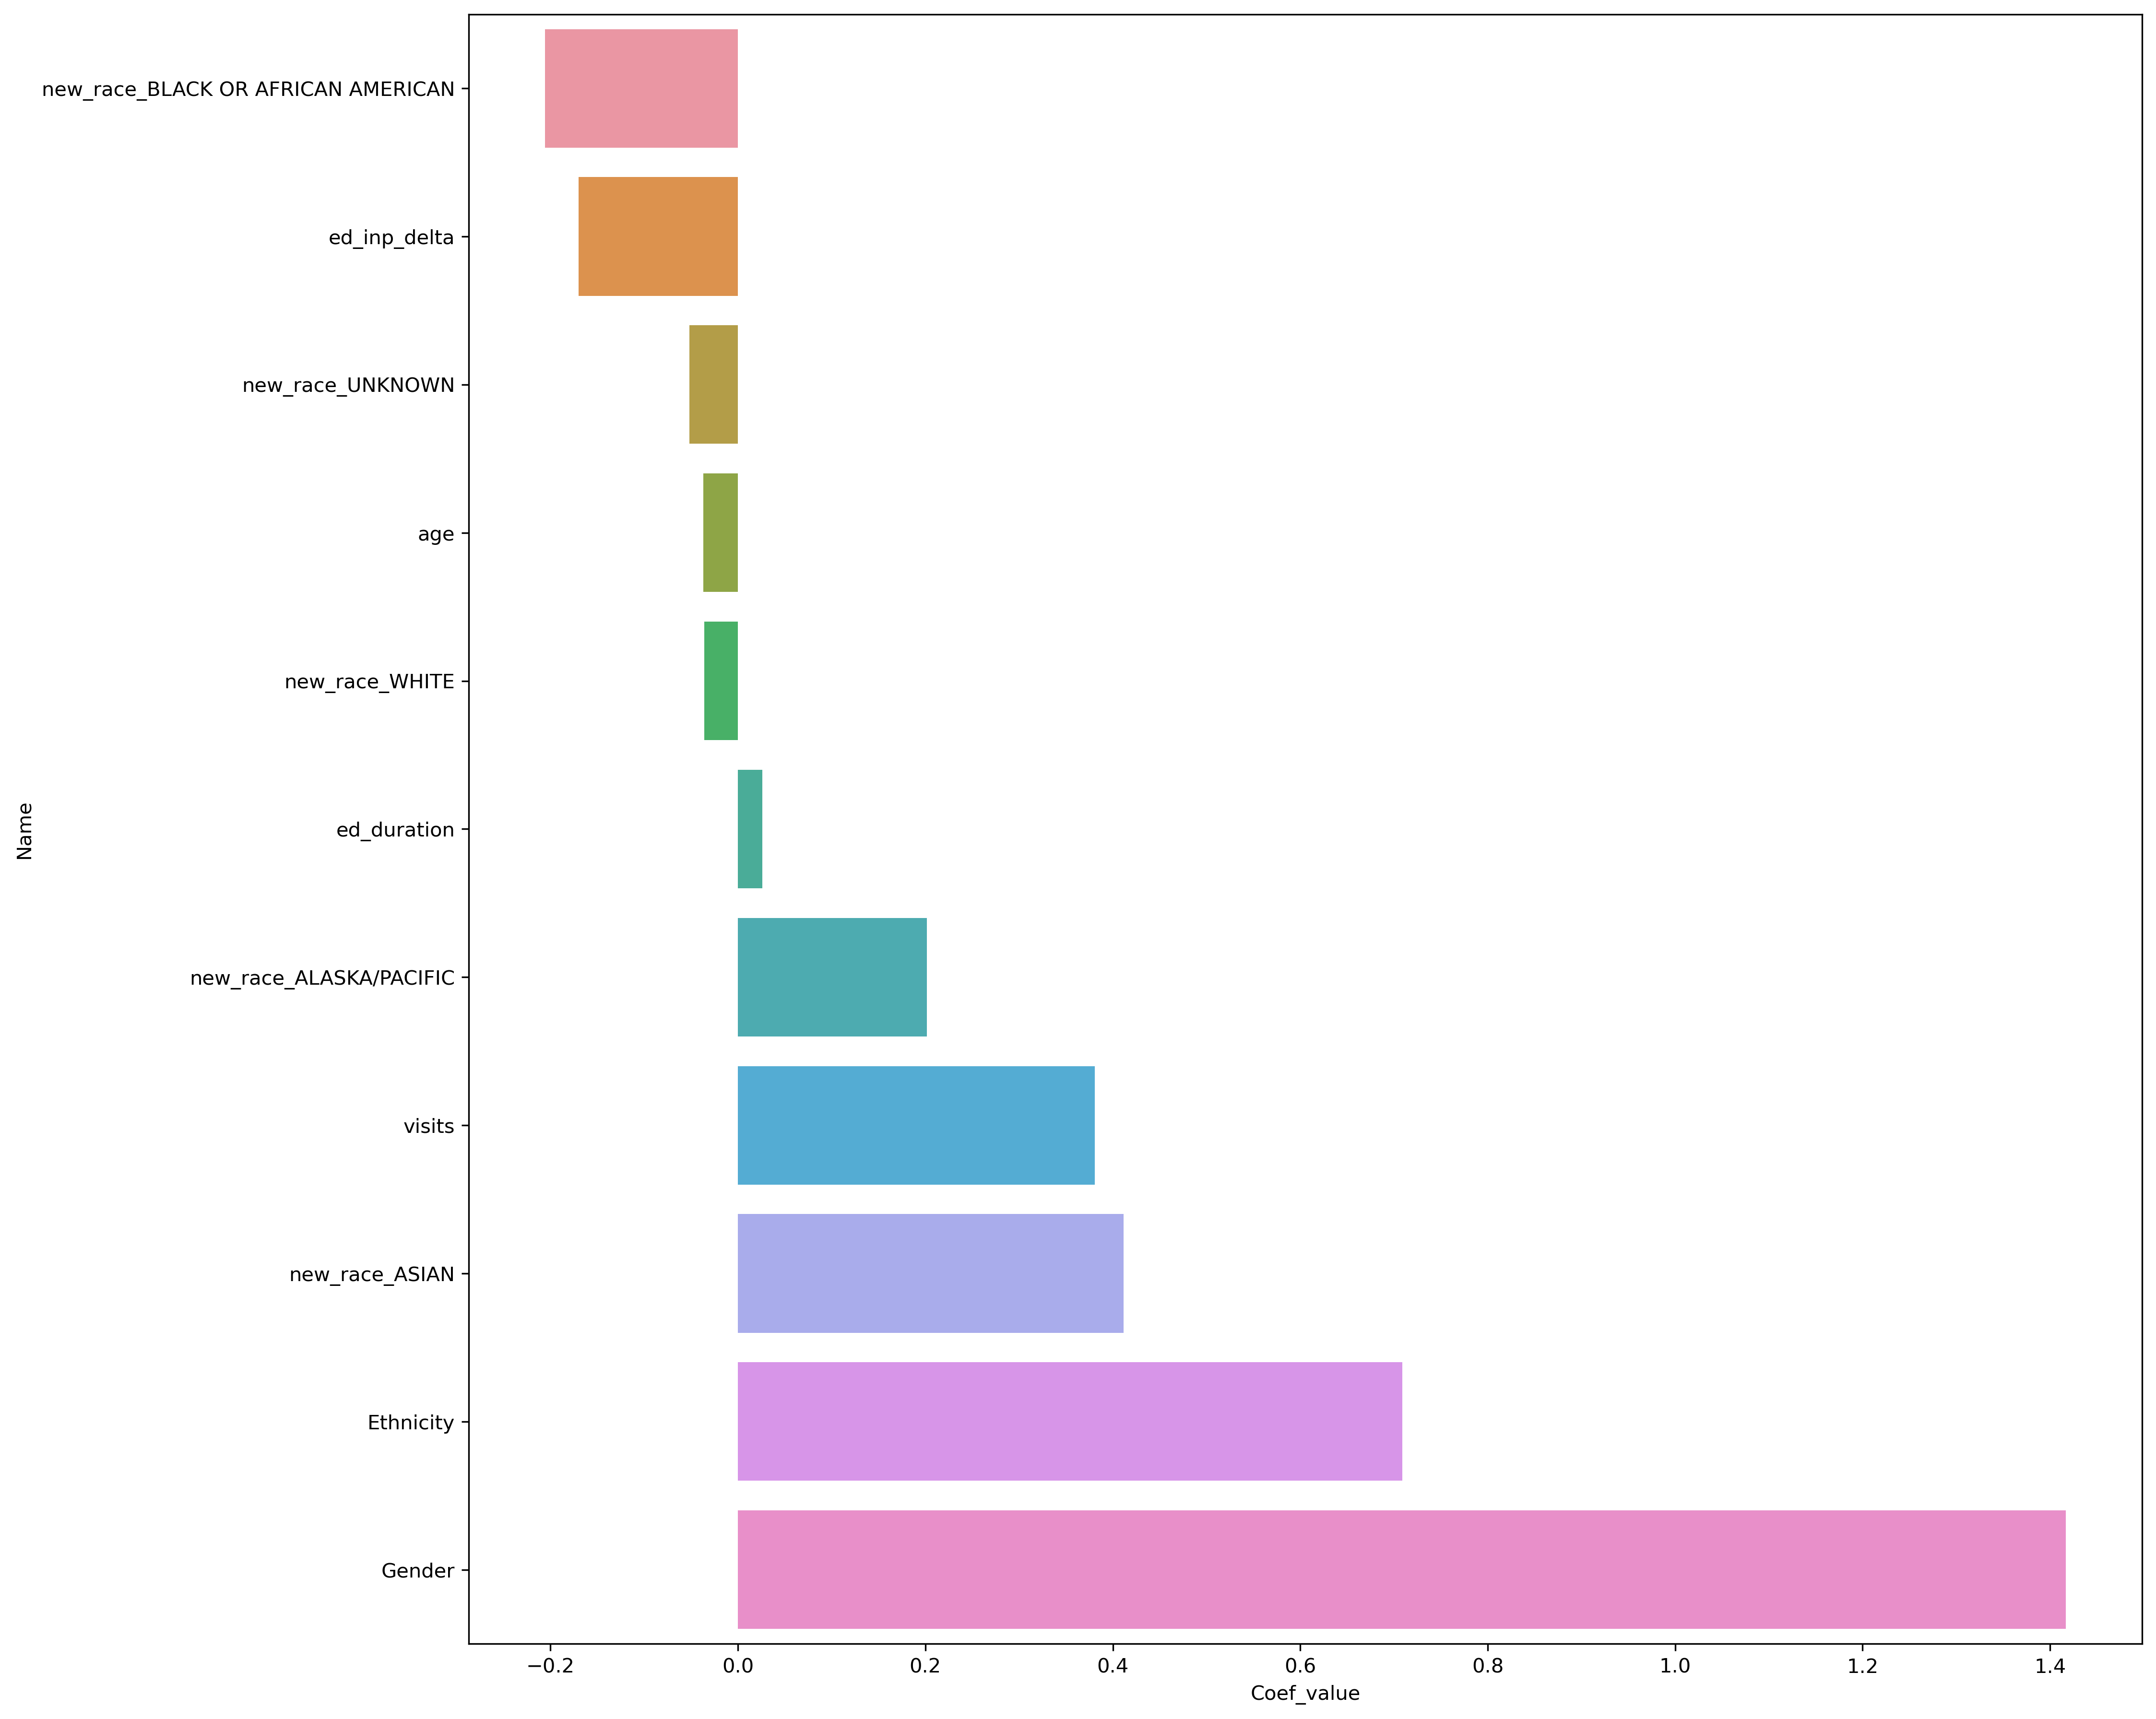

In [169]:
clf,select_feats = build_L1_model(X,y,clf.best_params_['C'])
visualize_model(clf,select_feats)

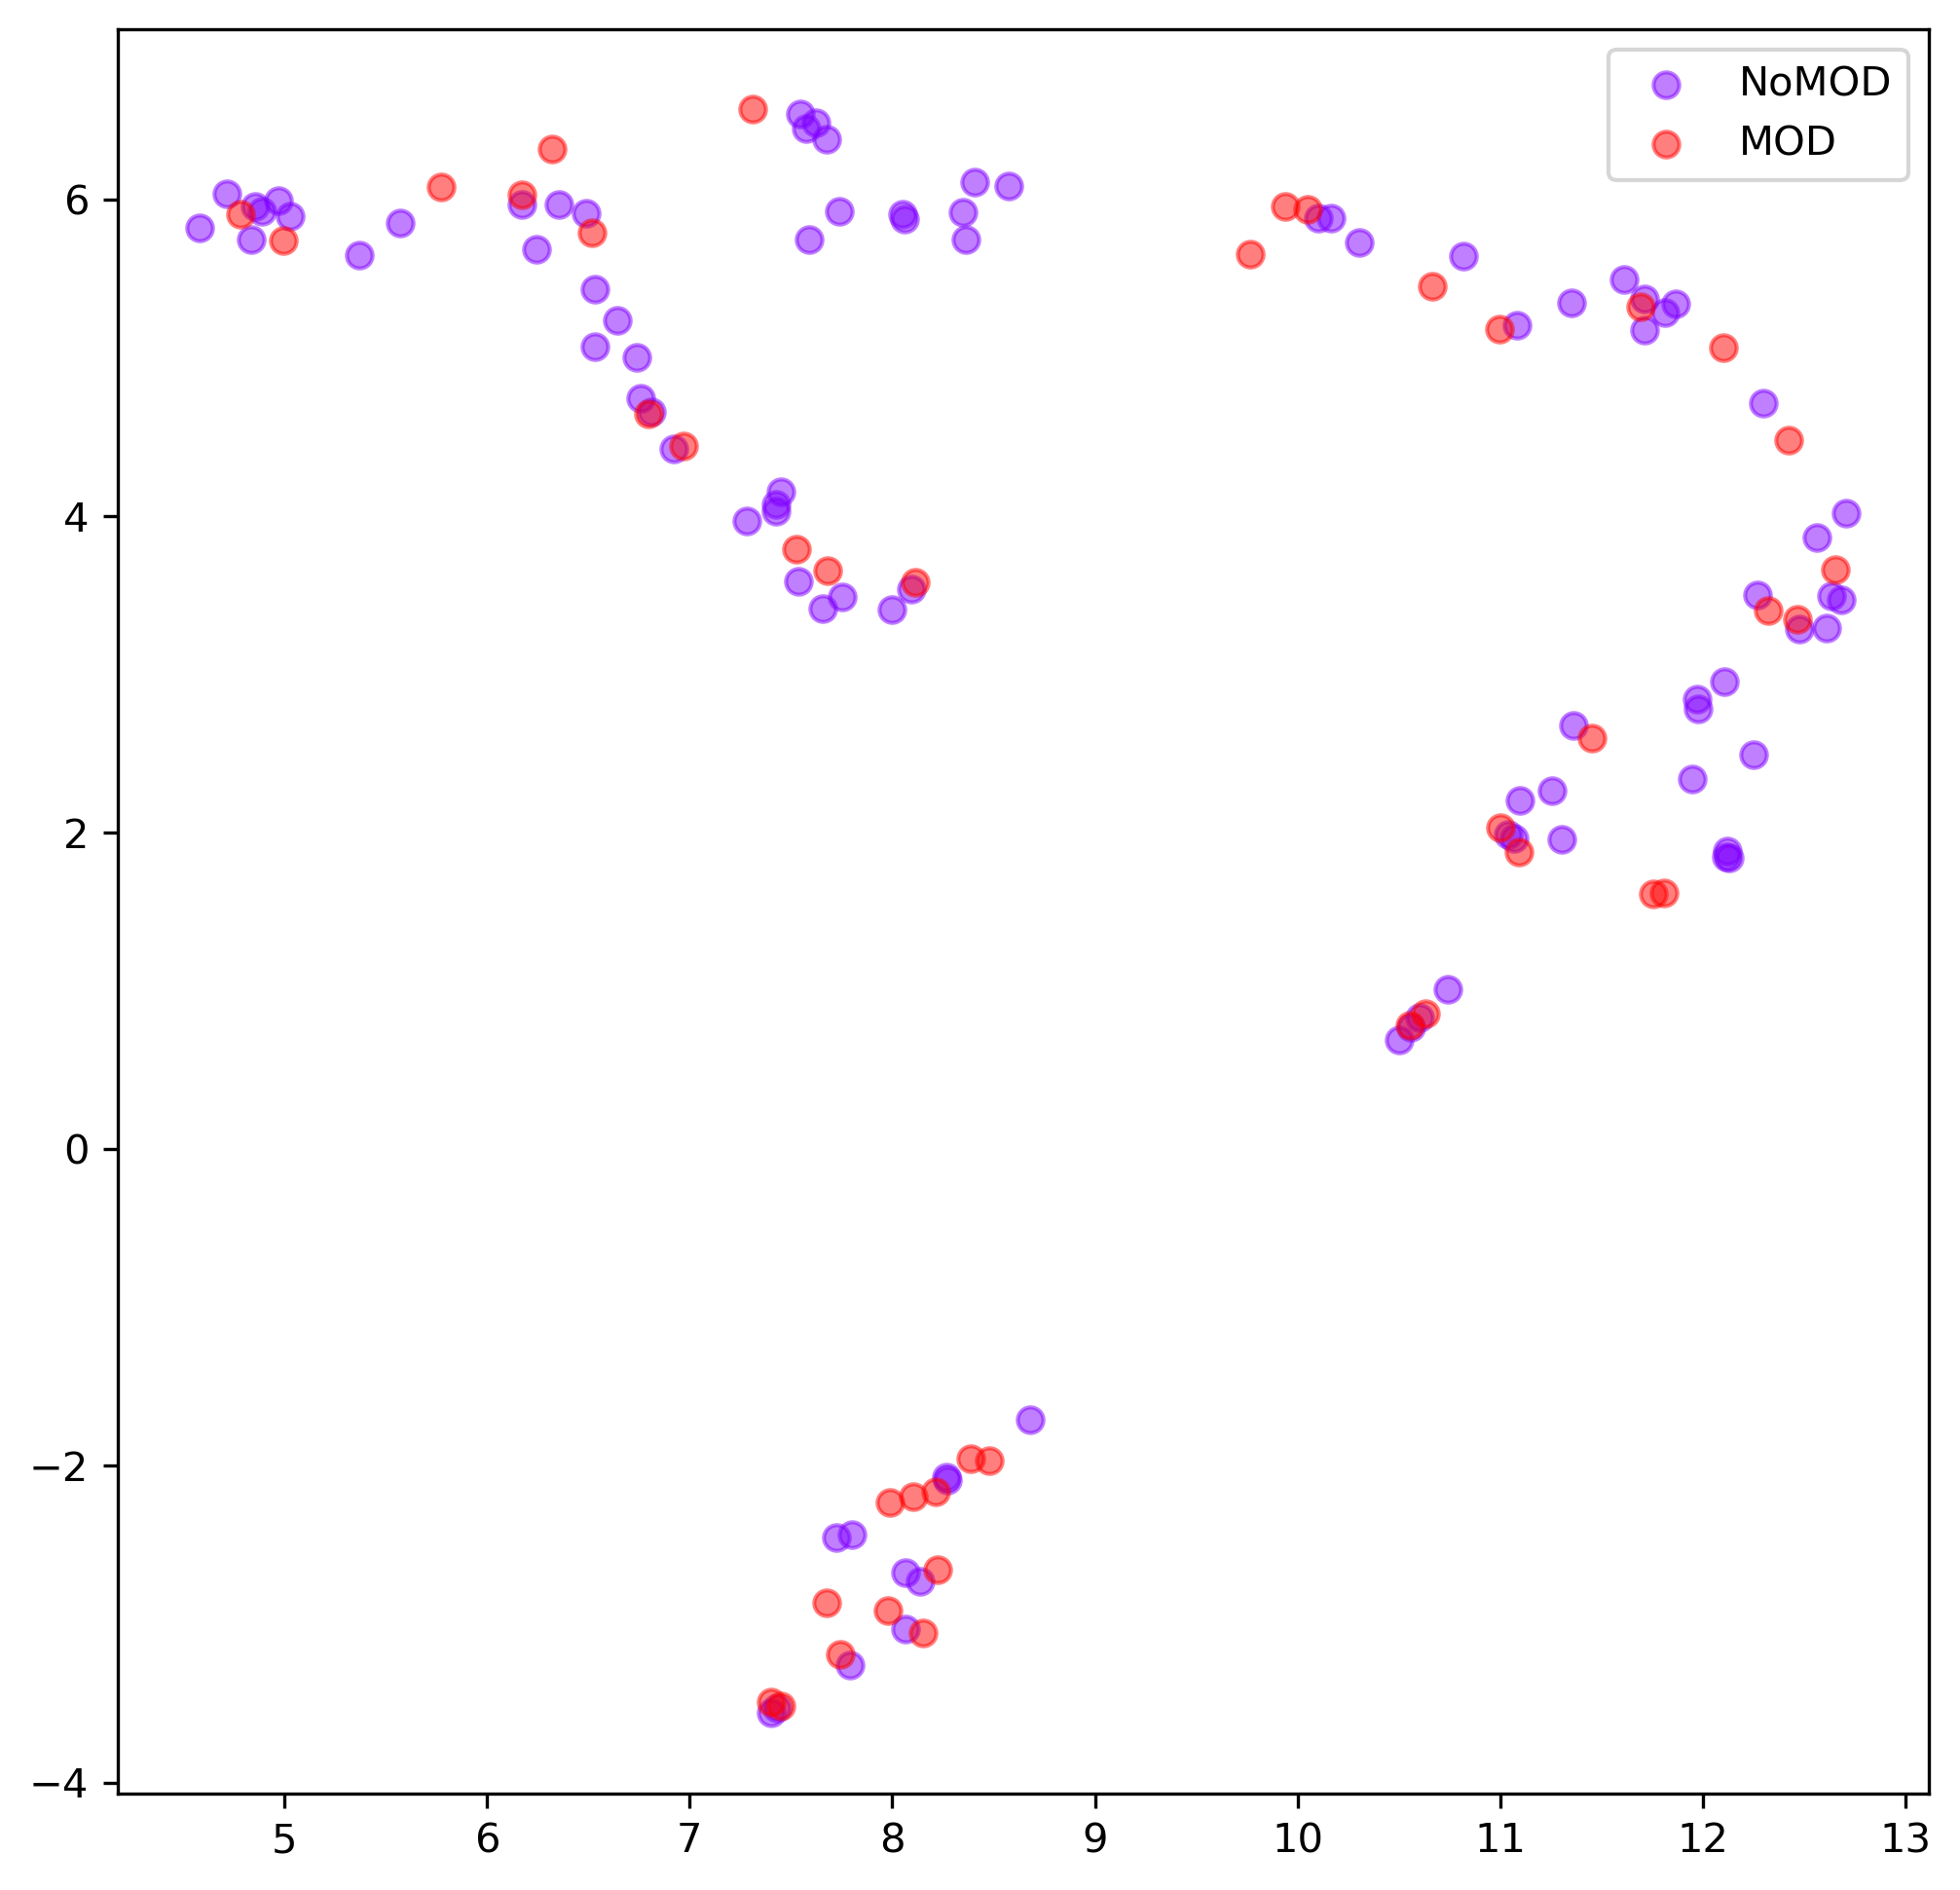

In [170]:
# UMAP visualization with just the selected features
umap_plot_label(X[select_feats],y,1,7,['NoMOD','MOD']);

In [291]:
# which labs are worthy of addition? Use those for which we have the fewest missing values.
labnames = ['wbc','glucose','sodium','potassium','calcium','lactate','chloride','bun','creat','troponin',
           'co2','ast','alt','alkphos','lipase','amylase','urine','albumin']
goodlabs = []
for lab in labnames:
    missing = eval(lab+'_df_labeled').value.isna().sum()
    print(missing,lab)
    if missing < 24:
        goodlabs.append(lab)
        
print(goodlabs)

12 wbc
12 glucose
7 sodium
9 potassium
12 calcium
55 lactate
7 chloride
74 bun
8 creat
92 troponin
100 co2
54 ast
56 alt
25 alkphos
22 lipase
74 amylase
92 urine
23 albumin
['wbc', 'glucose', 'sodium', 'potassium', 'calcium', 'chloride', 'creat', 'lipase', 'albumin']


In [195]:
# for labs that have lots of missing values; use a boolean to indicate whether test was done at all 
# at any of the visits.
boolean_labs = ['lactate','troponin','amylase','urine']
boolean_labs_df = pd.DataFrame(labels_df[['PtSSN']])
for lab in boolean_labs:
    tmp = eval(lab + '_df_labeled')
    vals = pd.DataFrame(tmp.groupby('PtSSN')['value'].agg('count')).reset_index()
    vals.columns=['PtSSN',lab+'_count']
    boolean_labs_df = pd.merge(boolean_labs_df,vals,on='PtSSN')

In [292]:
# now add lab work to the cohort+demo information
# simply consider sodium, potassium, chloride, troponin, amylase (drop lasttwo, too many NaNs)

# when there are multiple lab values for a patient, take the max and min

# take only those labs that pass the p-value test (add wbc for checking SIRS)
goodlabs = ['sodium','potassium','chloride','creat','wbc','albumin']
goodlabs_df = pd.DataFrame(labels_df[['PtSSN']])
for lab in goodlabs:
    tmp = eval(lab + '_df_labeled')
    lmin = pd.DataFrame(tmp.groupby('PtSSN')['value'].agg('min')).reset_index()
    lmin.columns=['PtSSN',lab+'_min']
    lmax = pd.DataFrame(tmp.groupby('PtSSN')['value'].agg('max')).reset_index()
    lmax.columns=['PtSSN',lab+'_max']
    ldf = pd.merge(lmin,lmax,on='PtSSN')
    goodlabs_df = pd.merge(goodlabs_df,ldf,on='PtSSN')
    
lab_features = [l+'_min' for l in goodlabs] + [l+'_max' for l in goodlabs]

In [293]:
df_cohort_demo_labs1 = pd.merge(df_cohort_demo,goodlabs_df,on='PtSSN')
df_cohort_demo_labs = pd.merge(df_cohort_demo_labs1,boolean_labs_df,on='PtSSN')
df_cohort_demo_labs.shape

(131, 29)

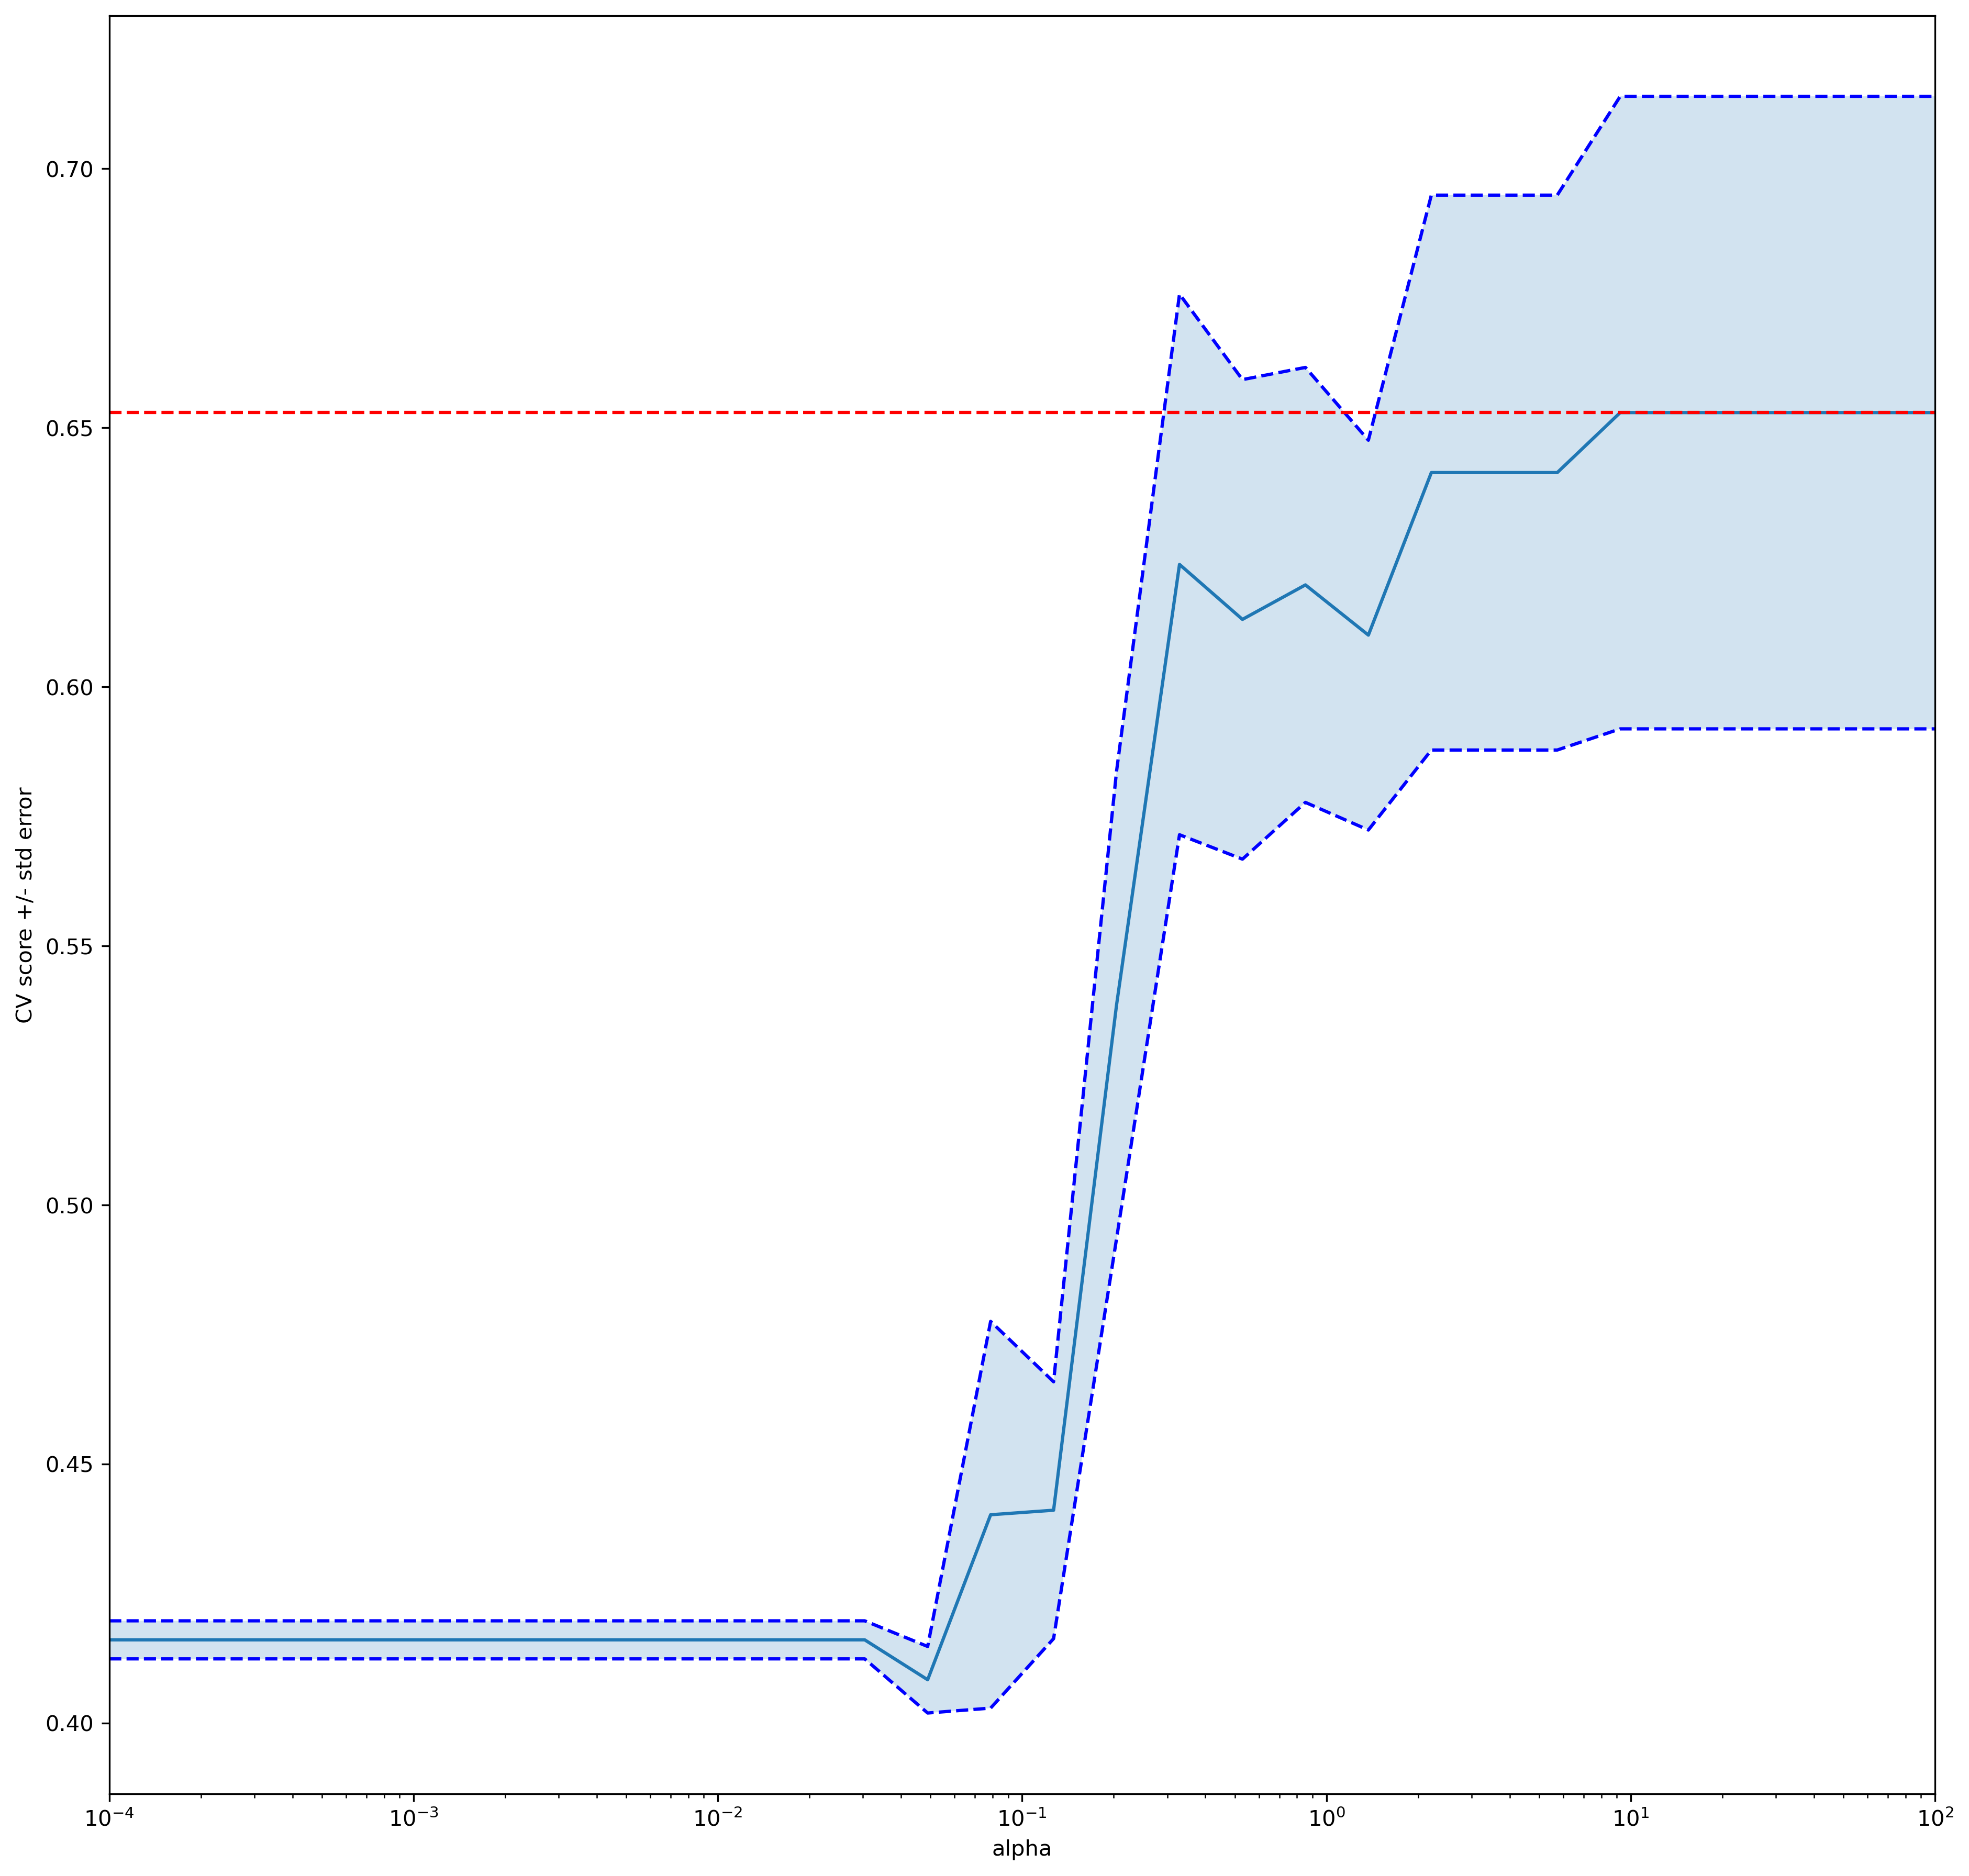

In [294]:
df2_clean = df_cohort_demo_labs.dropna()
X = df2_clean[df2_clean.columns[2:]]
y = np.array([1 if x=='MOD' else 0 for x in df2_clean['label']])

clf = tune_model(X,y)

(94, 27) (94,)
AUC =  0.7162637362637362 0.17030085226299121
F1 =  0.6529450785485269 0.13650009628803333
Accuracy =  0.7461988304093568 0.10038058966608342
Confusion matrix:
[[65  2]
 [15 12]]
26  features chosen by L1 model.


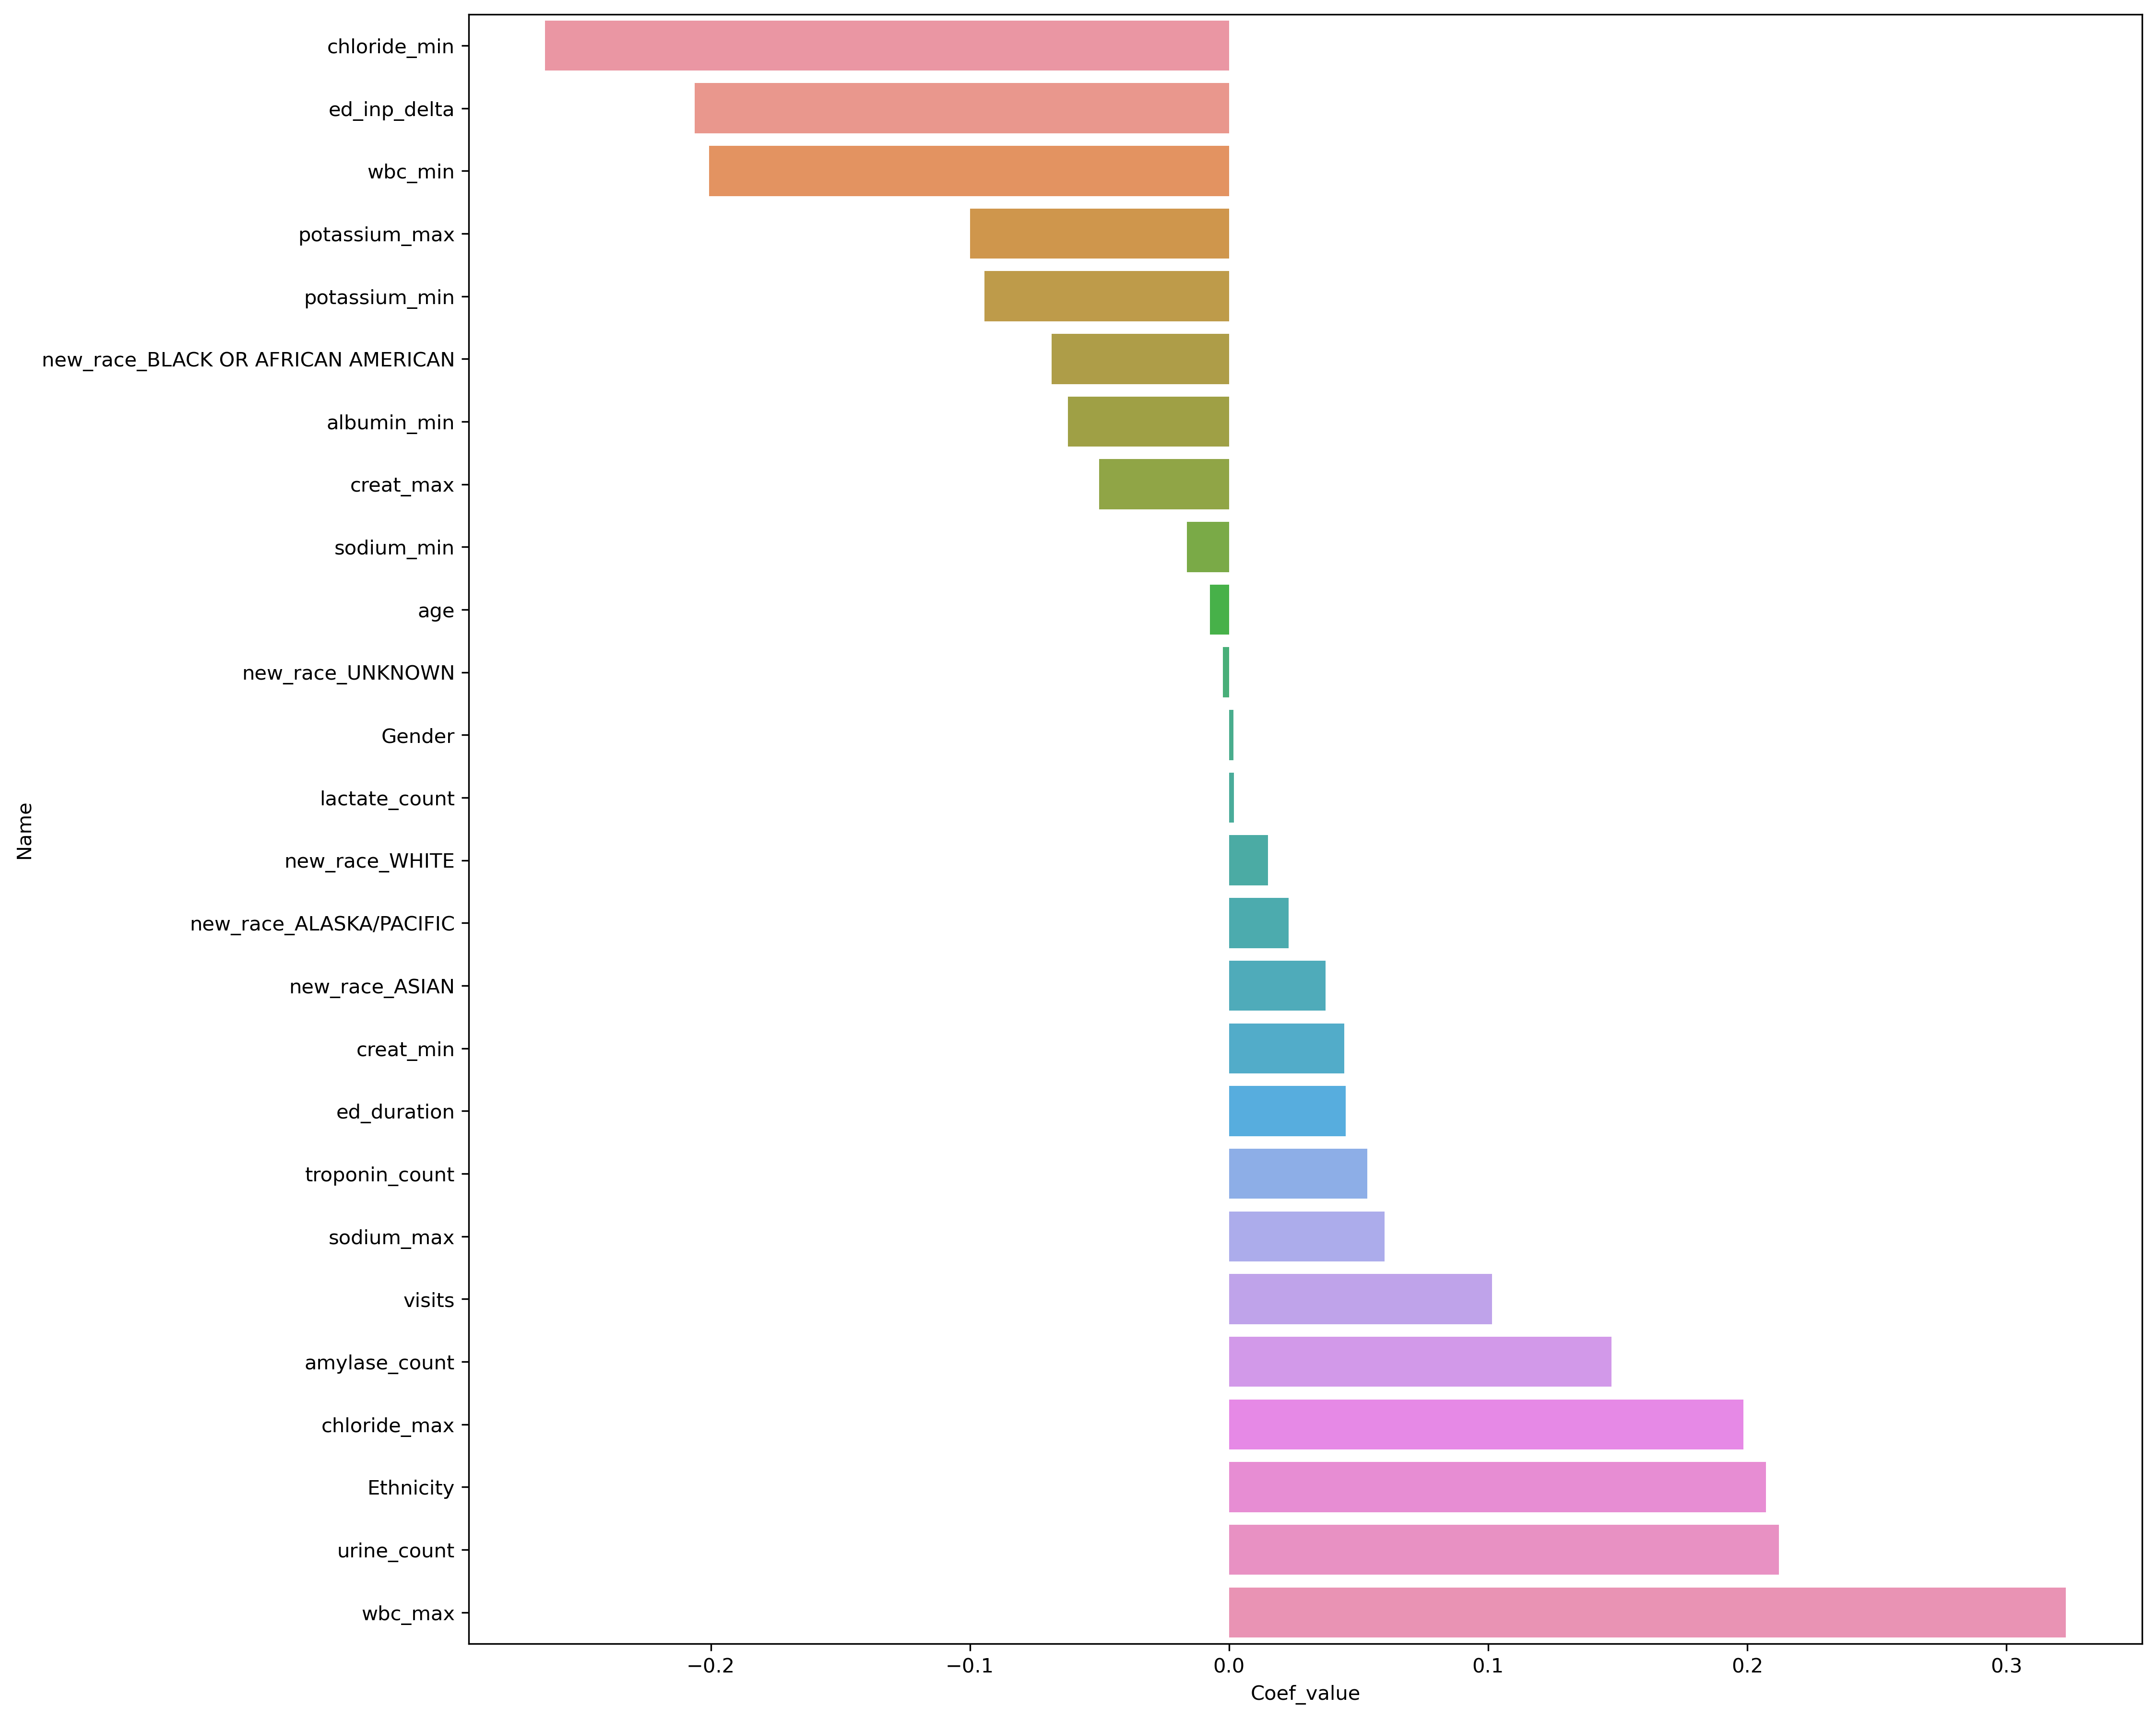

In [295]:
clf,select_feats = build_L1_model(X,y,clf.best_params_['C'])
visualize_model(clf,select_feats)

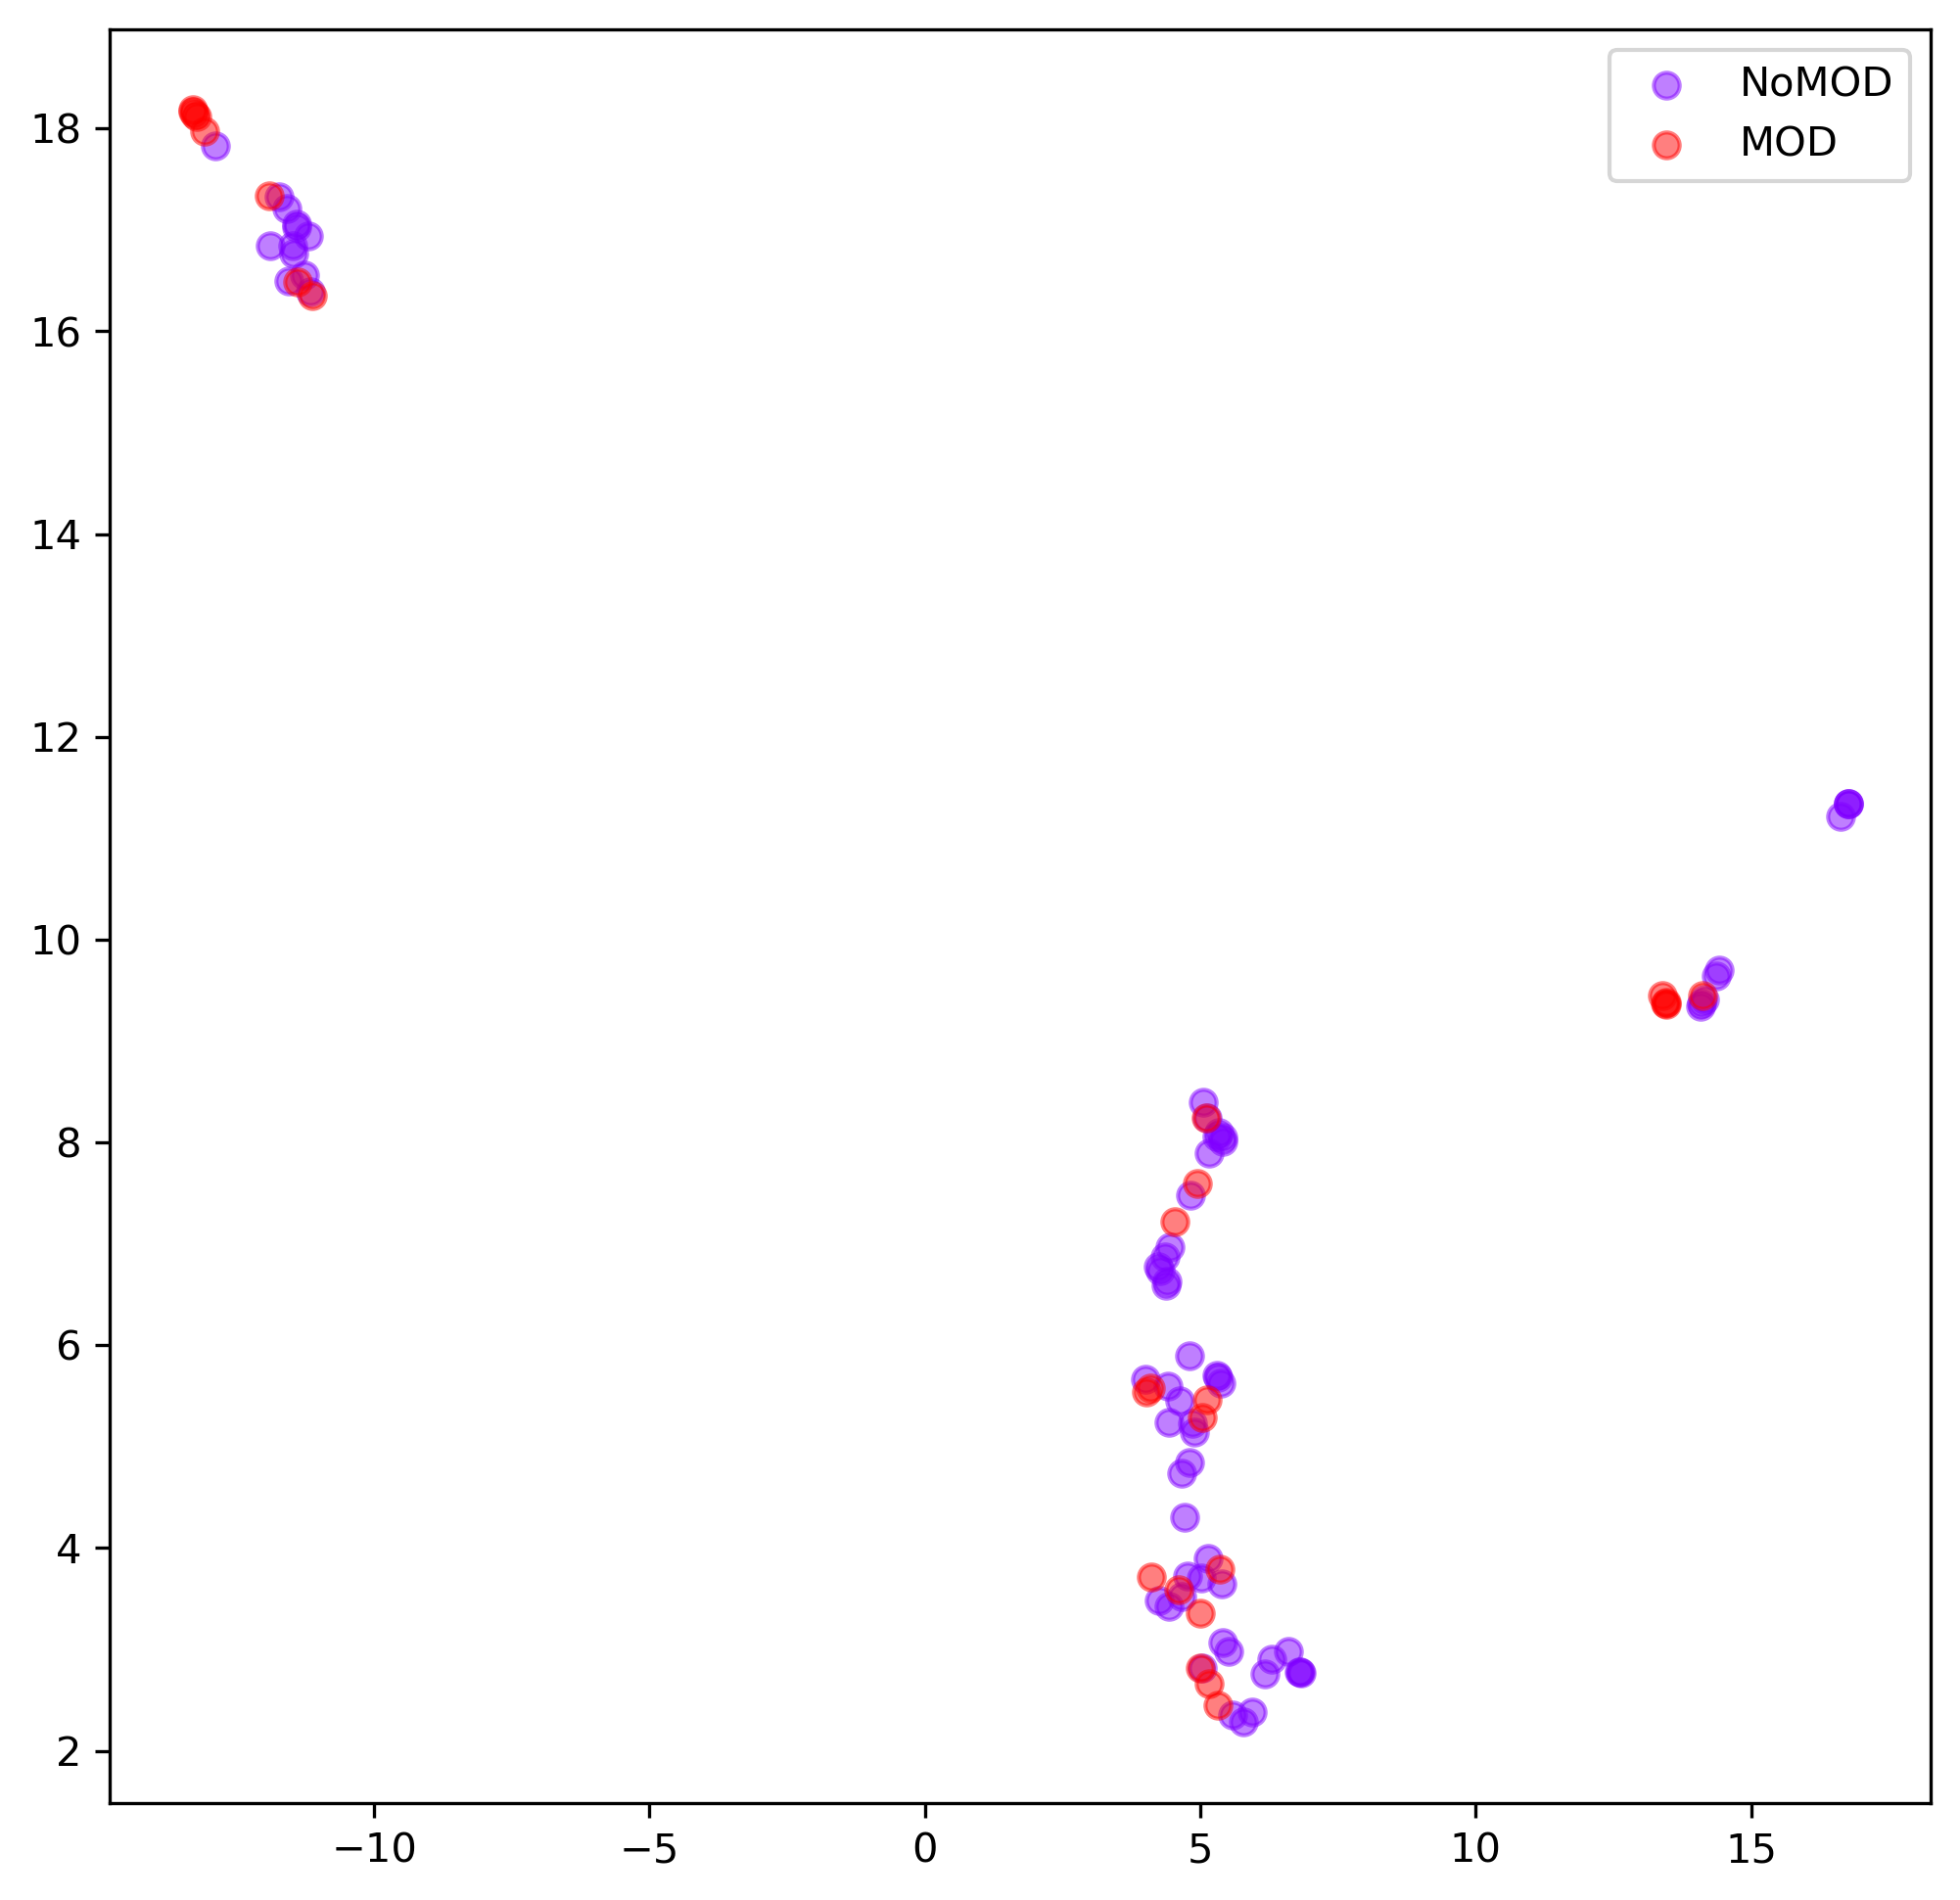

In [296]:
# UMAP visualization with just the selected features
umap_plot_label(X[select_feats],y,2,7,['NoMOD','MOD']);

In [ ]:
clean_vitals_df_labeled.head()

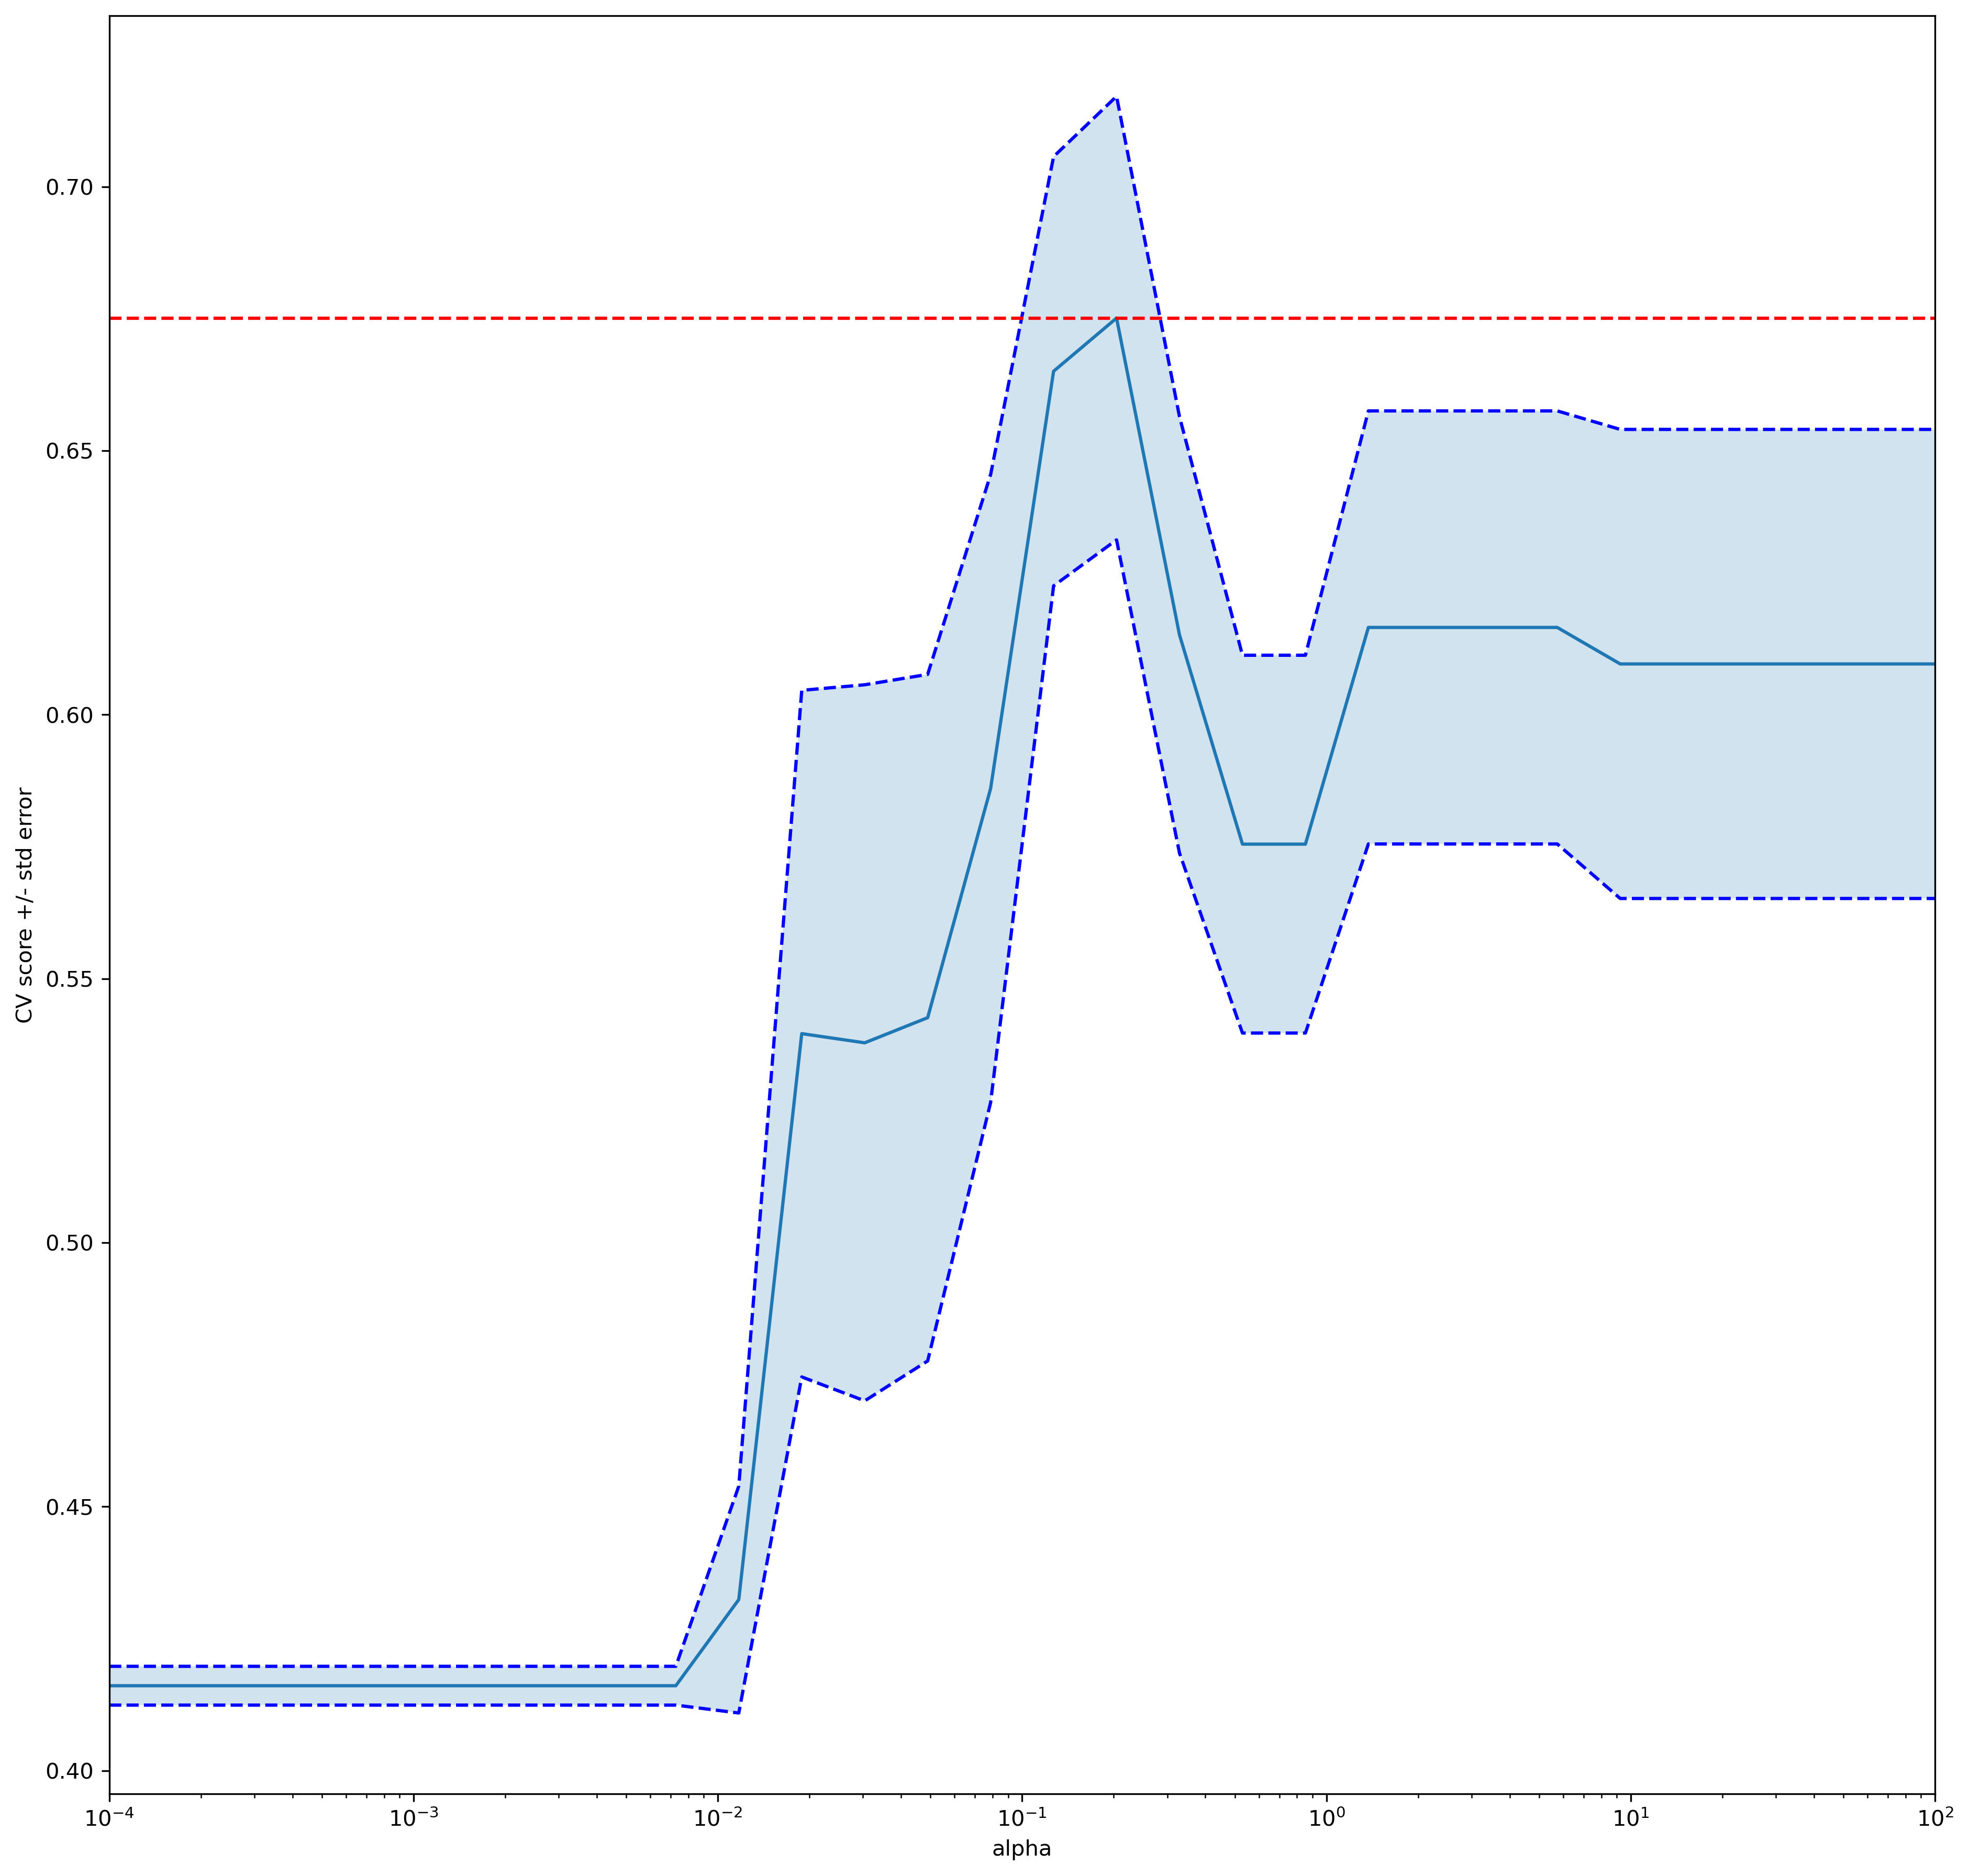

In [297]:
# now take df2_clean and add vitals data
vitals_cols = ['PULSE','TEMPERATURE','SBP','DBP','RESPIRATION']
df3 = pd.merge(df2_clean,clean_vitals_df_labeled[['PtSSN','label'] + vitals_cols],on=['PtSSN','label'])
clean_df3 = df3.dropna()

X = clean_df3[clean_df3.columns[2:]]
y = np.array([1 if x=='MOD' else 0 for x in clean_df3['label']])

clf = tune_model(X,y)

(94, 32) (94,)
AUC =  0.7340659340659341 0.10960181964594261
F1 =  0.6751012780323127 0.09392666288419688
Accuracy =  0.7660818713450291 0.05295546864407845
Confusion matrix:
[[63  4]
 [14 13]]
13  features chosen by L1 model.


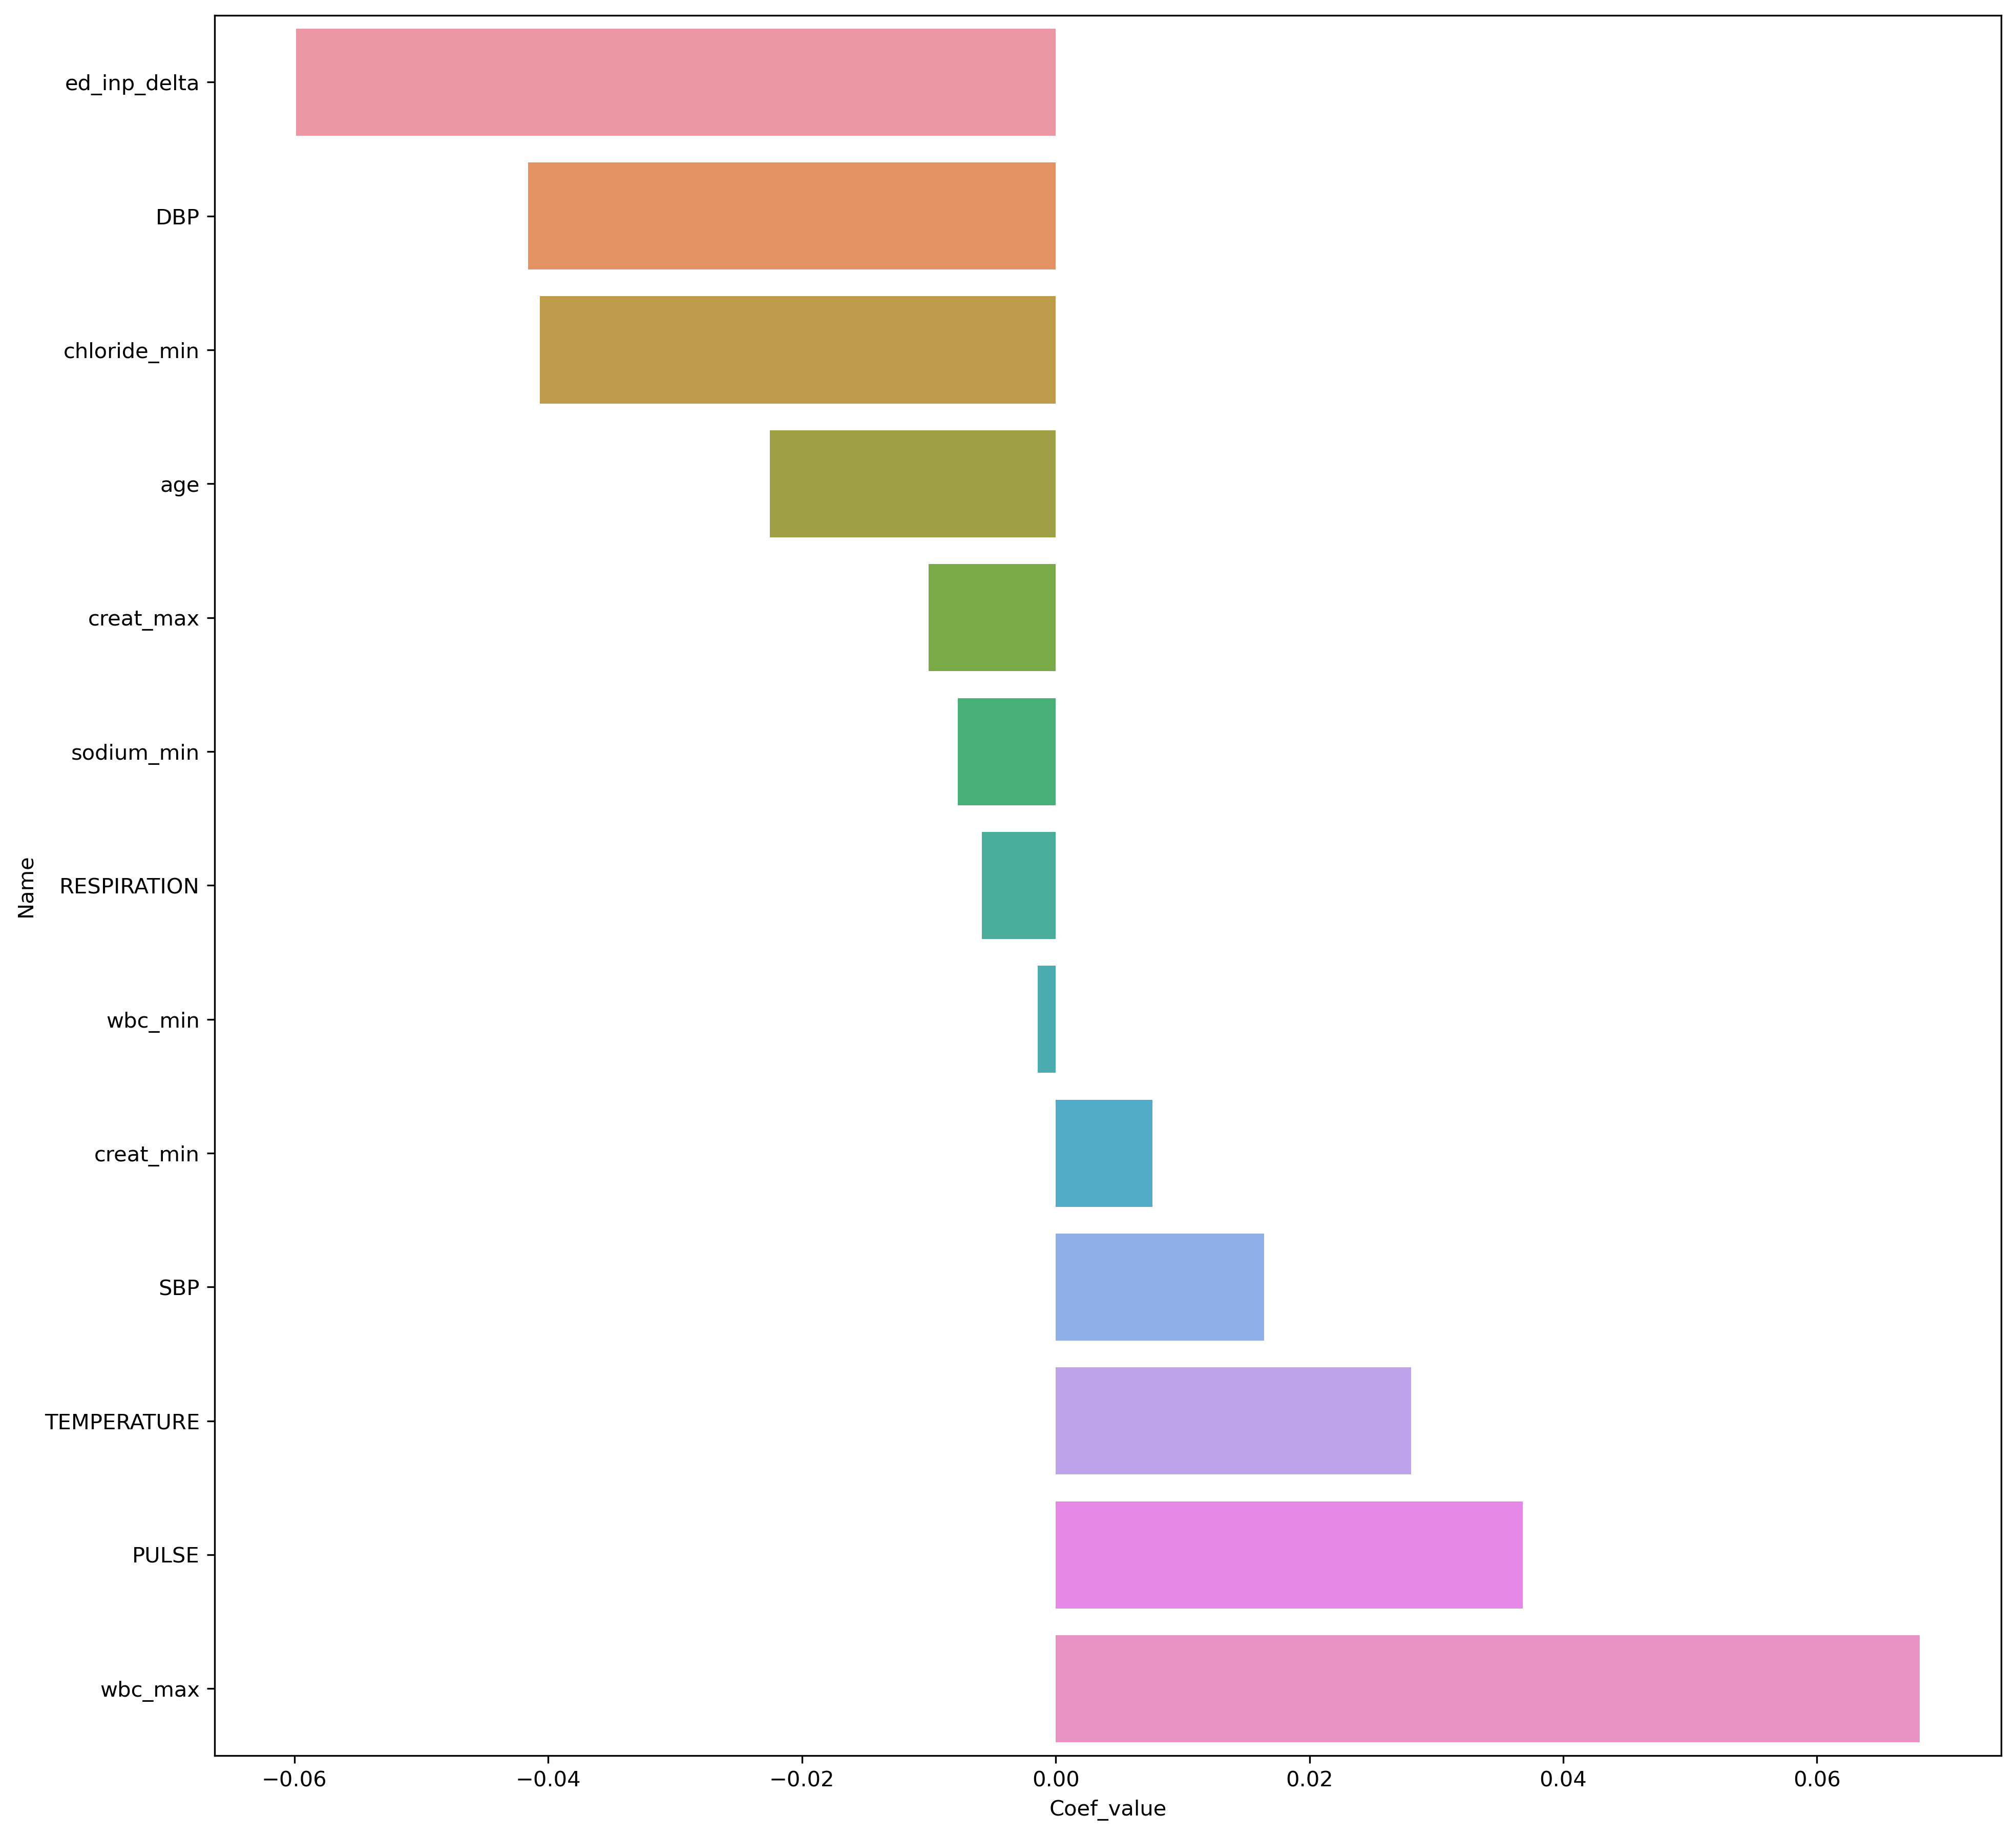

In [298]:
clf,select_feats = build_L1_model(X,y,clf.best_params_['C'])
visualize_model(clf,select_feats)

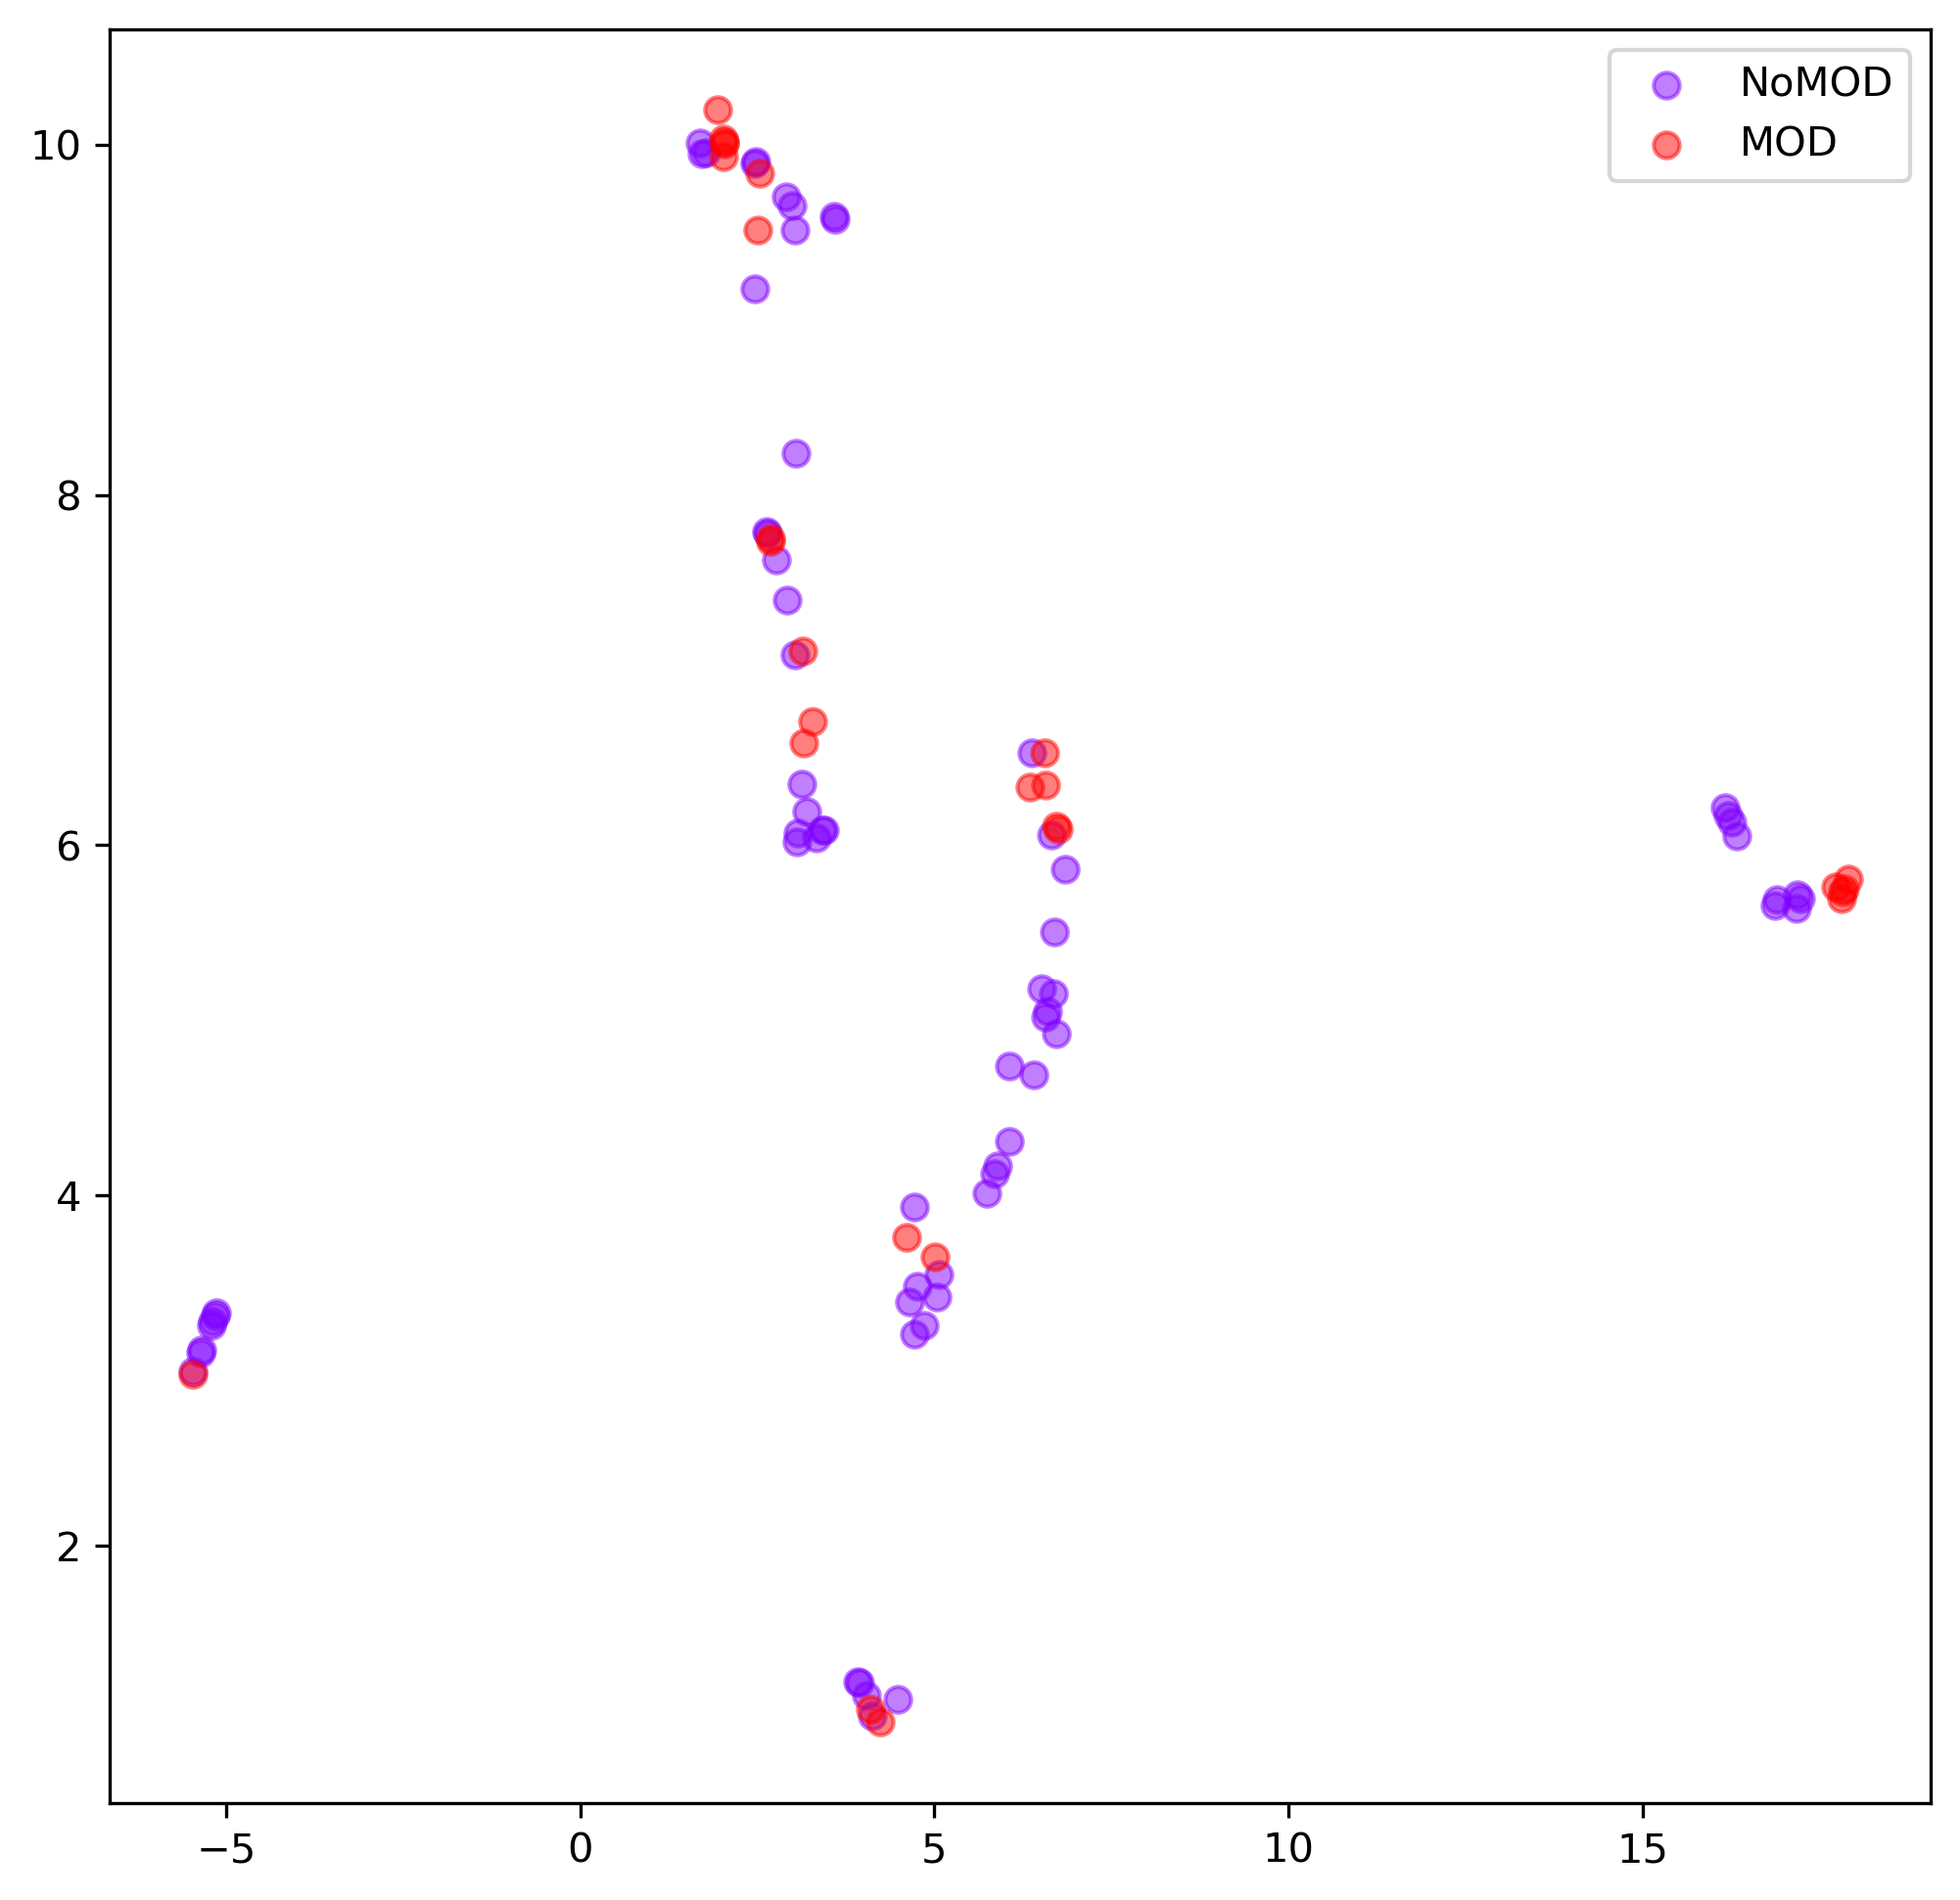

In [299]:
u = umap_plot_label(X[select_feats],y,1,7,['NoMOD','MOD']);

Cluster  1
NoMOD    13
MOD       2
Name: label, dtype: int64
Cluster  2
NoMOD    9
MOD      5
Name: label, dtype: int64
Cluster  3
NoMOD    15
MOD       3
Name: label, dtype: int64
Cluster  4
NoMOD    5
Name: label, dtype: int64
Cluster  5
NoMOD    28
MOD       7
Name: label, dtype: int64
Cluster  6
MOD      11
NoMOD    10
Name: label, dtype: int64
Cluster  7
MOD    4
Name: label, dtype: int64
Cluster  8
MOD      6
NoMOD    4
Name: label, dtype: int64


KMeans()

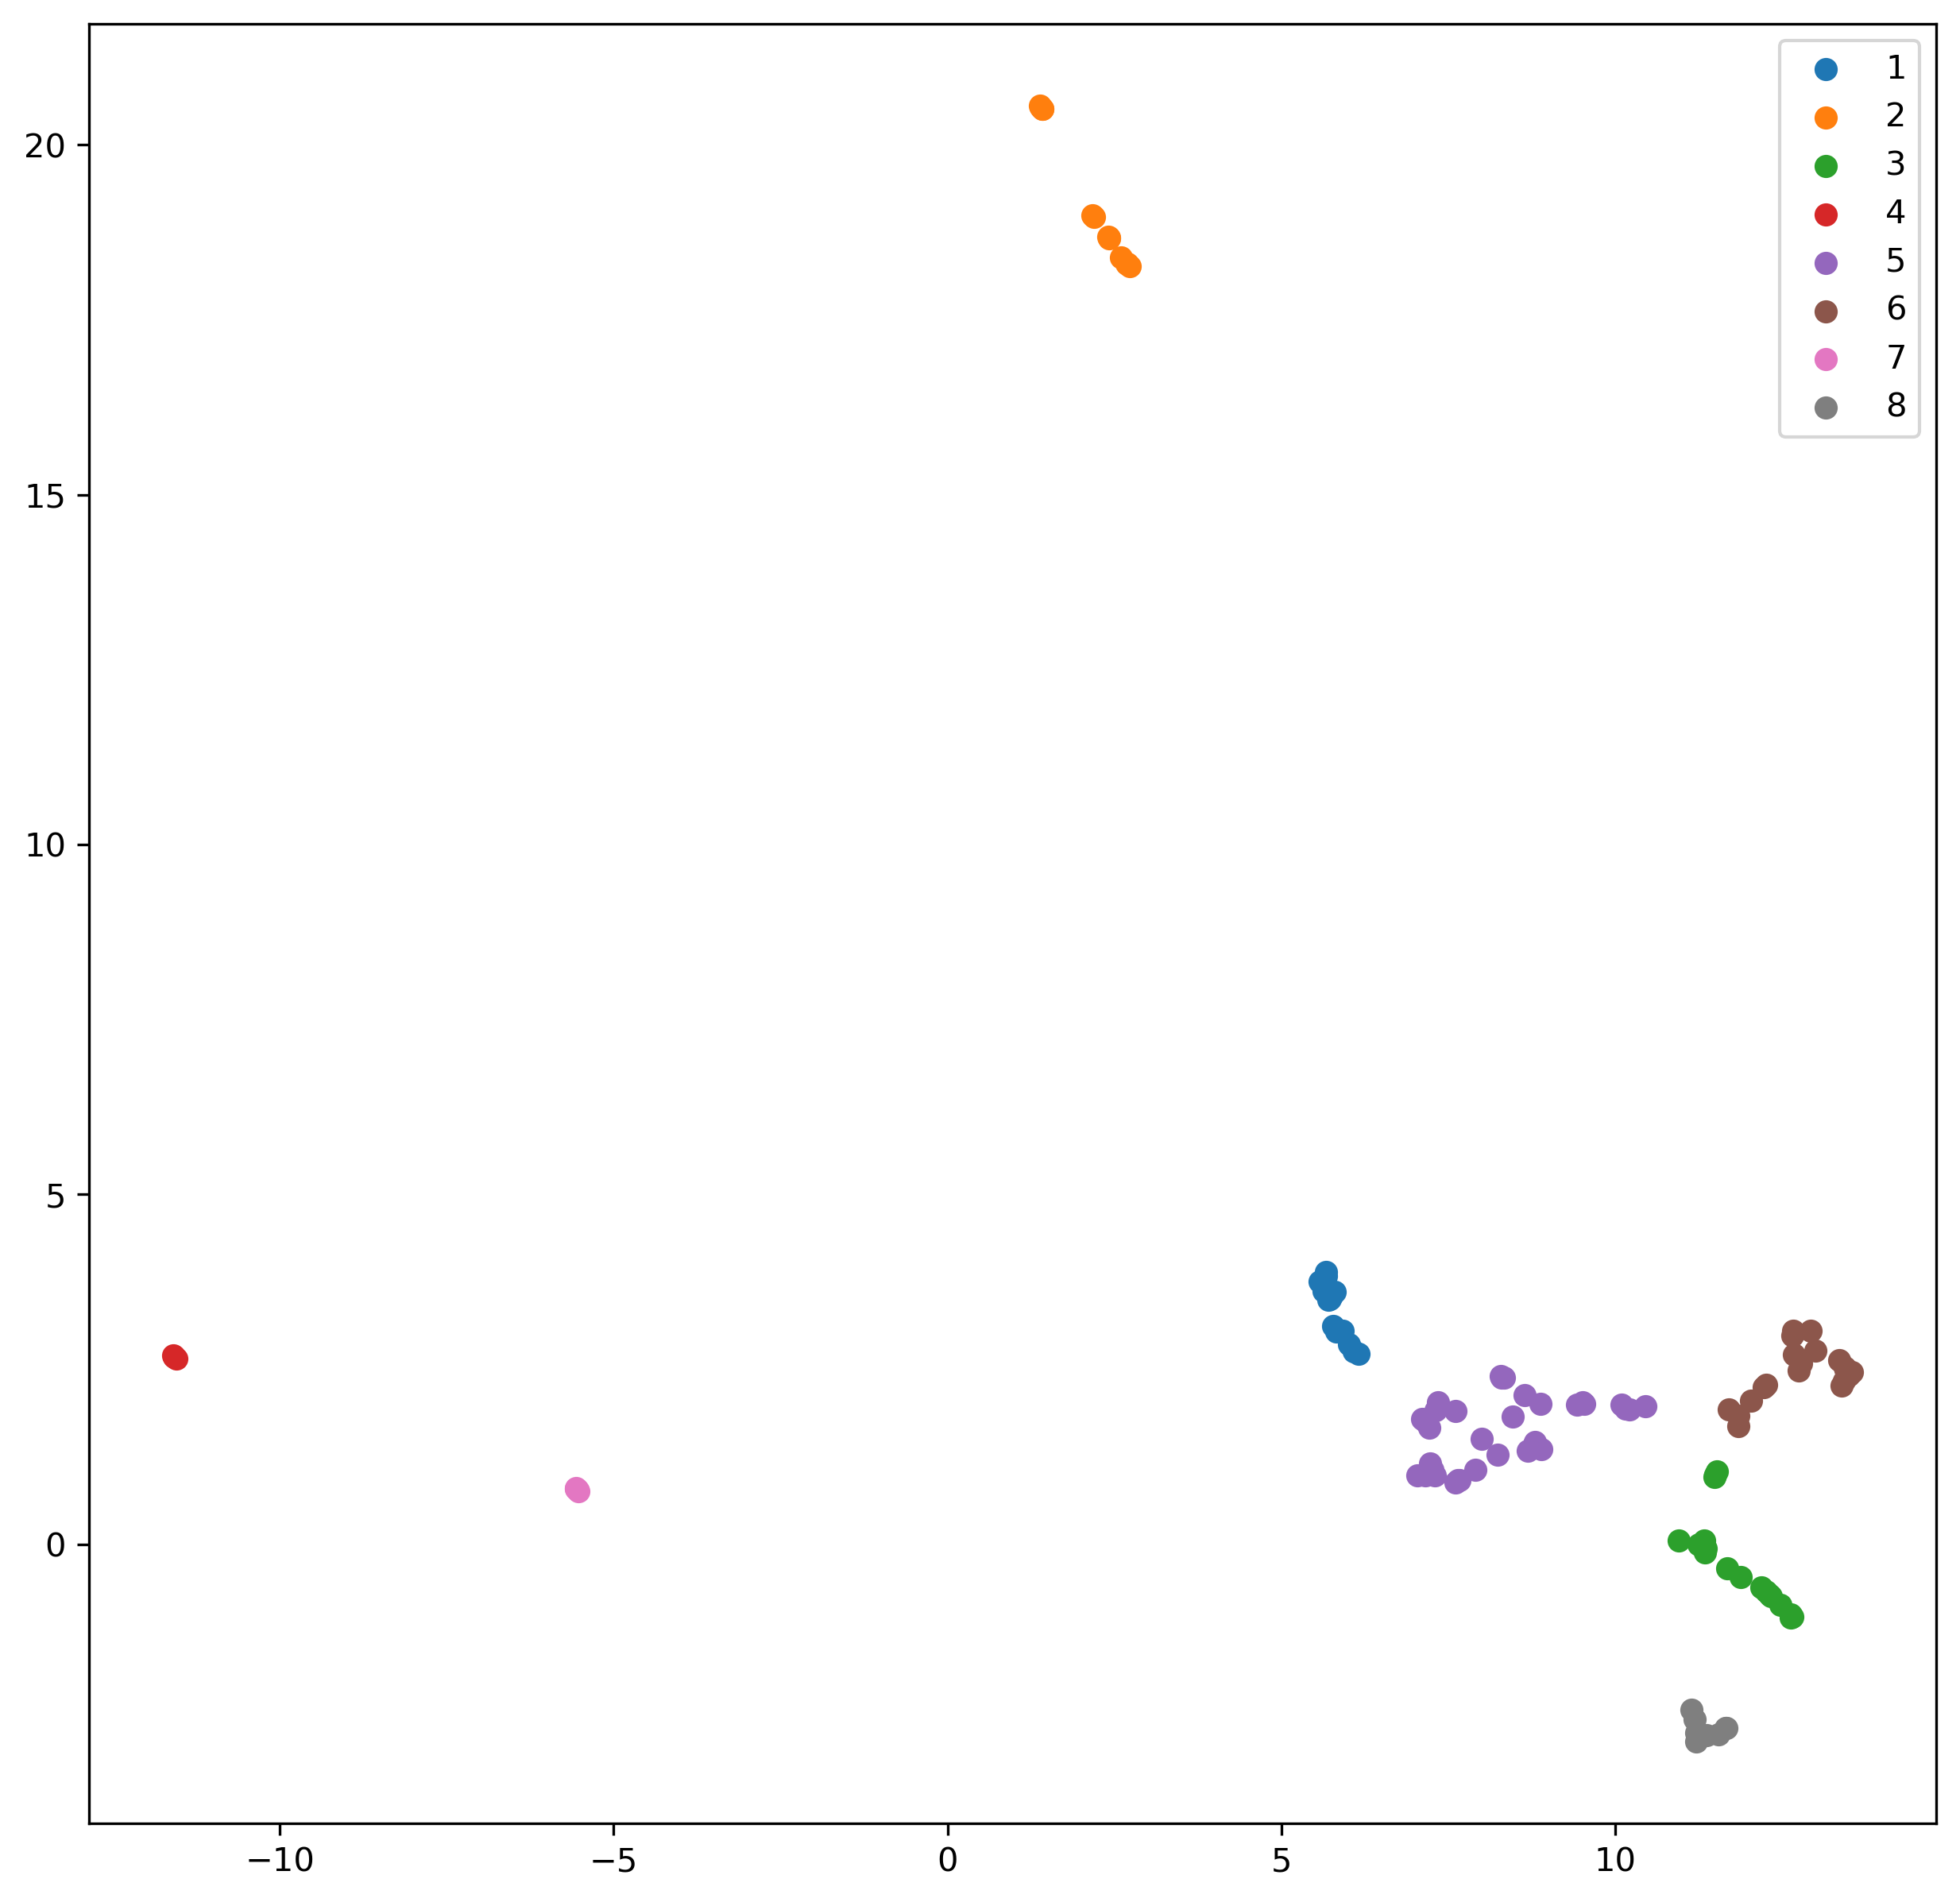

In [92]:
cmap = cluster_umap(u,8,clean_df3)
cmap

In [94]:
# characterize the points in these clusters by the selected features

clean_df3.iloc[cmap.labels_==5].groupby('label')[select_feats].describe().T

label                      MOD       NoMOD
age          count   11.000000   10.000000
             mean    27.570703   32.349704
             std      6.346546    6.301857
             min     18.430976   18.566546
             25%     25.639704   30.870514
             50%     25.639704   34.871606
             75%     32.853094   36.433124
             max     36.925418   37.608090
ed_inp_delta count   11.000000   10.000000
             mean     2.827834    4.491309
             std      2.567818    2.942206
             min      0.086968    0.802188
             25%      0.844190    2.149326
             50%      2.672222    4.277957
             75%      3.653247    6.420579
             max      9.111829    8.930127
sodium_min   count   11.000000   10.000000
             mean   137.909091  137.600000
             std      2.427120    3.864367
             min    134.000000  130.000000
             25%    136.500000  135.500000
             50%    139.000000  137.500000
             75%    140.000000  140.750000
             max    140.000000  142.000000
chloride_min count   11.000000   10.000000
             mean   101.363636  104.200000
             std      2.335497    3.047768
             min     97.000000   99.000000
             25%    101.000000  102.000000
             50%    101.000000  105.000000
             75%    102.000000  106.750000
             max    107.000000  107.000000
creat_min    count   11.000000   10.000000
             mean     0.736909    0.929700
             std      0.315659    0.163839
             min      0.438000    0.700000
             25%      0.600000    0.810250
             50%      0.600000    0.910000
             75%      0.850000    1.030000
             max      1.530000    1.200000
creat_max    count   11.000000   10.000000
             mean     0.782364    0.929700
             std      0.297786    0.163839
             min      0.438000    0.700000
             25%      0.700000    0.810250
             50%      0.700000    0.910000
             75%      0.850000    1.030000
             max      1.530000    1.200000
PULSE        count   11.000000   10.000000
             mean   110.363636  106.800000
             std      6.607159   14.022205
             min     96.000000   88.000000
             25%    109.000000   94.000000
             50%    109.000000  108.500000
             75%    114.000000  119.000000
             max    120.000000  125.000000
TEMPERATURE  count   11.000000   10.000000
             mean    99.754545   97.820000
             std      1.407383    1.838961
             min     95.600000   96.000000
             25%     99.900000   96.450000
             50%     99.900000   96.700000
             75%    100.350000   99.725000
             max    100.600000  100.400000
DBP          count   11.000000   10.000000
             mean    82.272727   84.500000
             std      4.734784    7.975657
             min     76.000000   74.000000
             25%     81.500000   76.000000
             50%     82.000000   87.000000
             75%     83.000000   91.000000
             max     94.000000   94.000000

In [134]:
xr_df_labeled.columns

Index(['PtSSN', 'num_xr', 'num_abnormal_xr', 'label'], dtype='object')

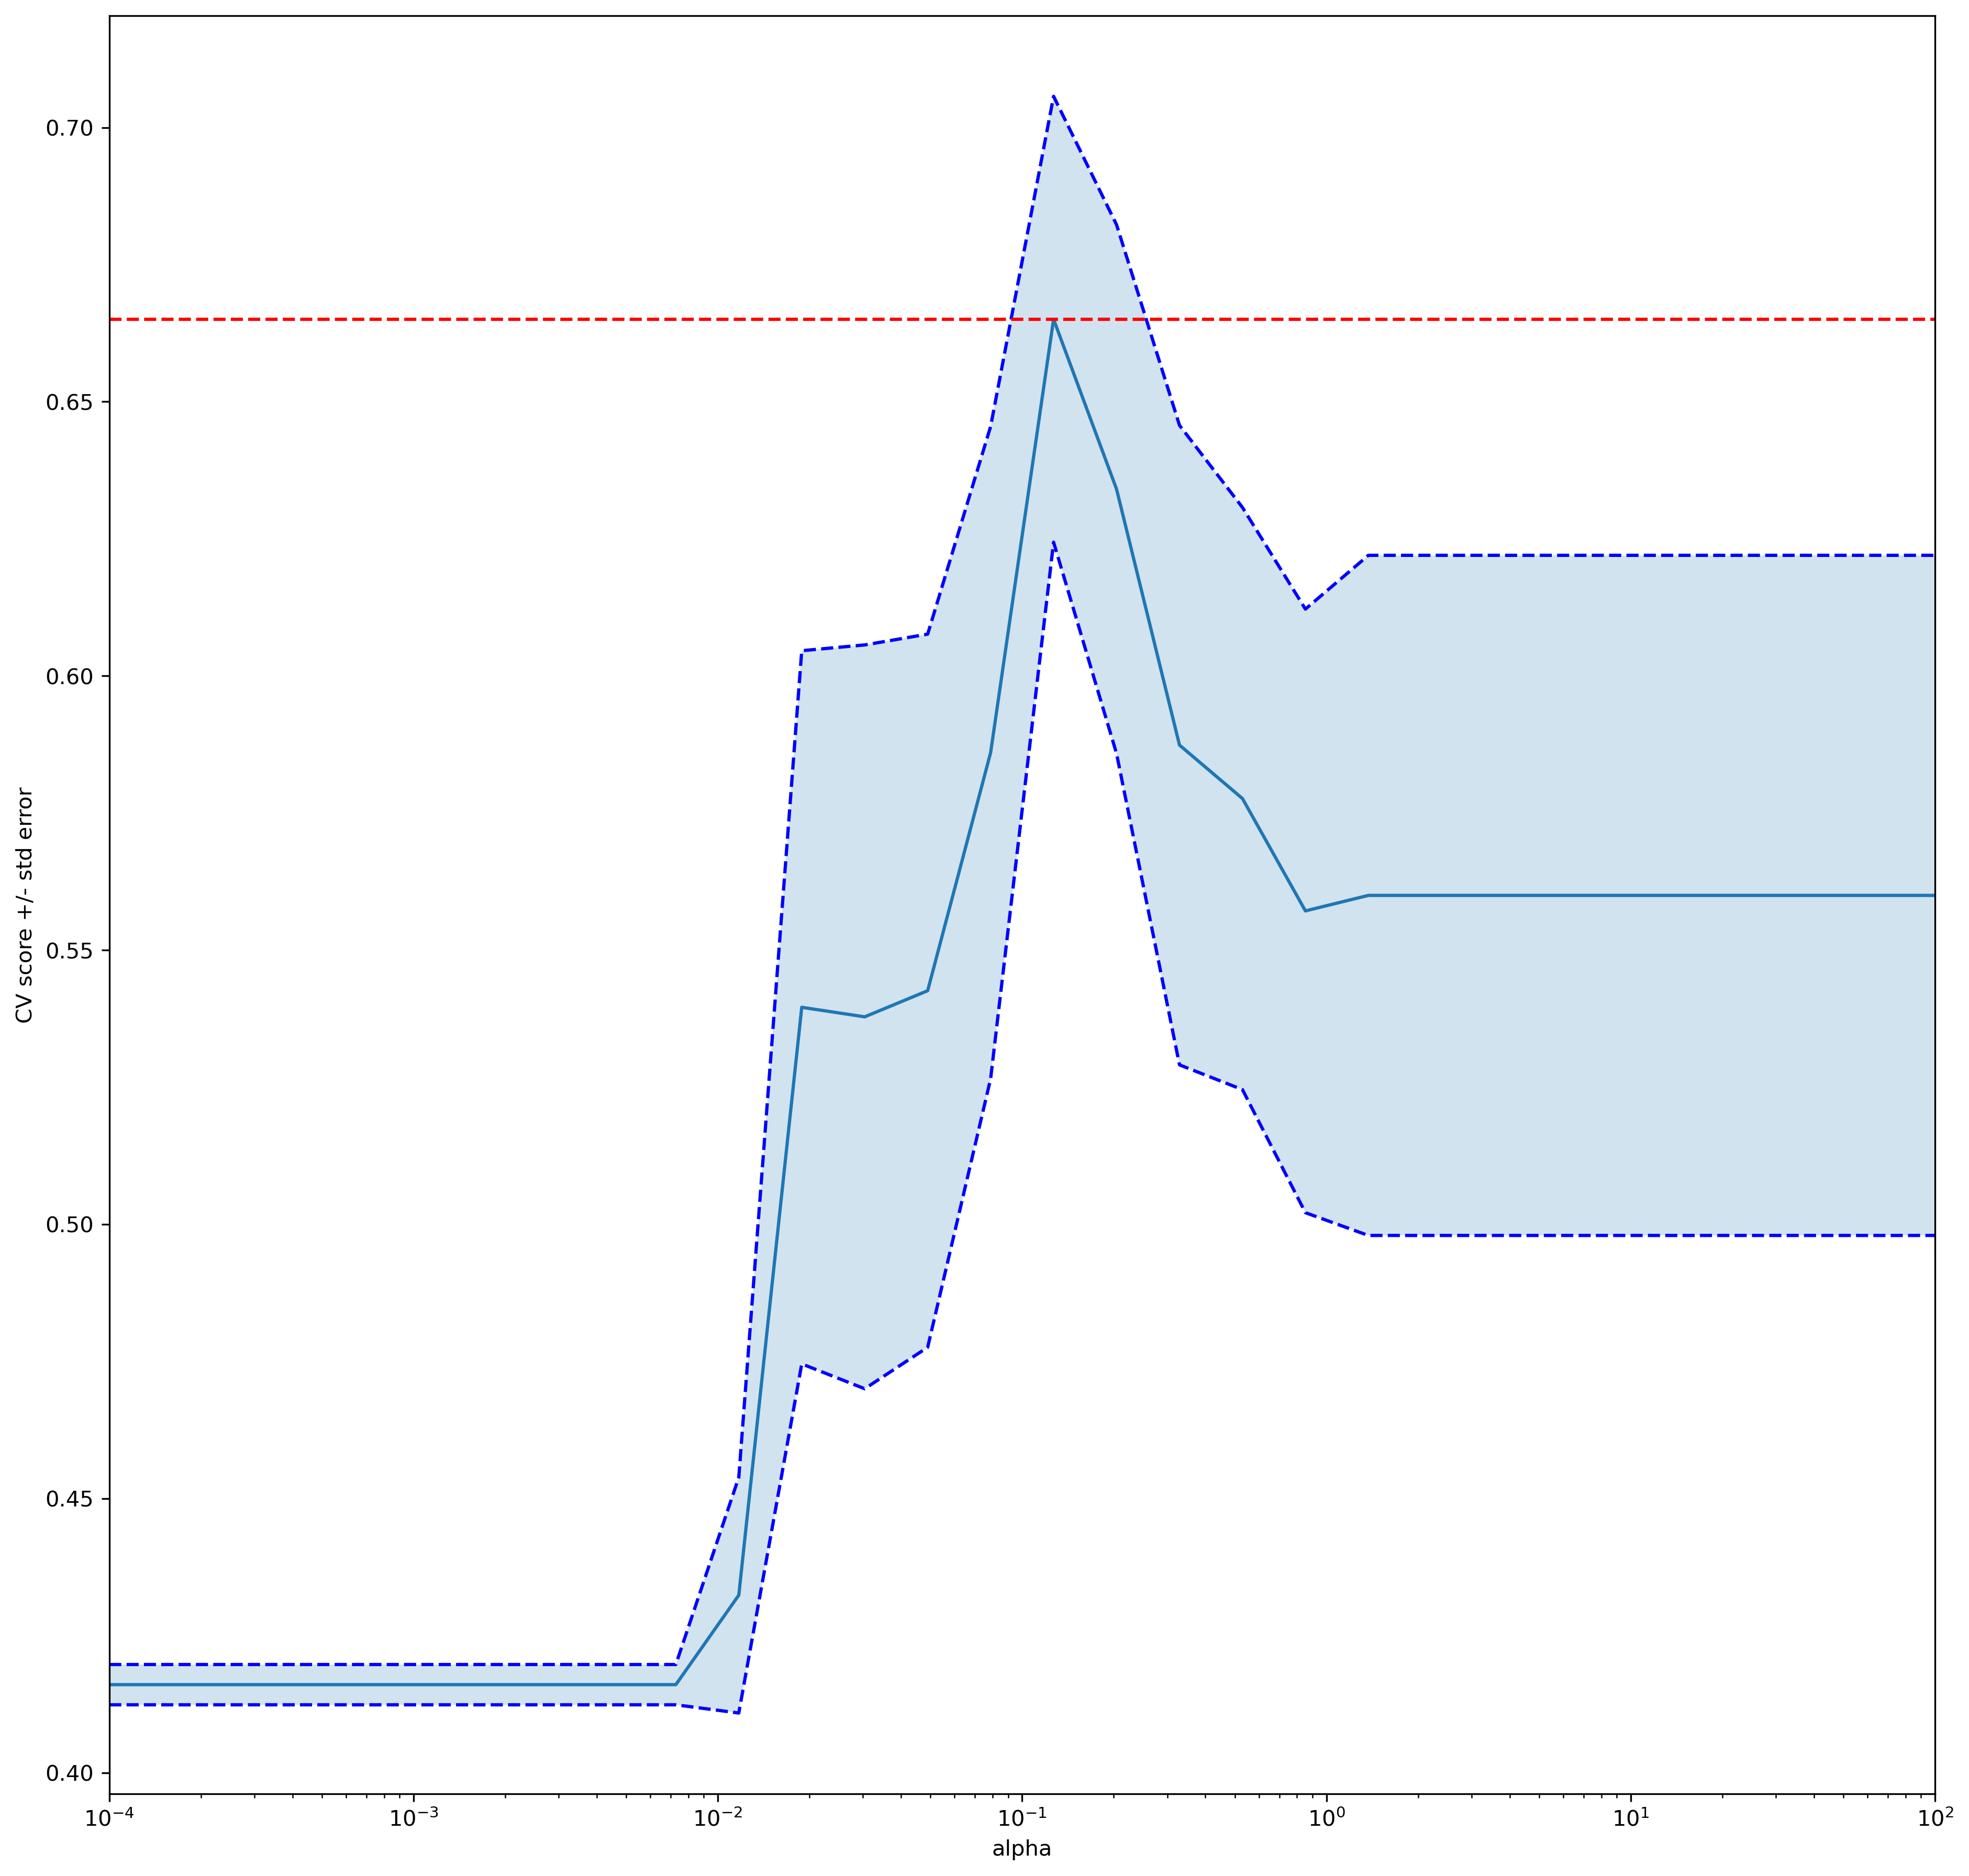

In [300]:
# now take clean_df3 and add imaging data
xr_cols = ['num_xr','num_abnormal_xr']
ct_cols = ['num_ct','num_abnormal_ct','num_contrast']
us_cols = ['num_us']

df4 = pd.merge(clean_df3,xr_df_labeled[['PtSSN','label'] + xr_cols],on=['PtSSN','label'])
df4 = pd.merge(df4,ct_df_labeled[['PtSSN','label'] + ct_cols],on=['PtSSN','label'])
df4 = pd.merge(df4,us_df_labeled[['PtSSN','label'] + us_cols],on=['PtSSN','label'])

clean_df4 = df4.dropna()
X = clean_df4[clean_df4.columns[2:]]
y = np.array([1 if x=='MOD' else 0 for x in clean_df4['label']])

clf = tune_model(X,y)

(94, 38) (94,)
AUC =  0.7245421245421246 0.09974272208011603
F1 =  0.6650313479623826 0.09089339462082305
Accuracy =  0.7549707602339181 0.05511986745238913
Confusion matrix:
[[62  5]
 [15 12]]
10  features chosen by L1 model.


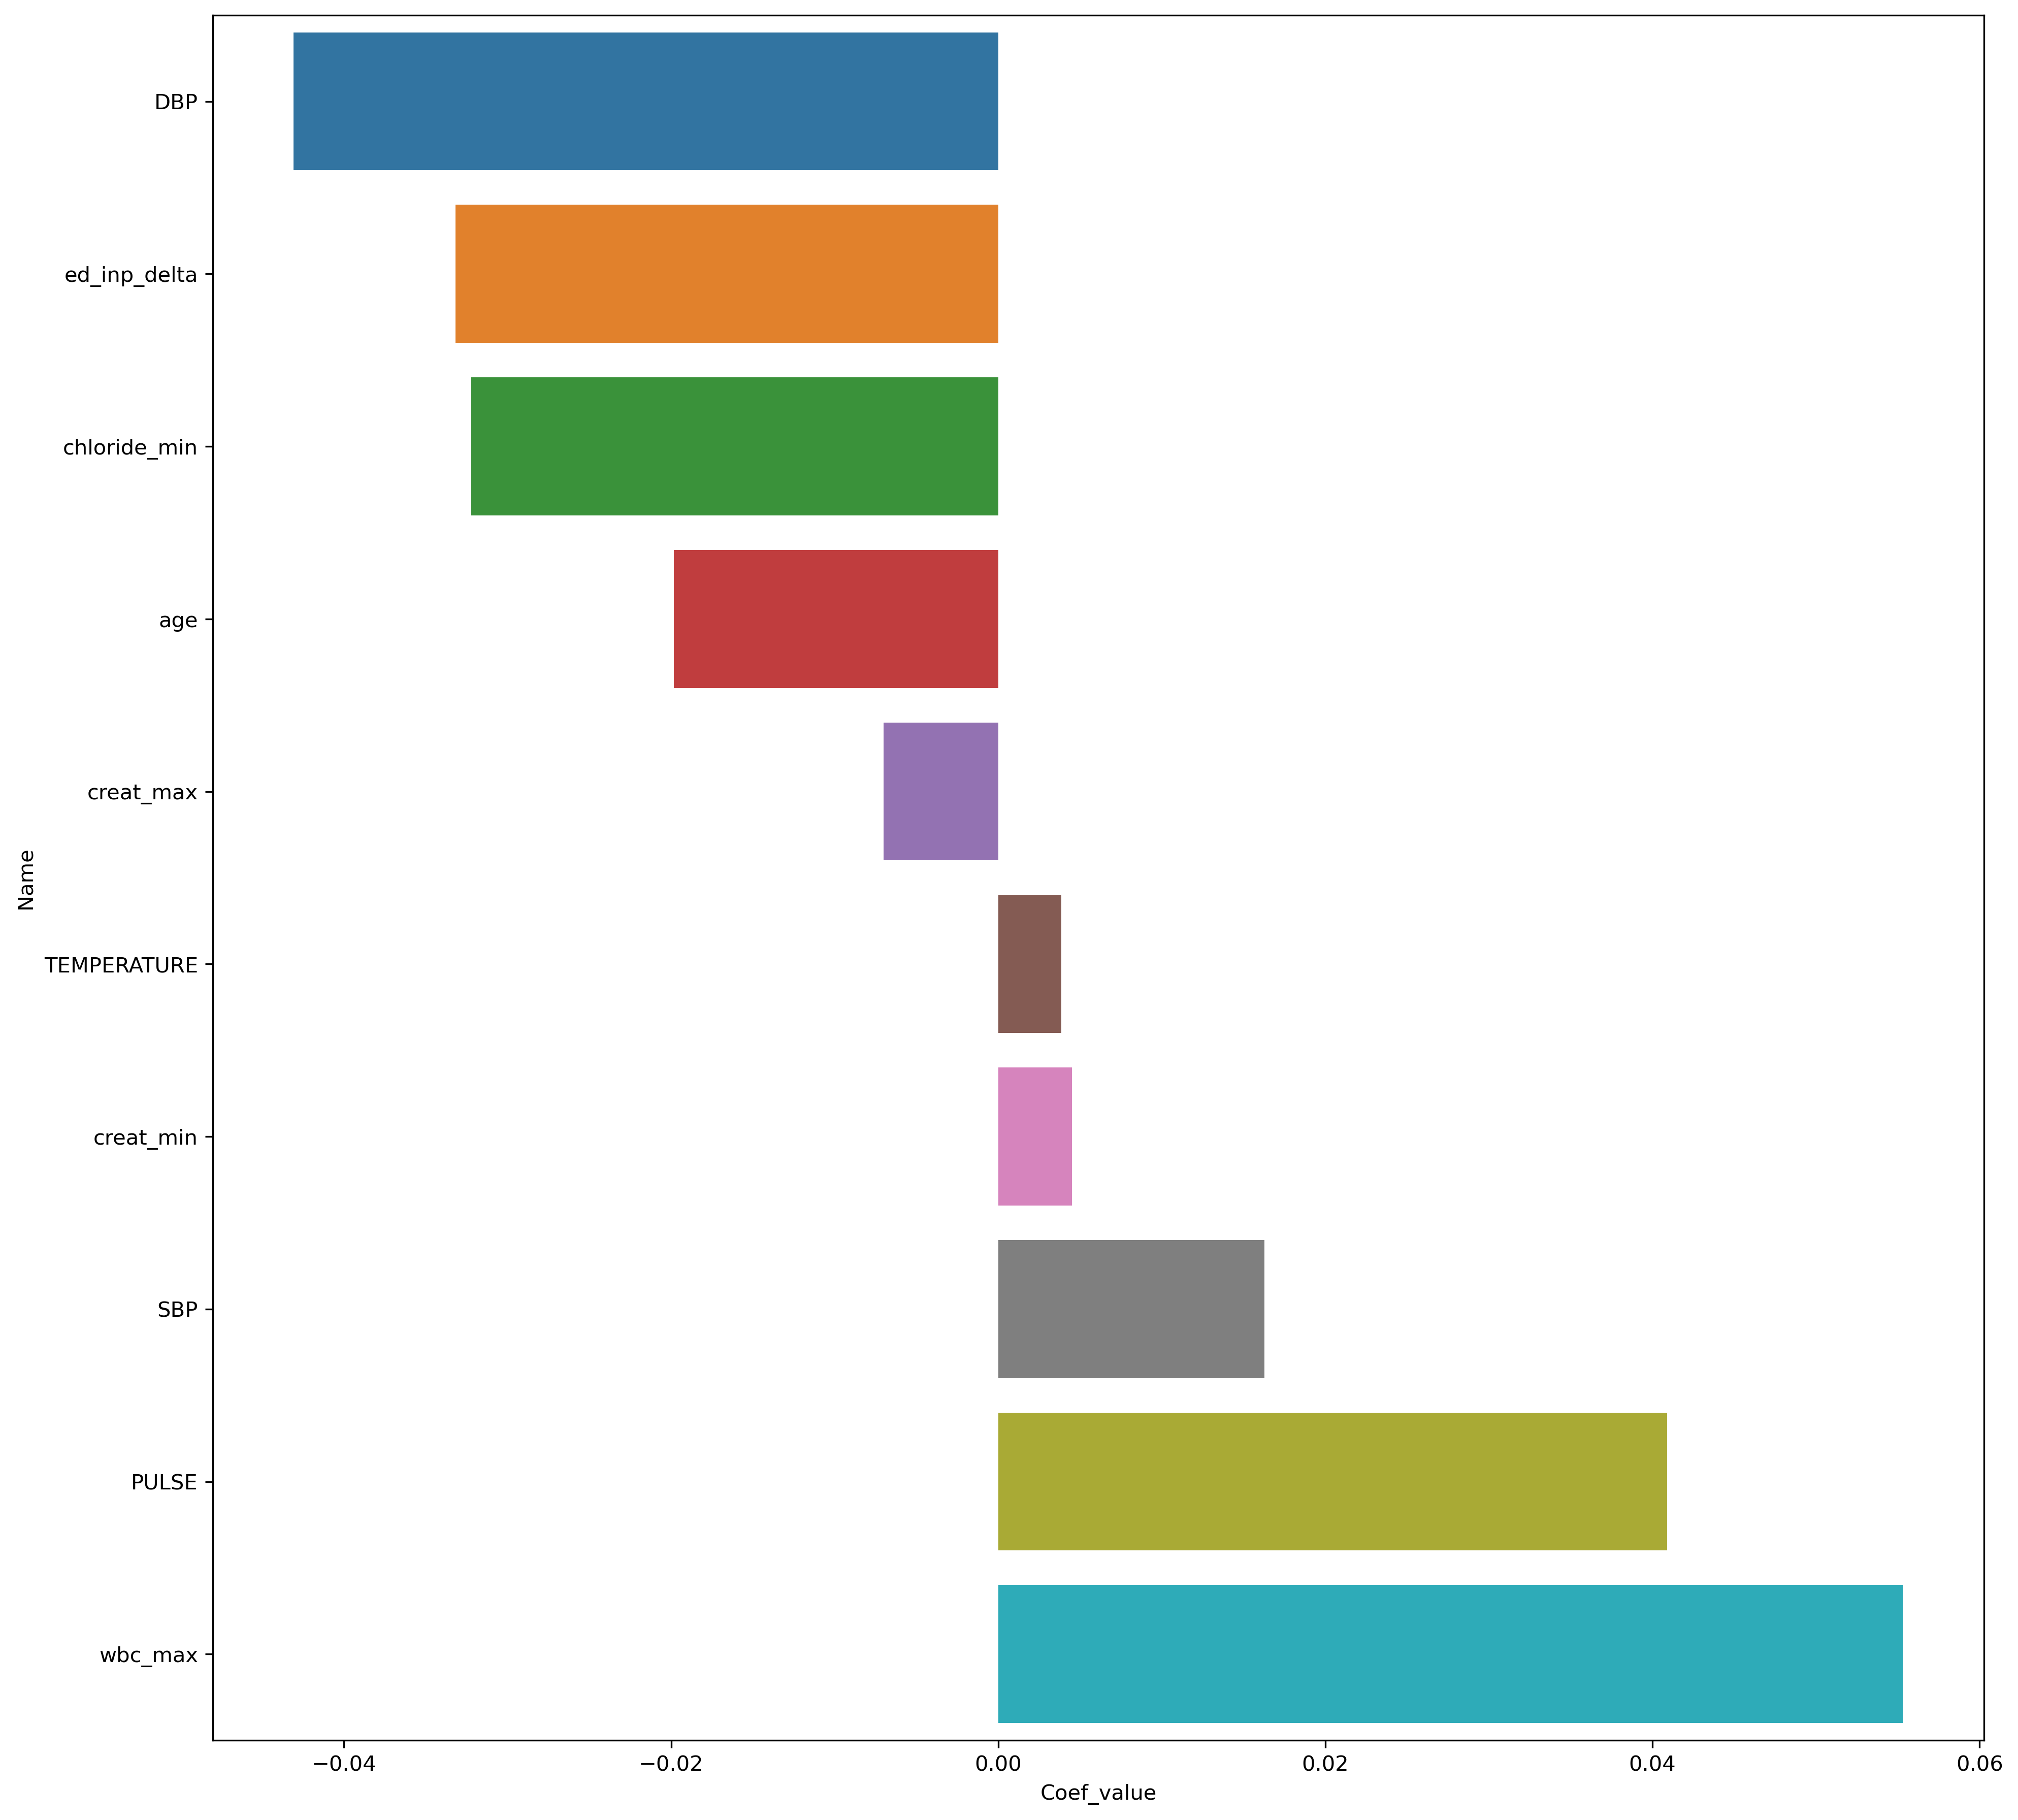

In [301]:
clf,select_feats = build_L1_model(X,y,clf.best_params_['C'])
visualize_model(clf,select_feats)

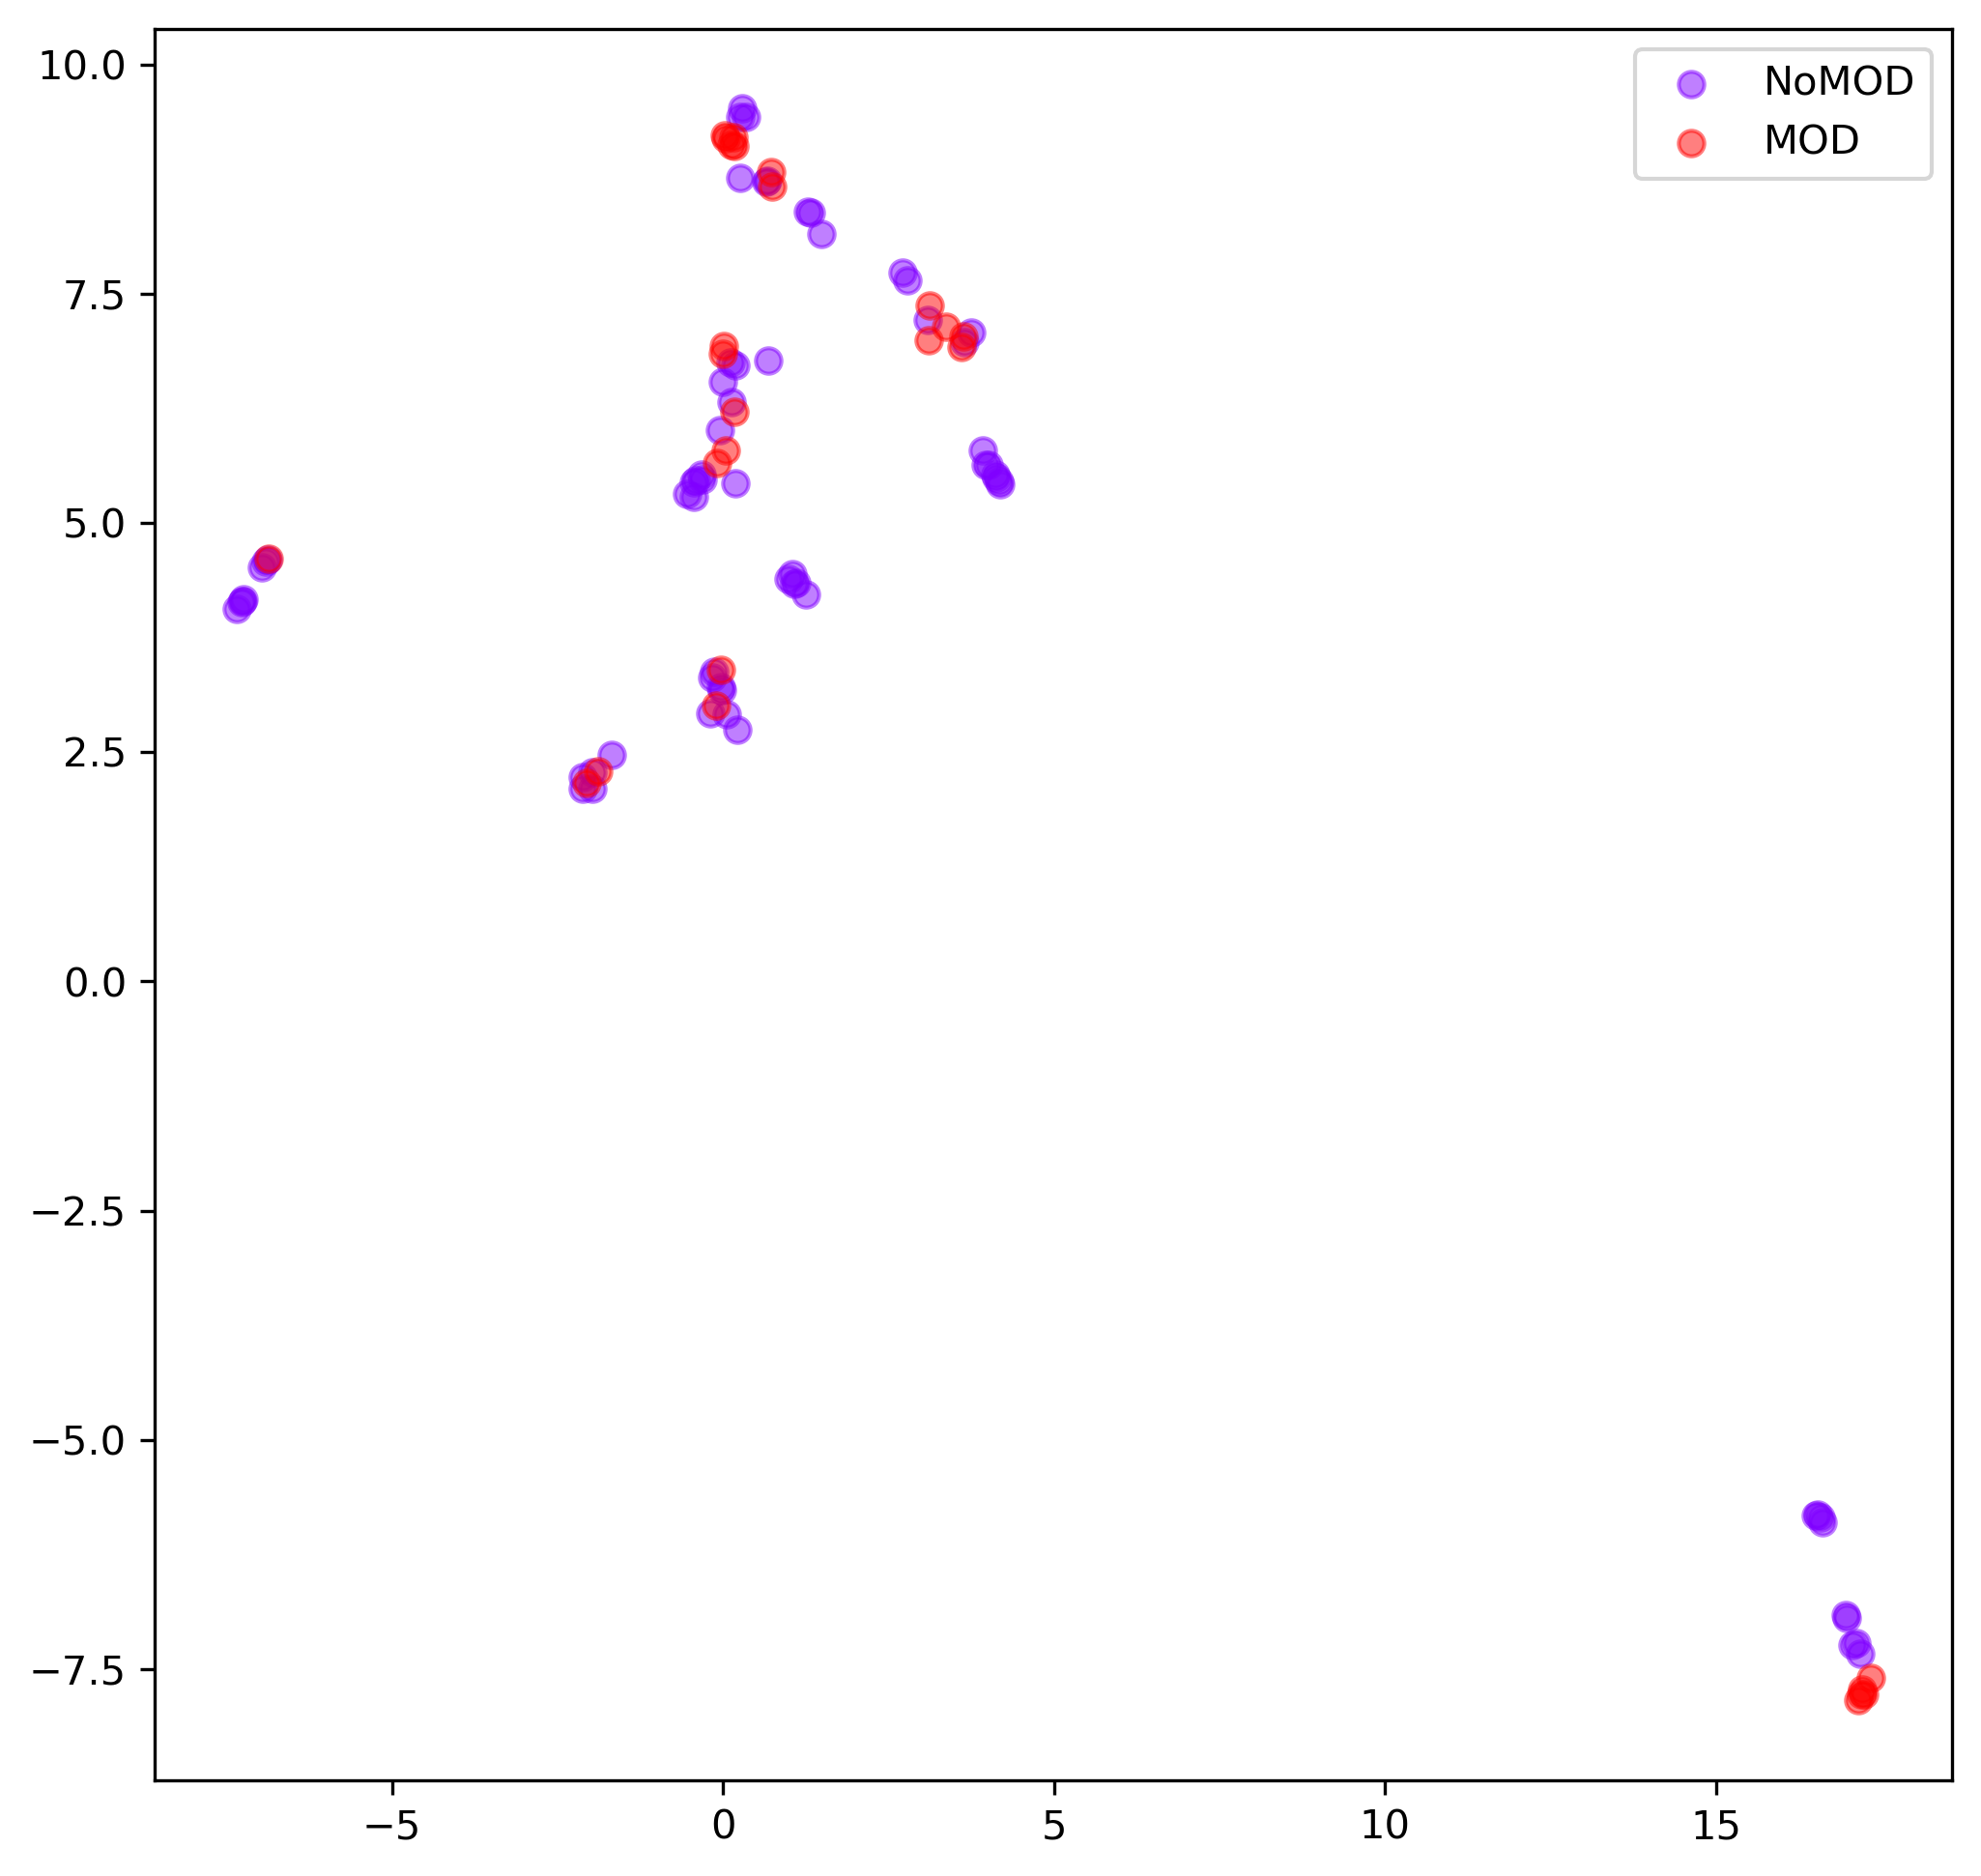

In [302]:
umap_plot_label(X[select_feats],y,1,7,['NoMOD','MOD']);

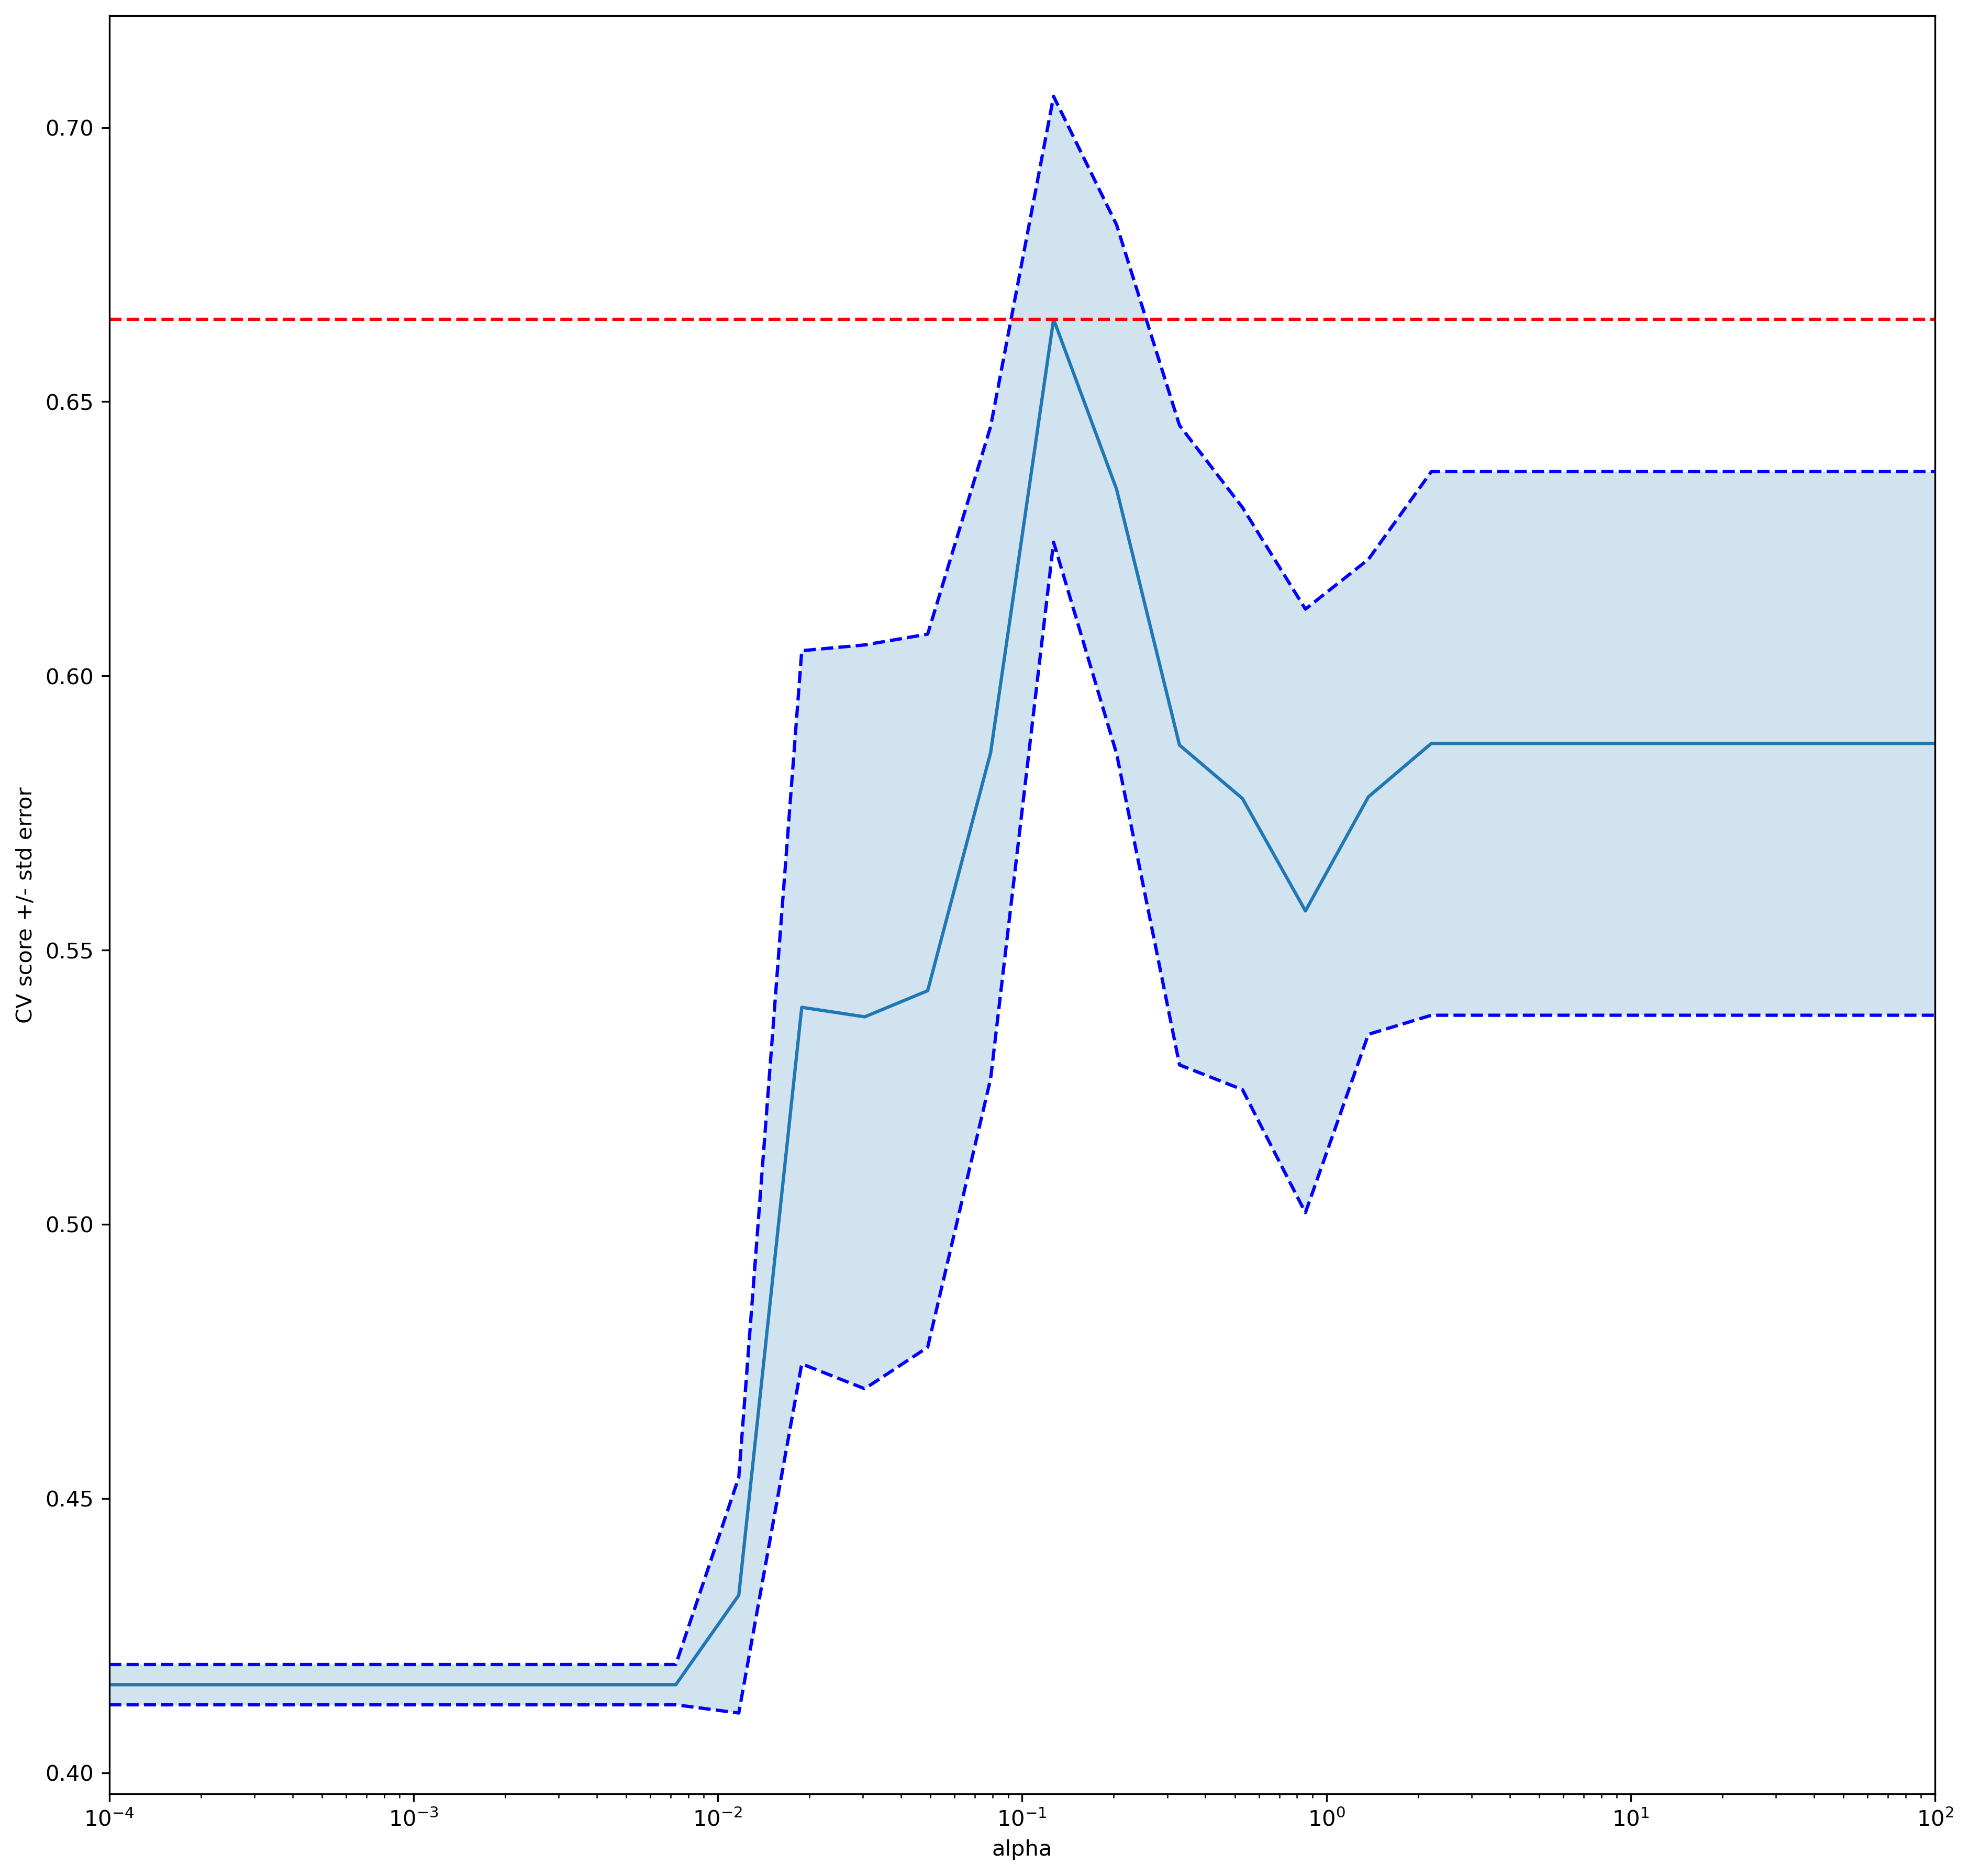

In [303]:
# add AbdominalSurgery from abpain_df

abpain_df_col = ['PMHAbdSurgery']

df5 = pd.merge(clean_df4,abpain_df[['PtSSN']+abpain_df_col],on='PtSSN')
df5.PMHAbdSurgery = df5.PMHAbdSurgery.apply(lambda x: 0 if x=='No' else 1)

X = df5[df5.columns[2:]]
y = np.array([1 if x=='MOD' else 0 for x in df5['label']])

clf = tune_model(X,y)

(94, 39) (94,)
AUC =  0.7245421245421246 0.09974272208011603
F1 =  0.6650313479623826 0.09089339462082305
Accuracy =  0.7549707602339181 0.05511986745238913
Confusion matrix:
[[62  5]
 [15 12]]
10  features chosen by L1 model.


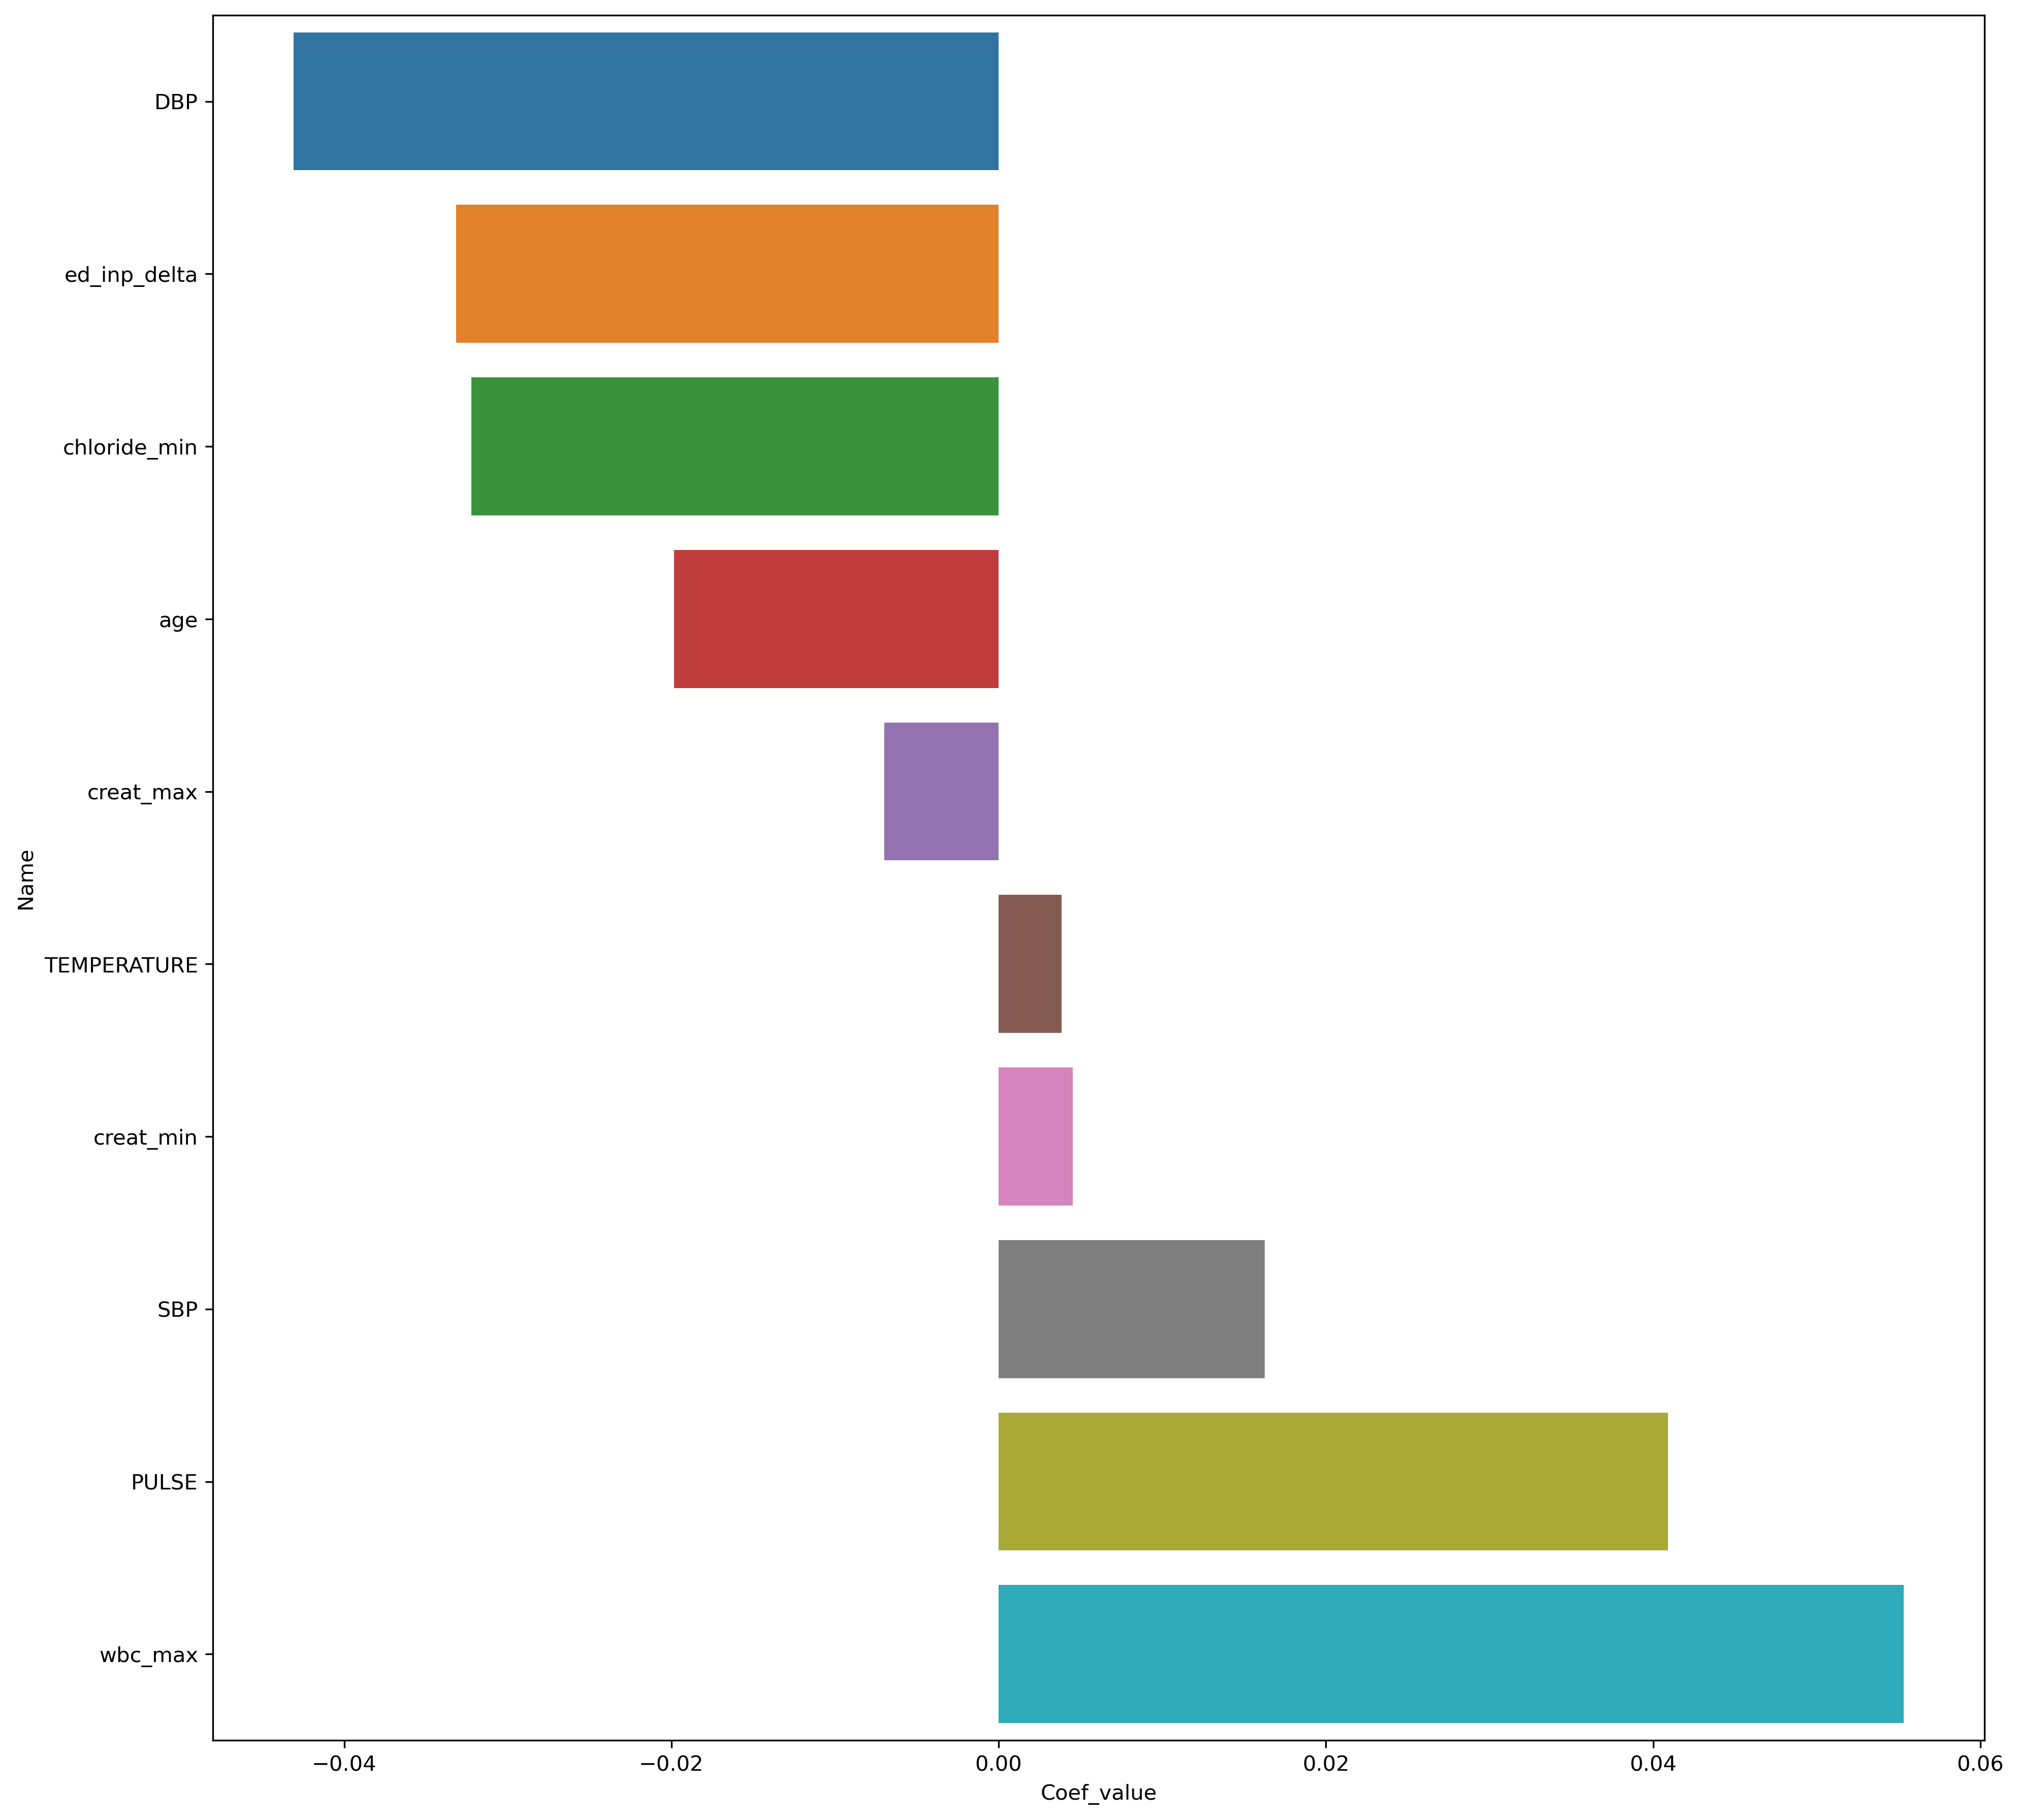

In [304]:
clf,select_feats = build_L1_model(X,y,clf.best_params_['C'])
visualize_model(clf,select_feats)

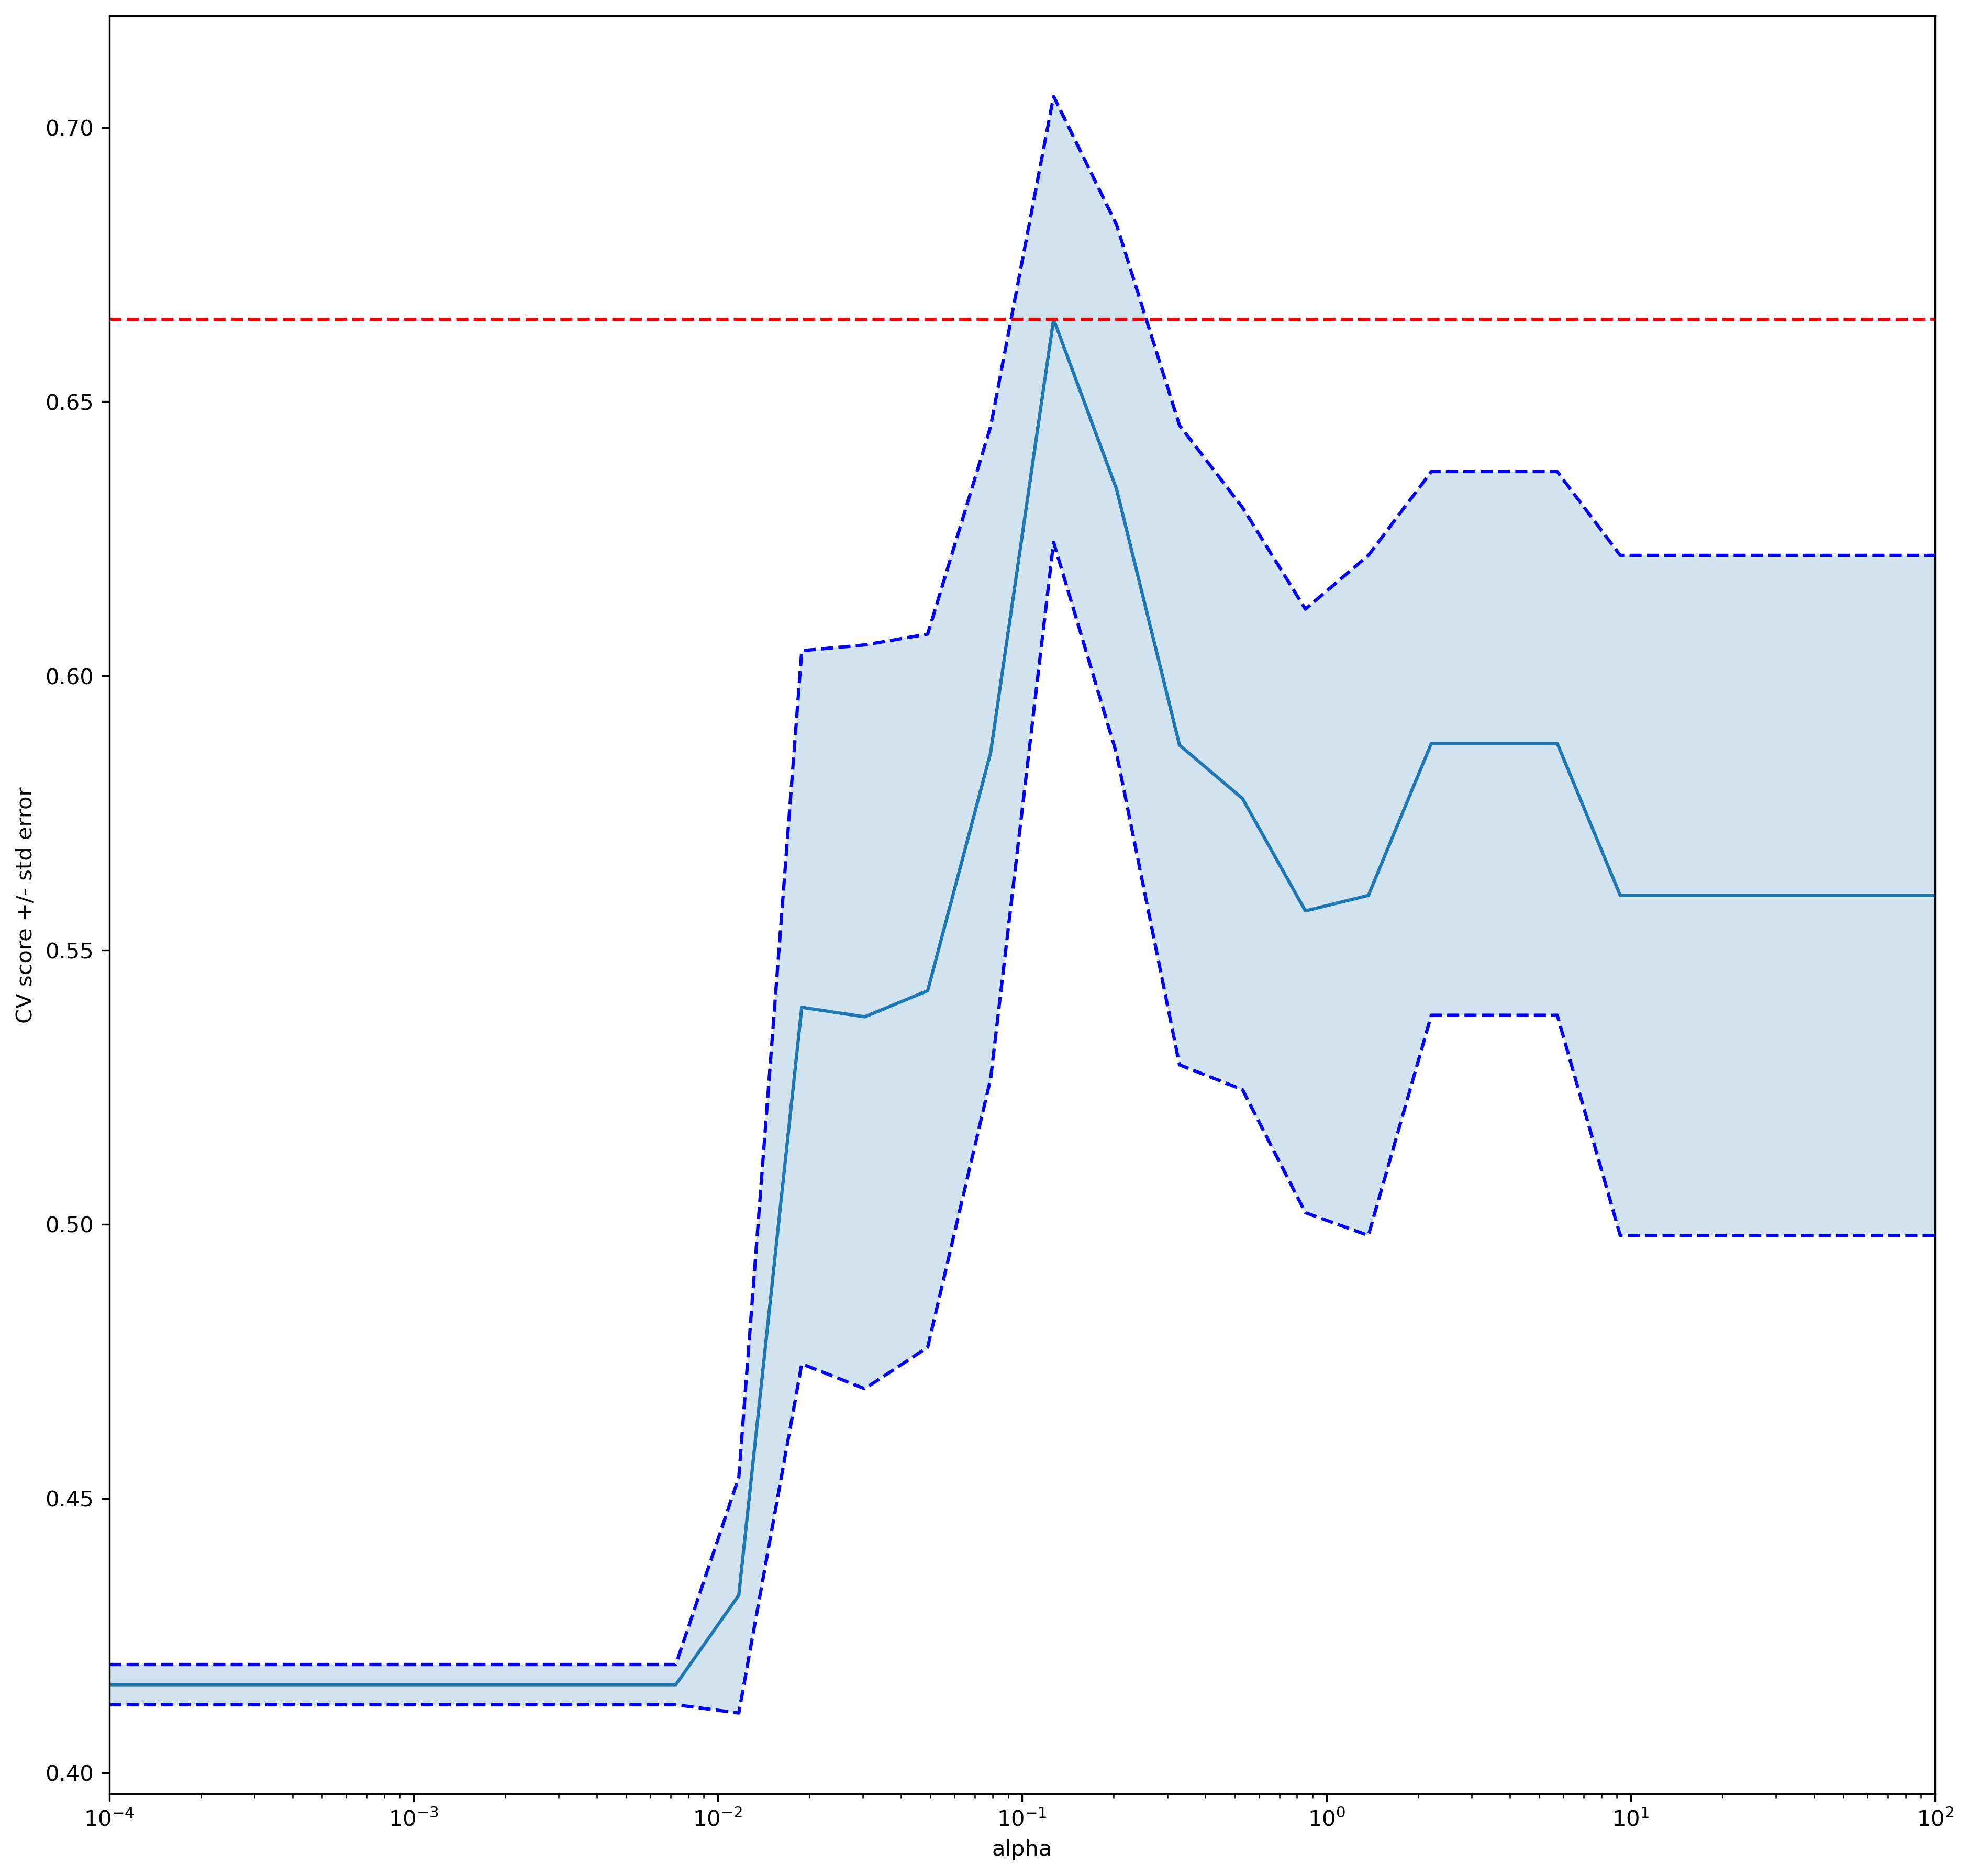

In [305]:
# does mental health status help?
abpain_df_col = ['PMHMentalHealth']

df5 = pd.merge(clean_df4,abpain_df[['PtSSN']+abpain_df_col],on='PtSSN')
df5.PMHMentalHealth = df5.PMHMentalHealth.apply(lambda x: 0 if x=='No' else 1)

X = df5[df5.columns[2:]]
y = np.array([1 if x=='MOD' else 0 for x in df5['label']])

clf = tune_model(X,y)


(94, 39) (94,)
AUC =  0.7245421245421246 0.09974272208011603
F1 =  0.6650313479623826 0.09089339462082305
Accuracy =  0.7549707602339181 0.05511986745238913
Confusion matrix:
[[62  5]
 [15 12]]
10  features chosen by L1 model.


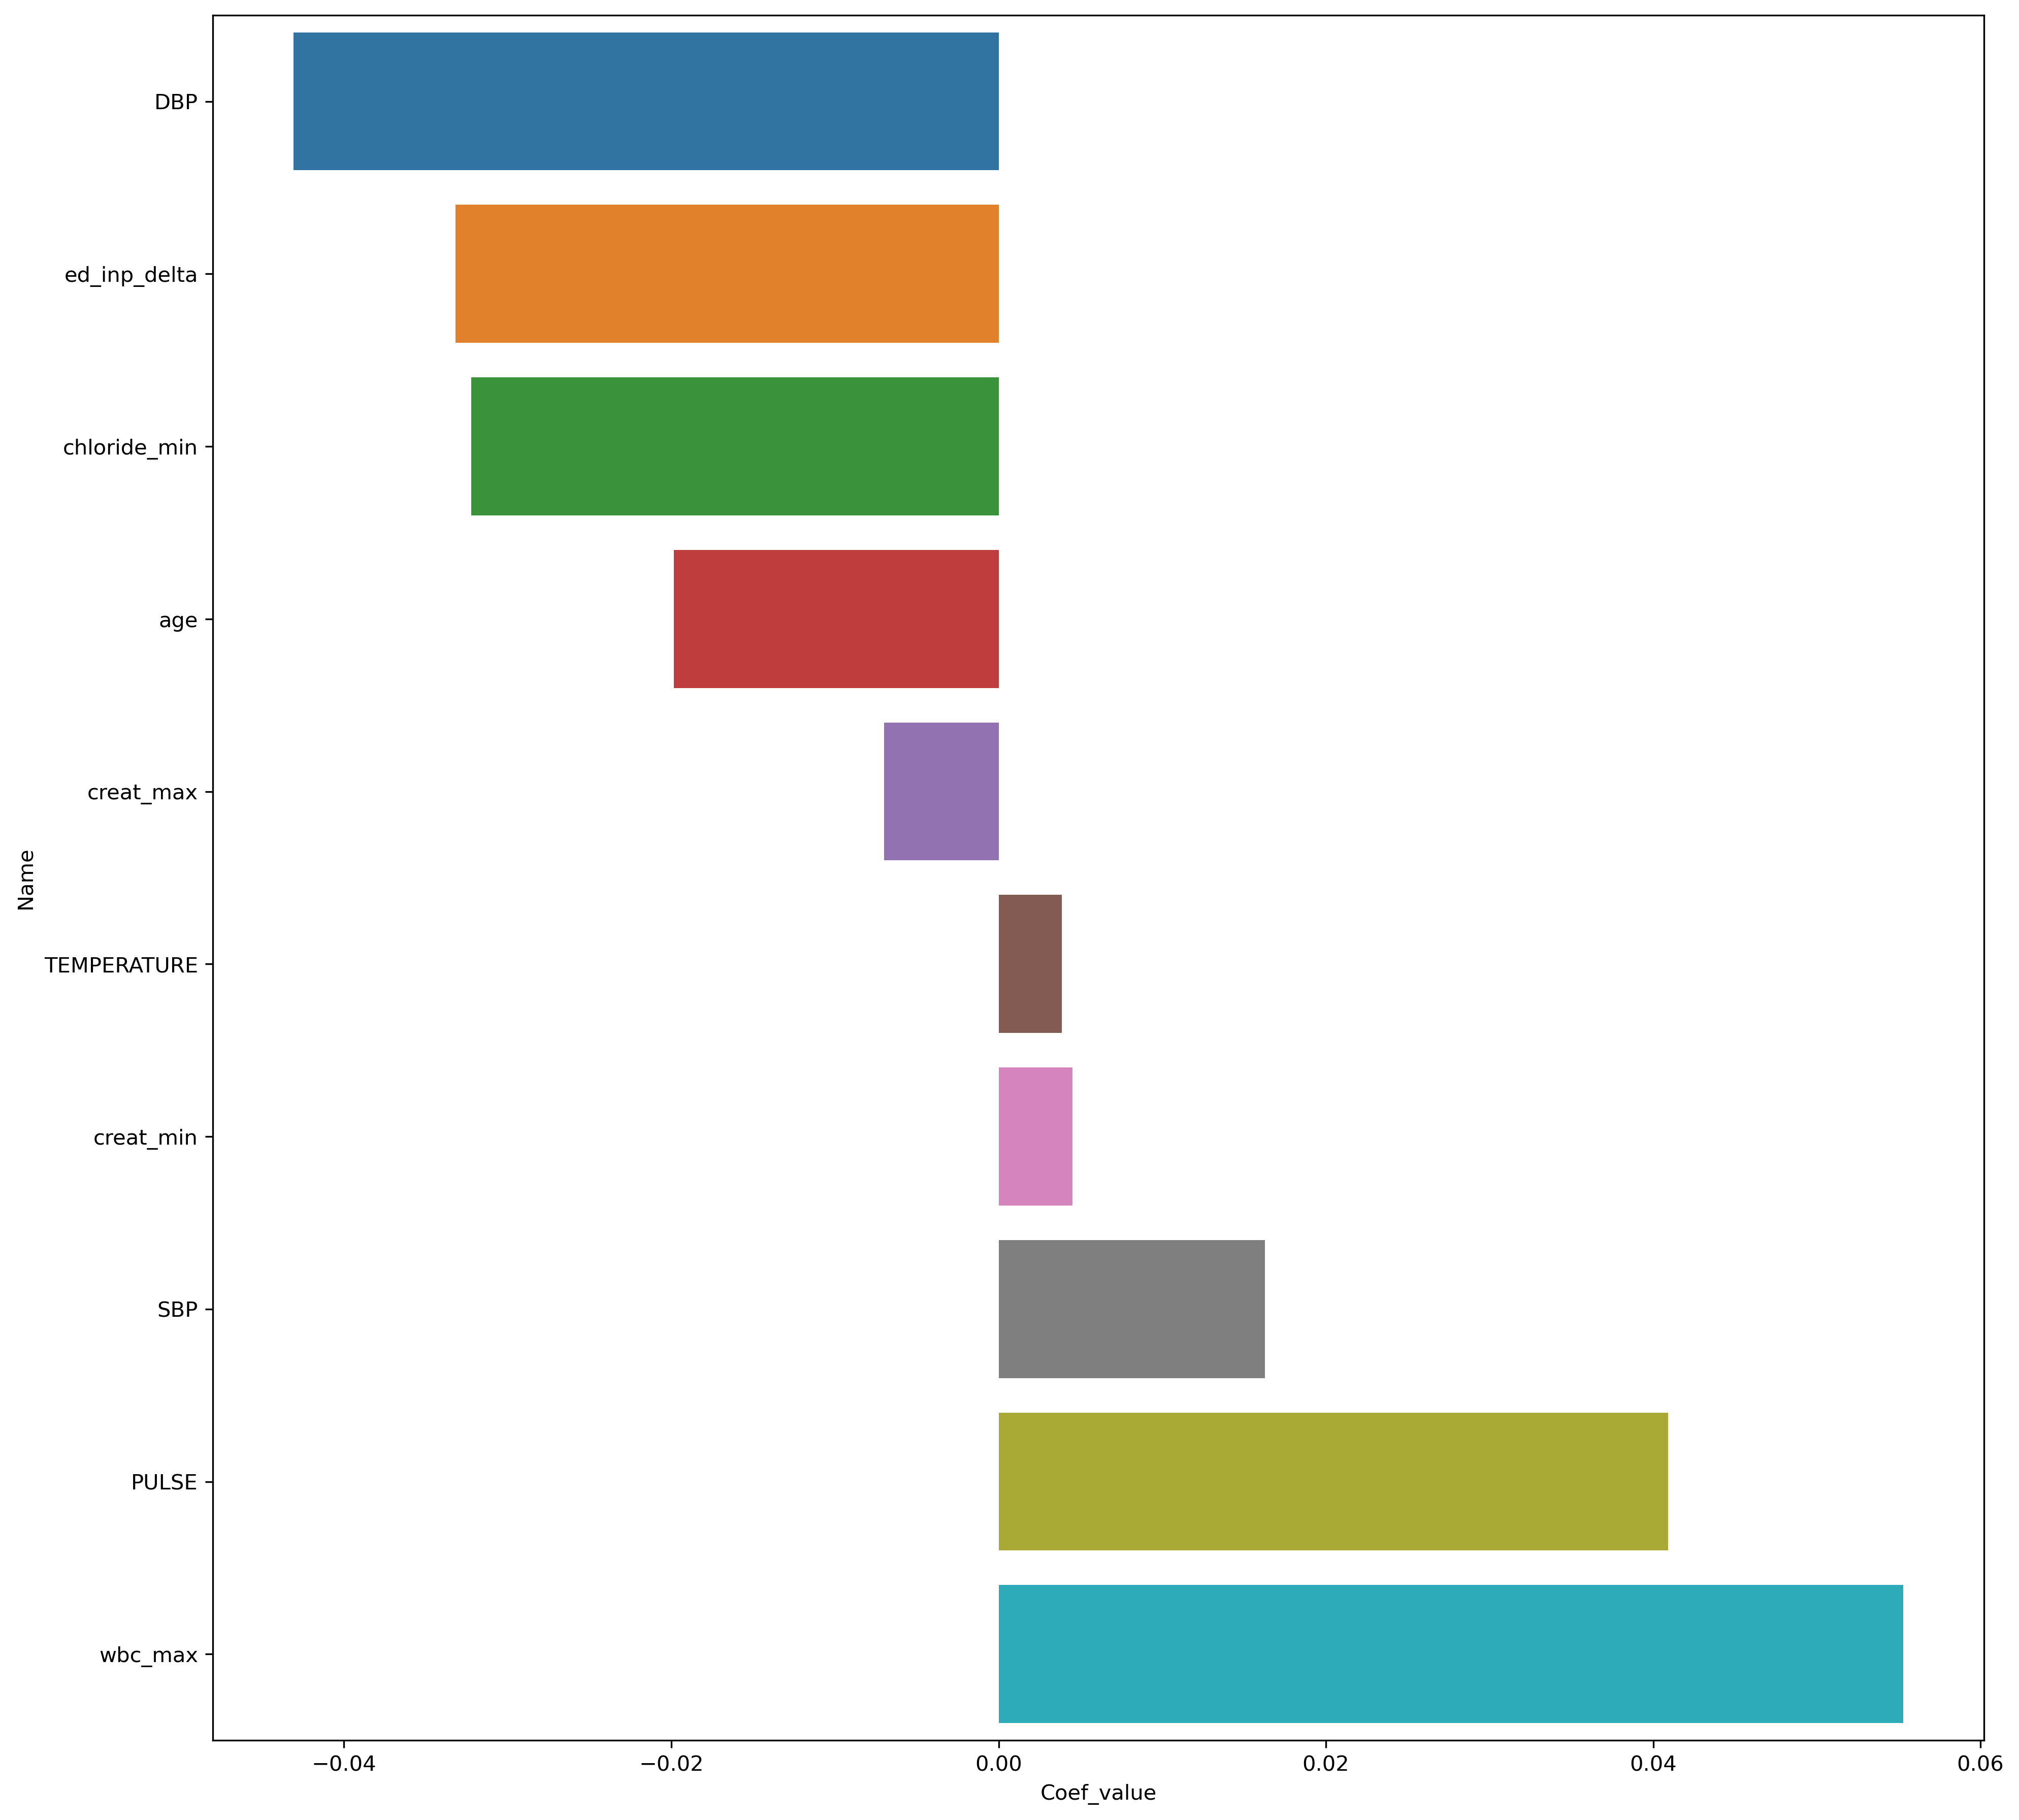

In [306]:
clf,select_feats = build_L1_model(X,y,clf.best_params_['C'])
visualize_model(clf,select_feats)

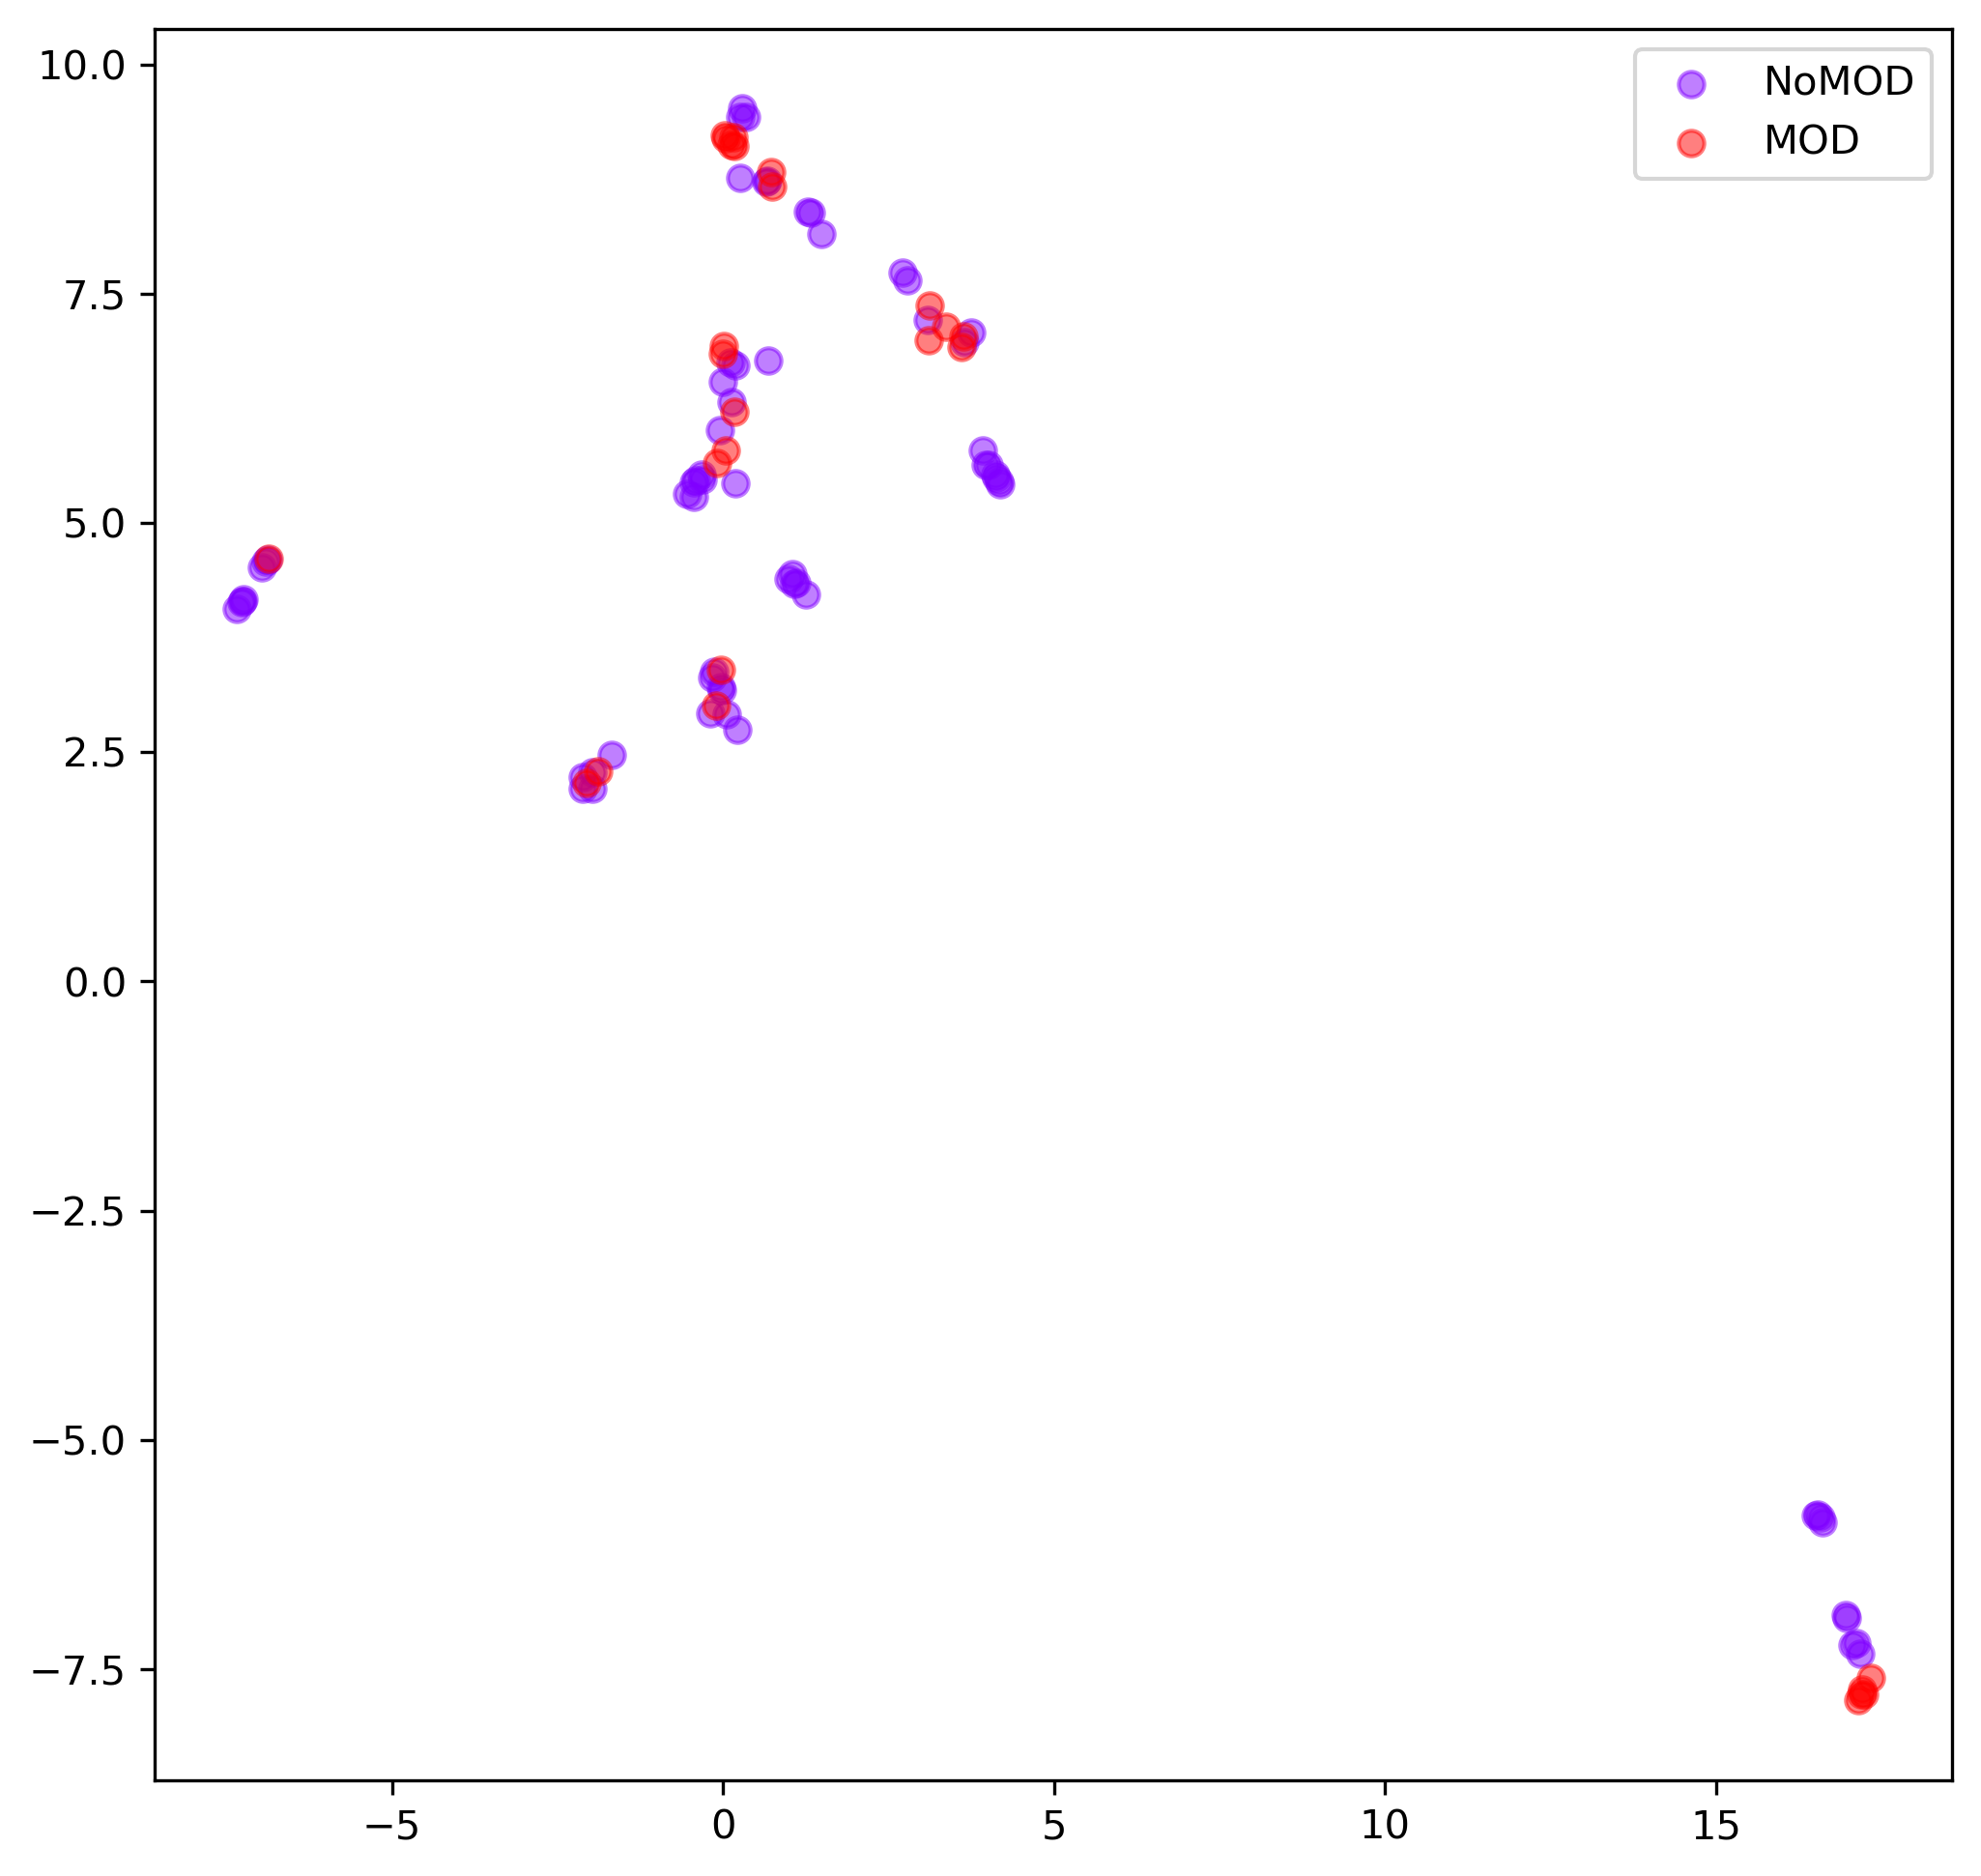

In [307]:
umap_plot_label(X[select_feats],y,1,7,['NoMOD','MOD']);

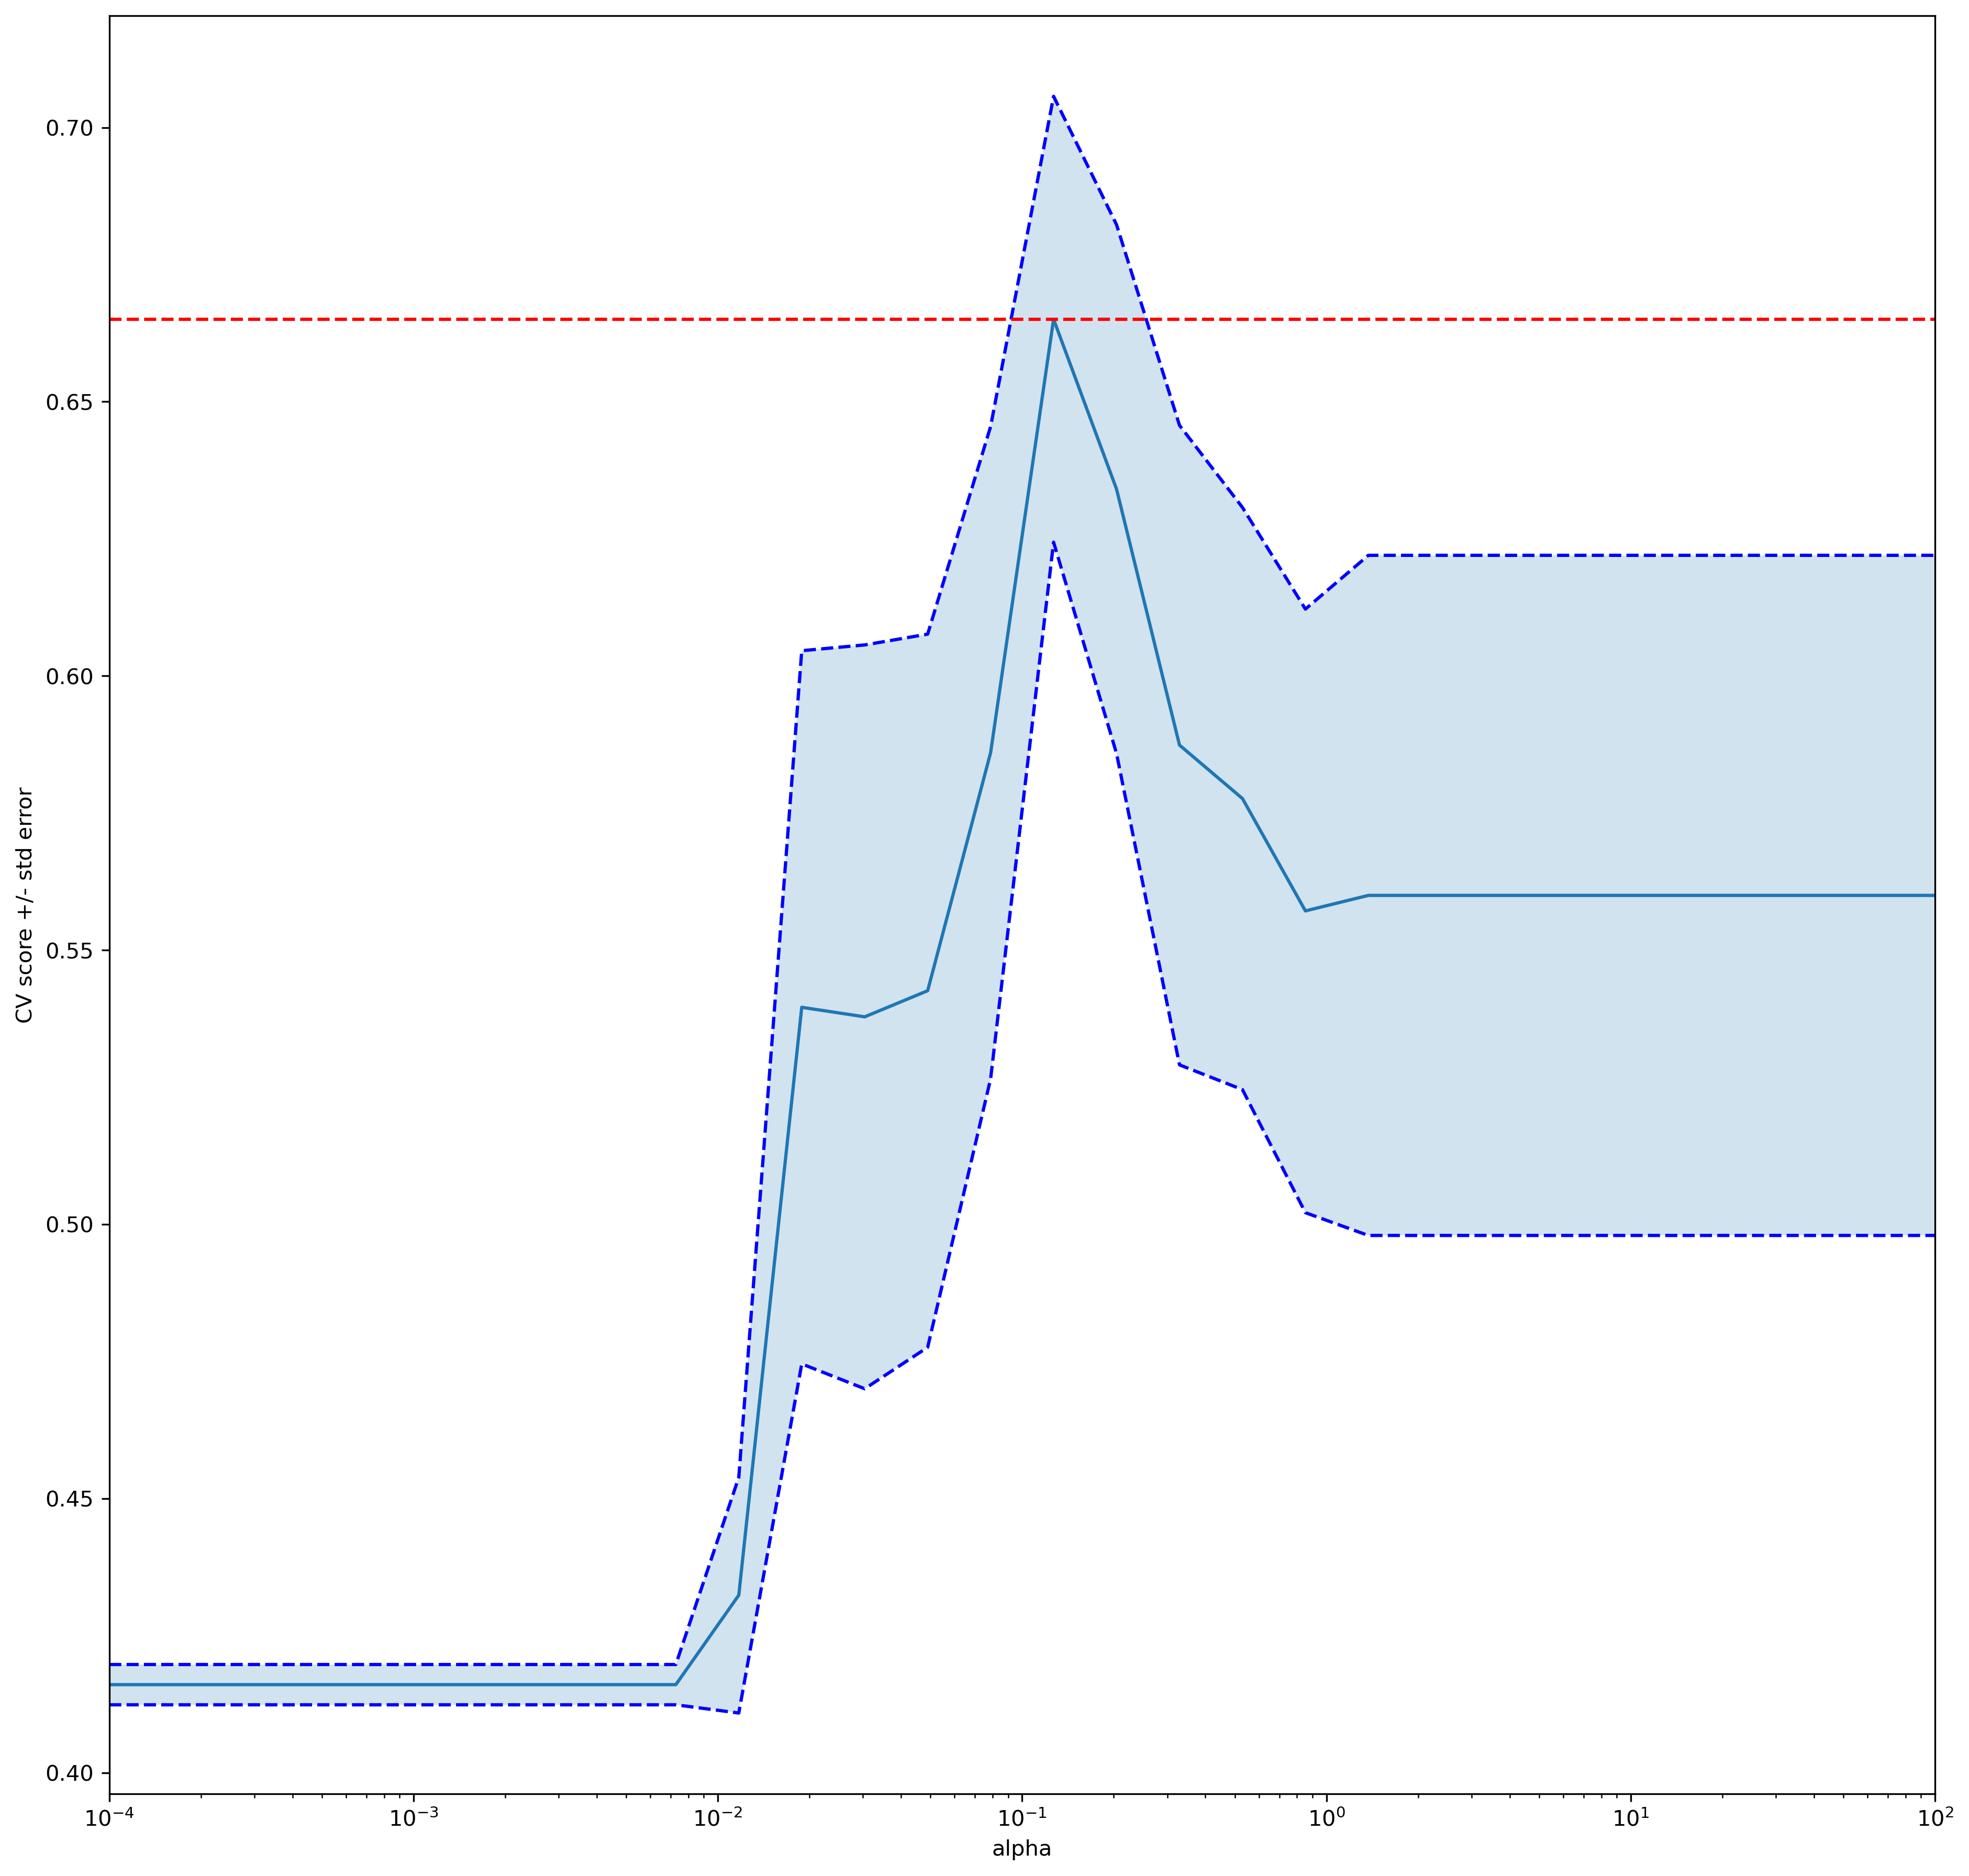

In [308]:
# add consults information
df6 = pd.merge(clean_df4,consult_dept_df_labeled,on=['PtSSN','label'])

X = df6[df6.columns[2:]]
y = np.array([1 if x=='MOD' else 0 for x in df6['label']])

clf = tune_model(X,y)


(94, 45) (94,)
AUC =  0.7245421245421246 0.09974272208011603
F1 =  0.6650313479623826 0.09089339462082305
Accuracy =  0.7549707602339181 0.05511986745238913
Confusion matrix:
[[62  5]
 [15 12]]
10  features chosen by L1 model.


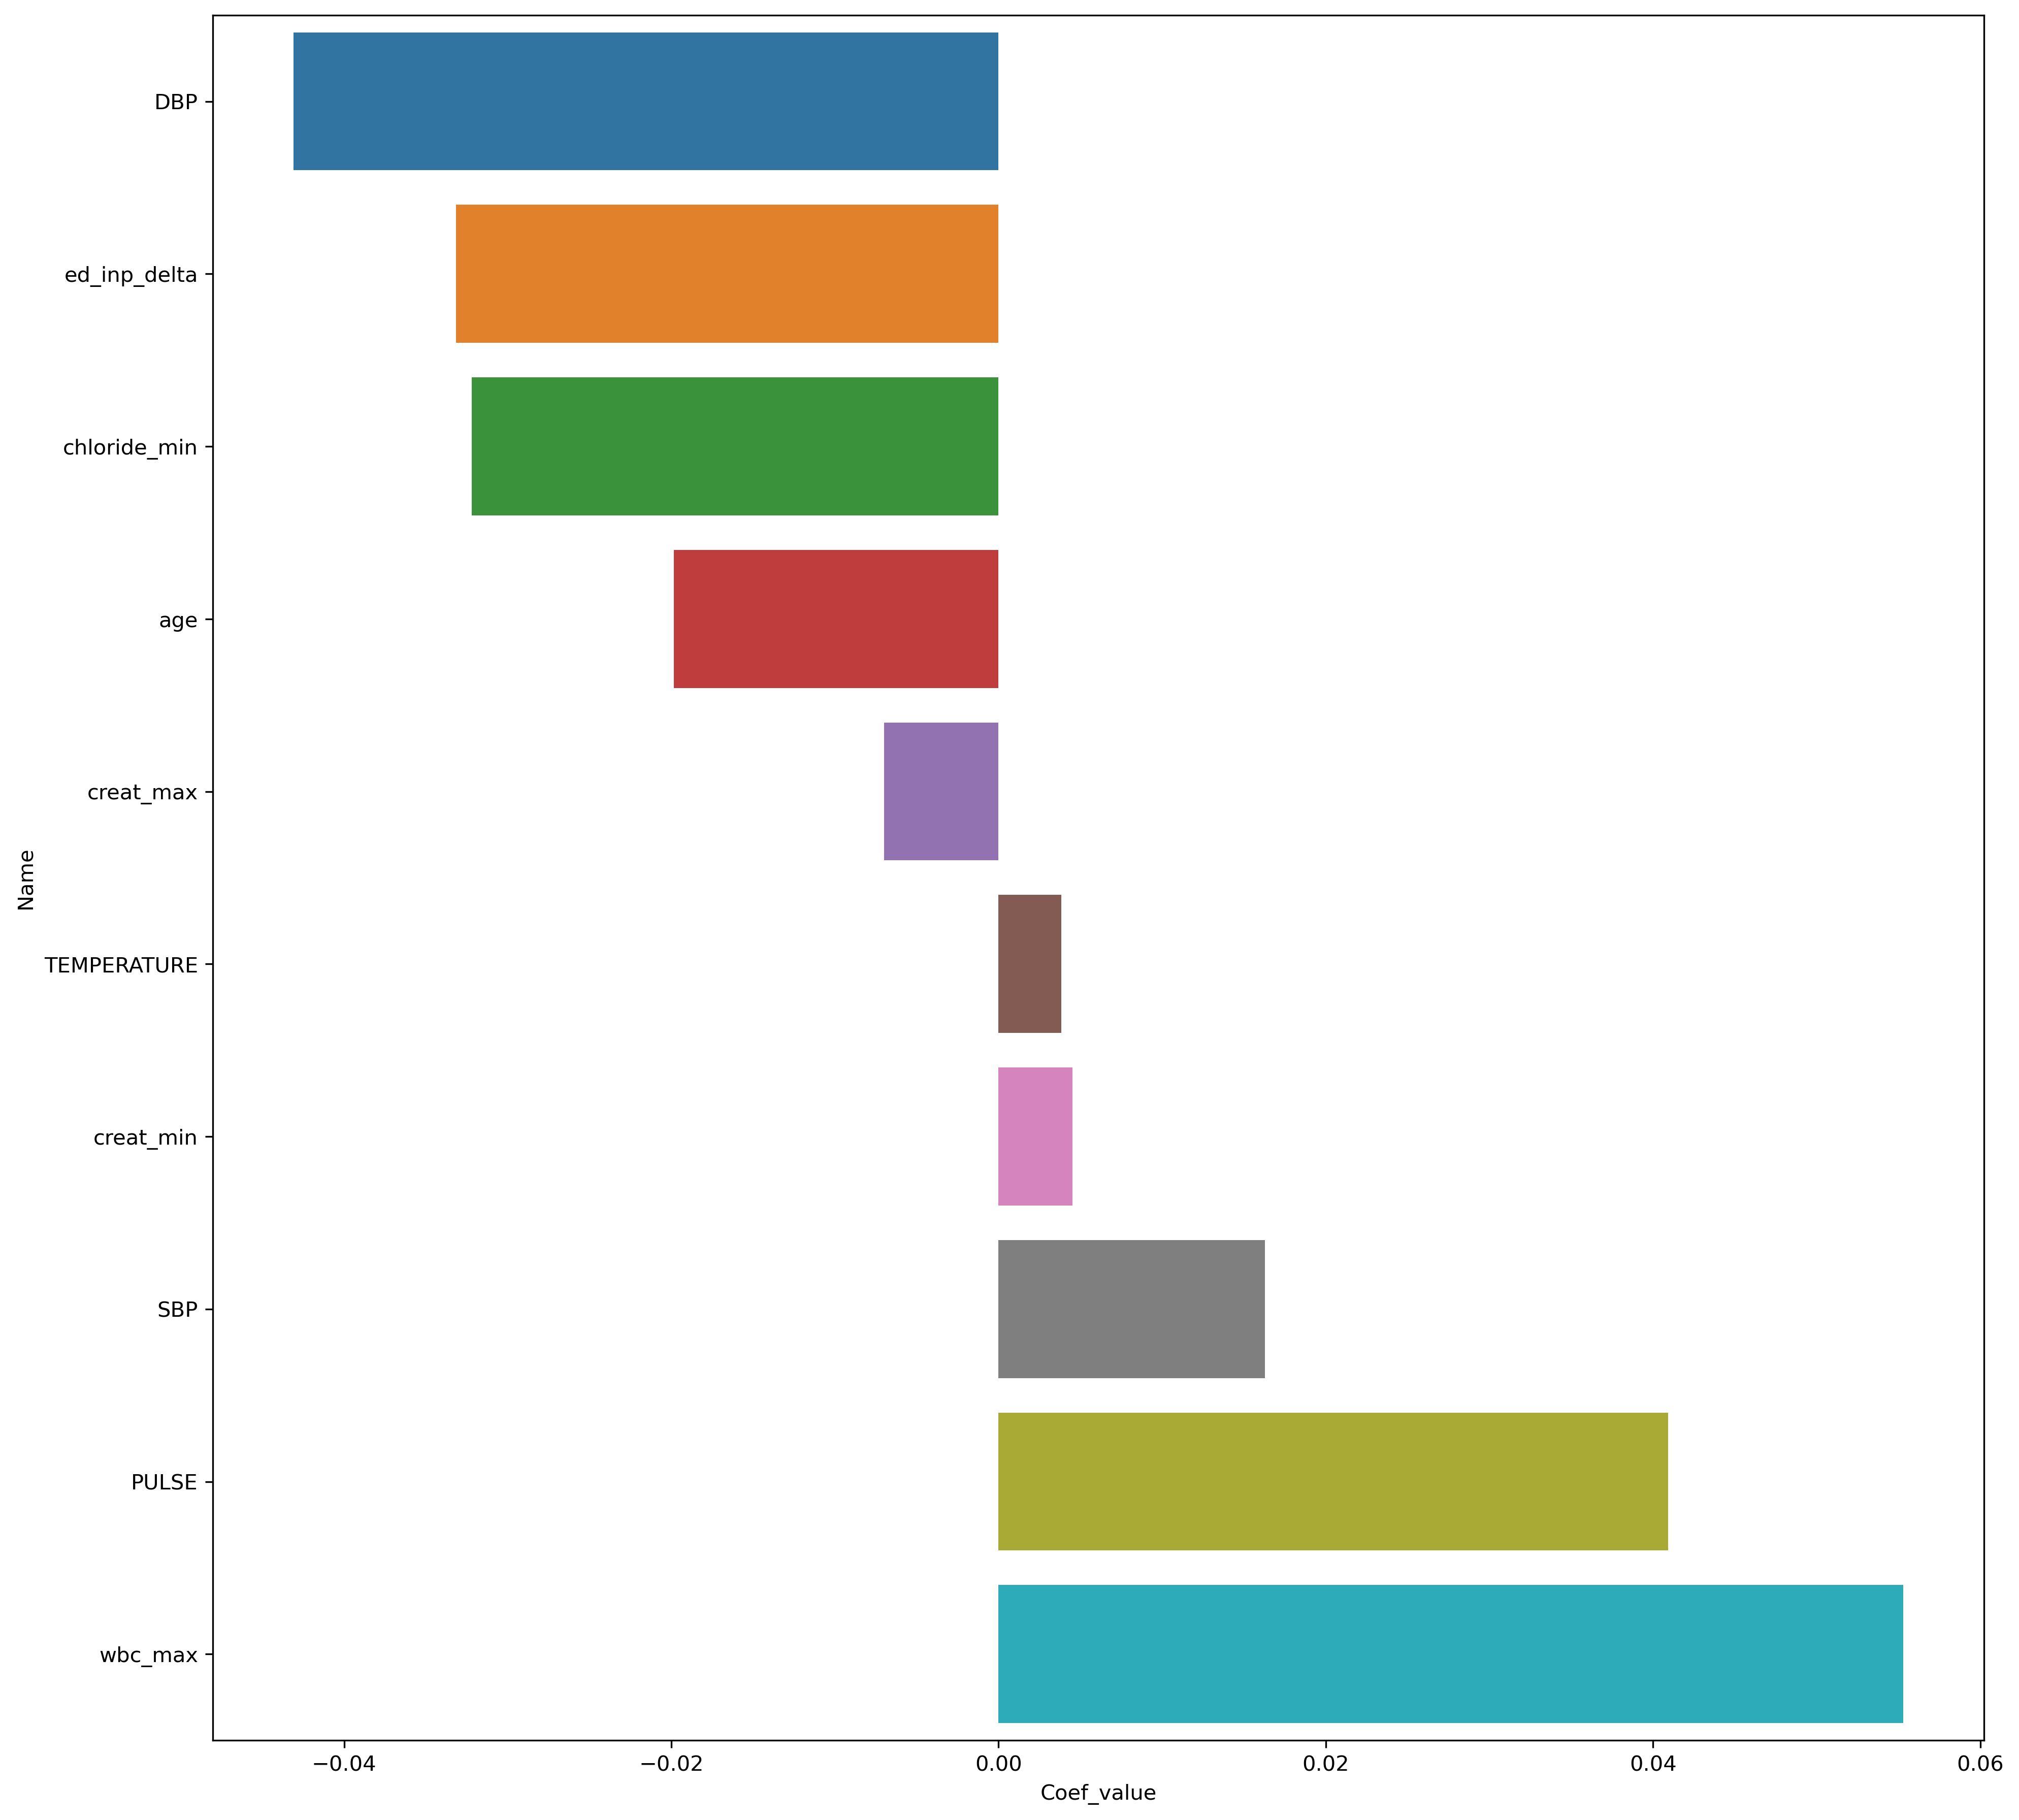

In [309]:
clf,select_feats = build_L1_model(X,y,clf.best_params_['C'])
visualize_model(clf,select_feats)

# Medications in ER
- were antibiotics prescribed?


In [ ]:

antibiotics_df_labeled.rename(columns={0:'antibiotics'},inplace=True)
antibiotics_df_labeled.head()

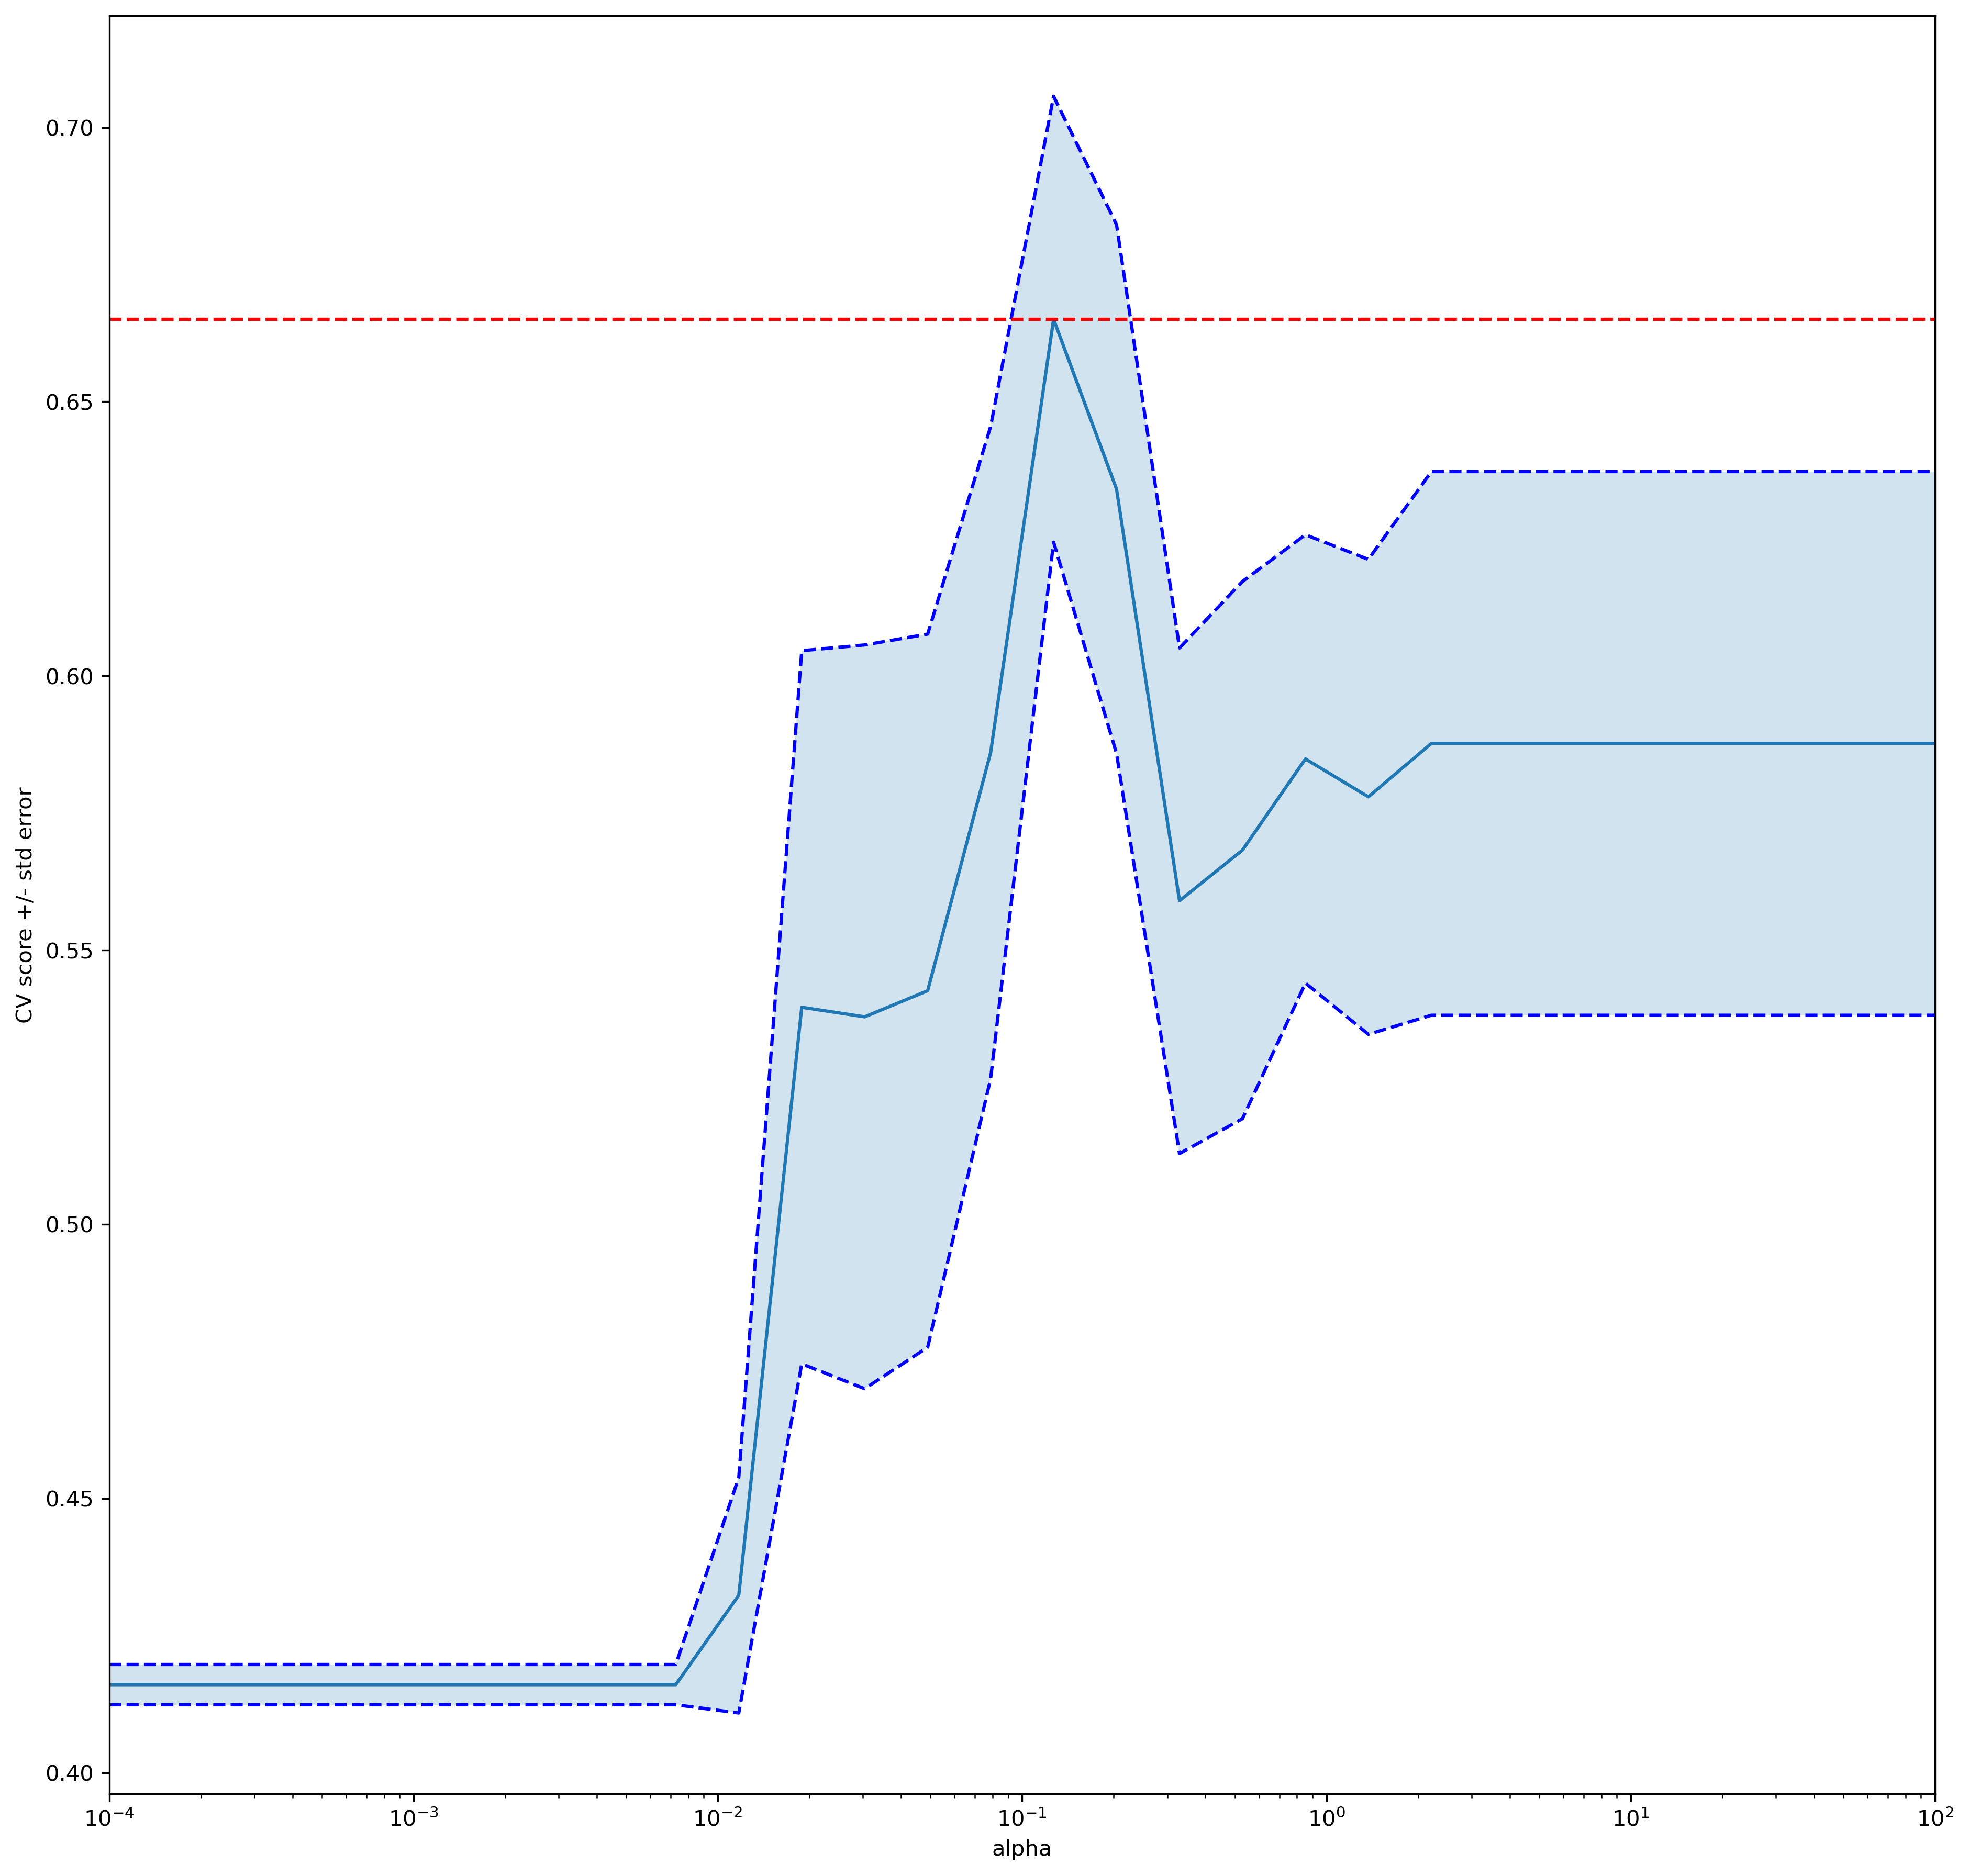

In [310]:
df6 = pd.merge(clean_df4,antibiotics_df_labeled,on=['PtSSN','label'])
df6['SIRS'] = df6.apply(lambda x: meets_sirs(x),axis=1)

X = df6[df6.columns[2:]]
y = np.array([1 if x=='MOD' else 0 for x in df6['label']])

clf = tune_model(X,y)


(94, 40) (94,)
AUC =  0.7245421245421246 0.09974272208011603
F1 =  0.6650313479623826 0.09089339462082305
Accuracy =  0.7549707602339181 0.05511986745238913
Confusion matrix:
[[62  5]
 [15 12]]
10  features chosen by L1 model.


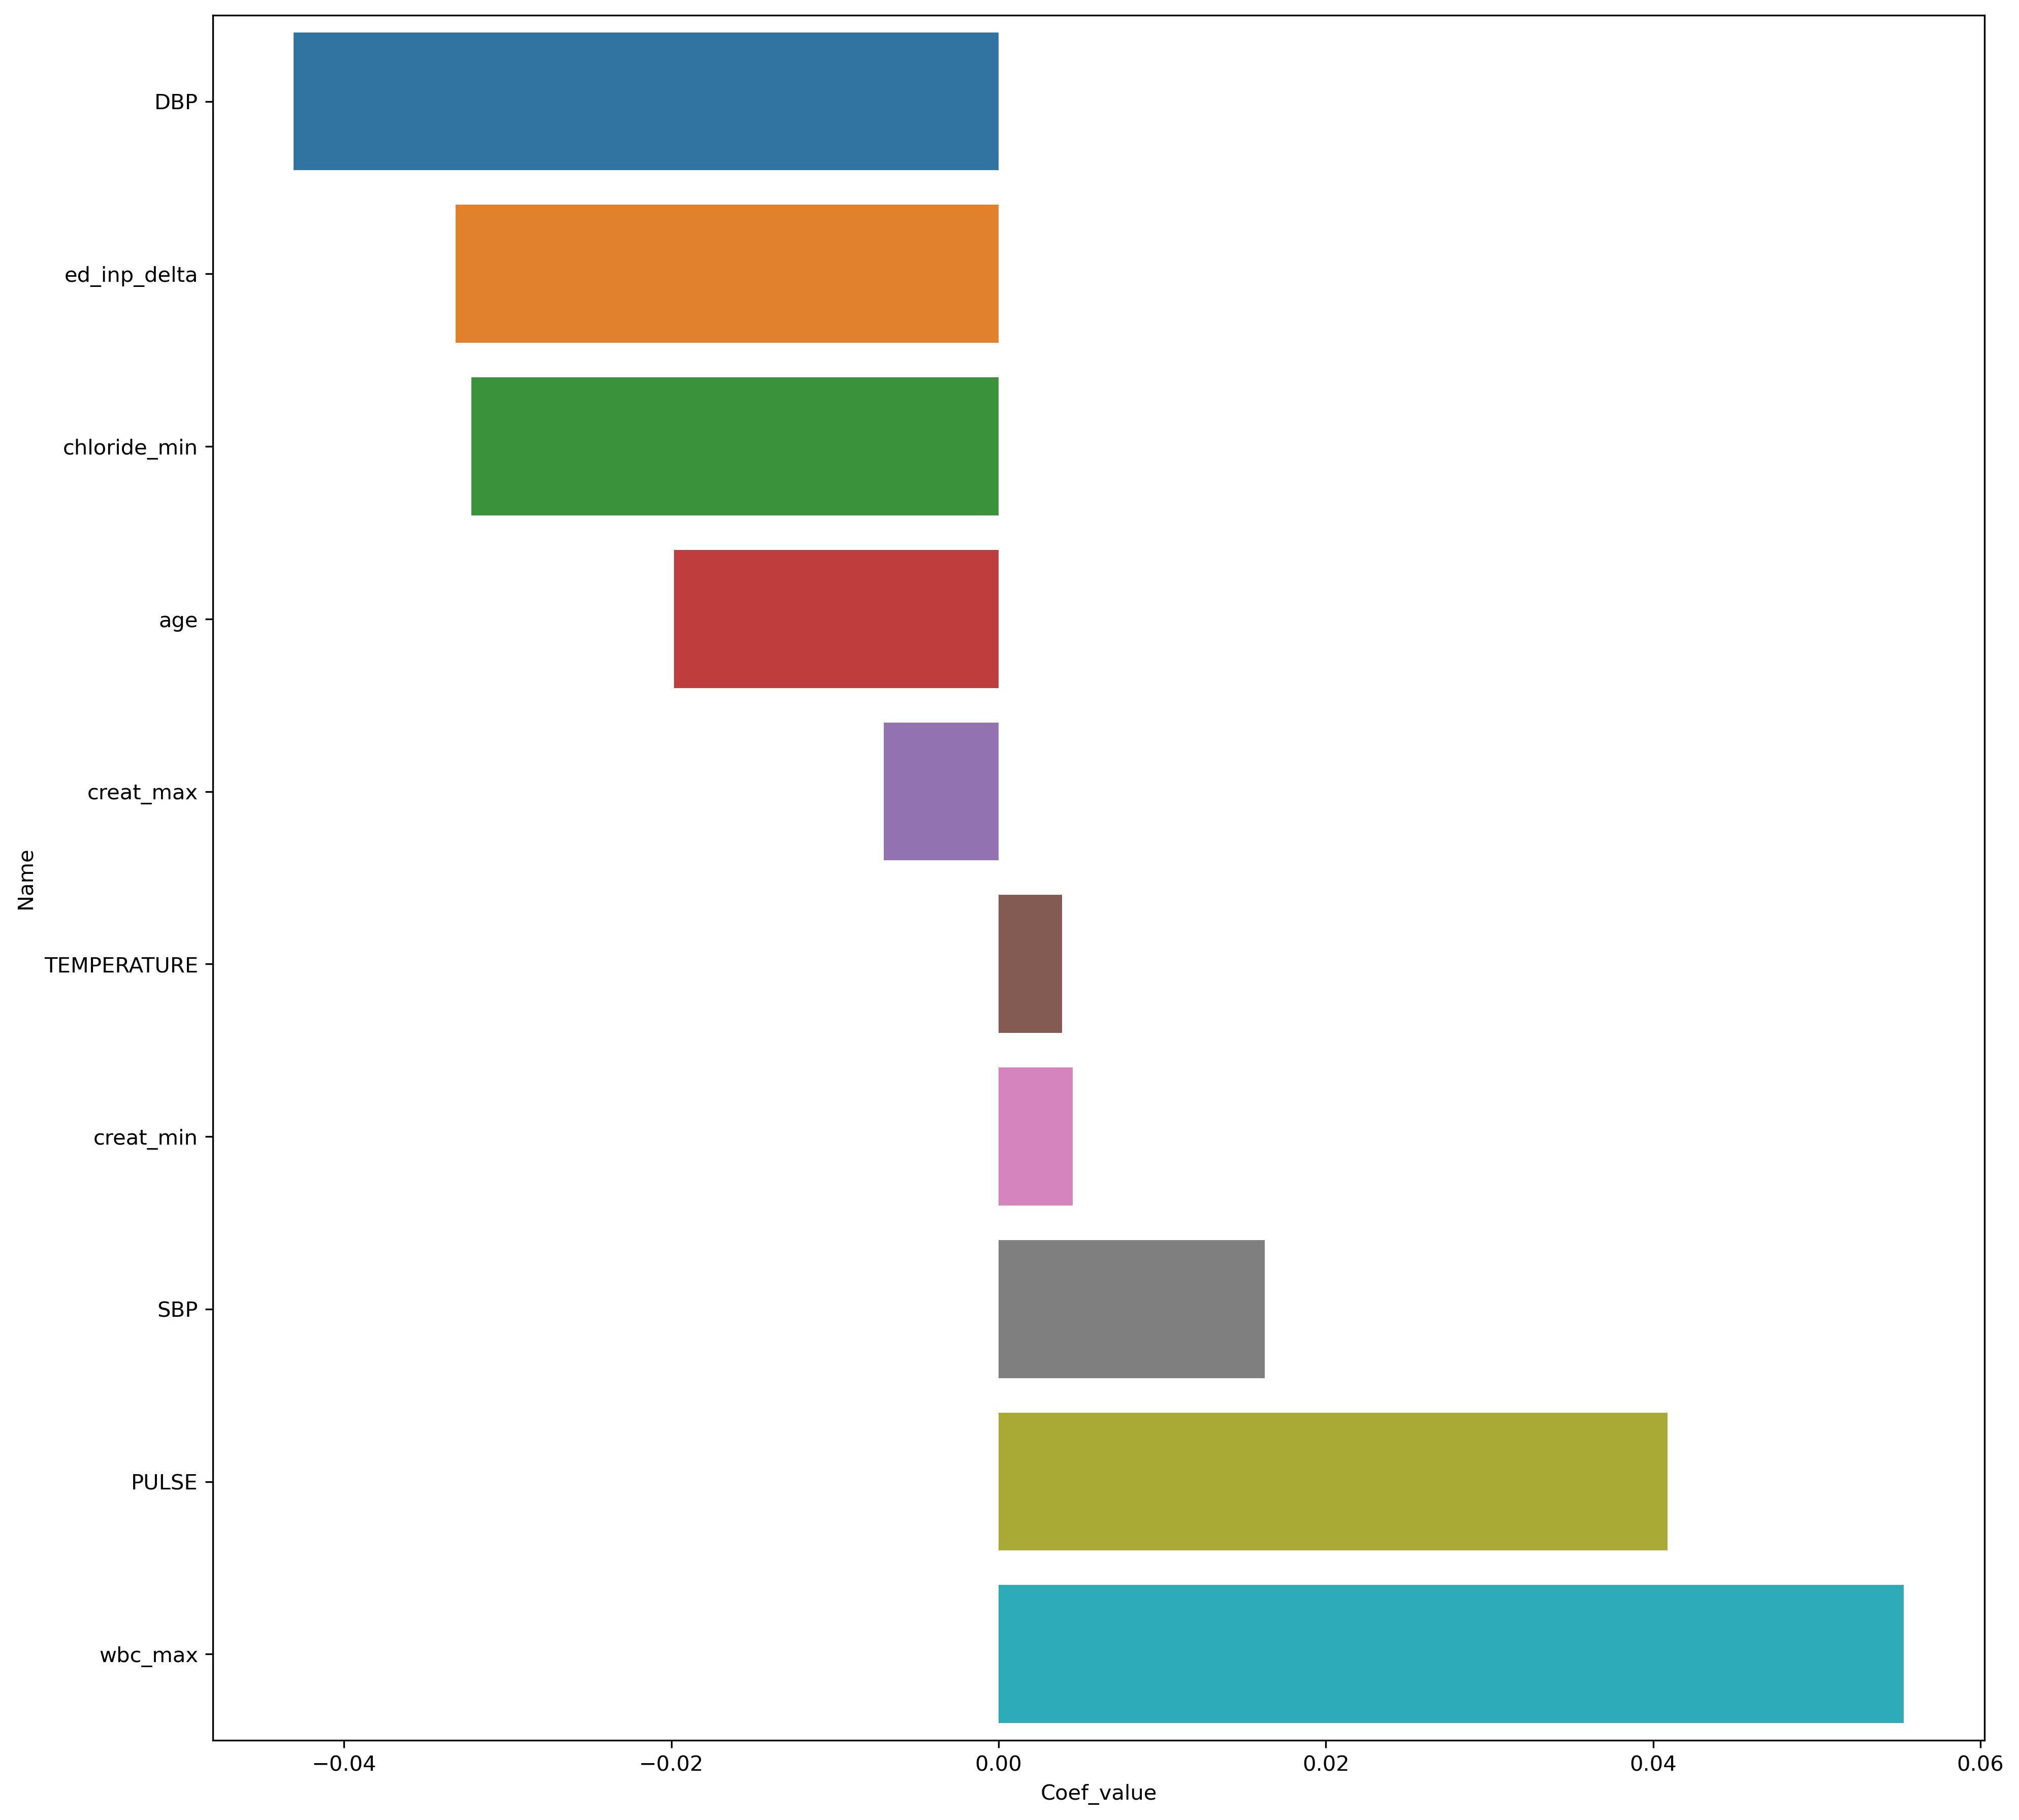

In [311]:
clf,select_feats = build_L1_model(X,y,clf.best_params_['C'])
visualize_model(clf,select_feats)

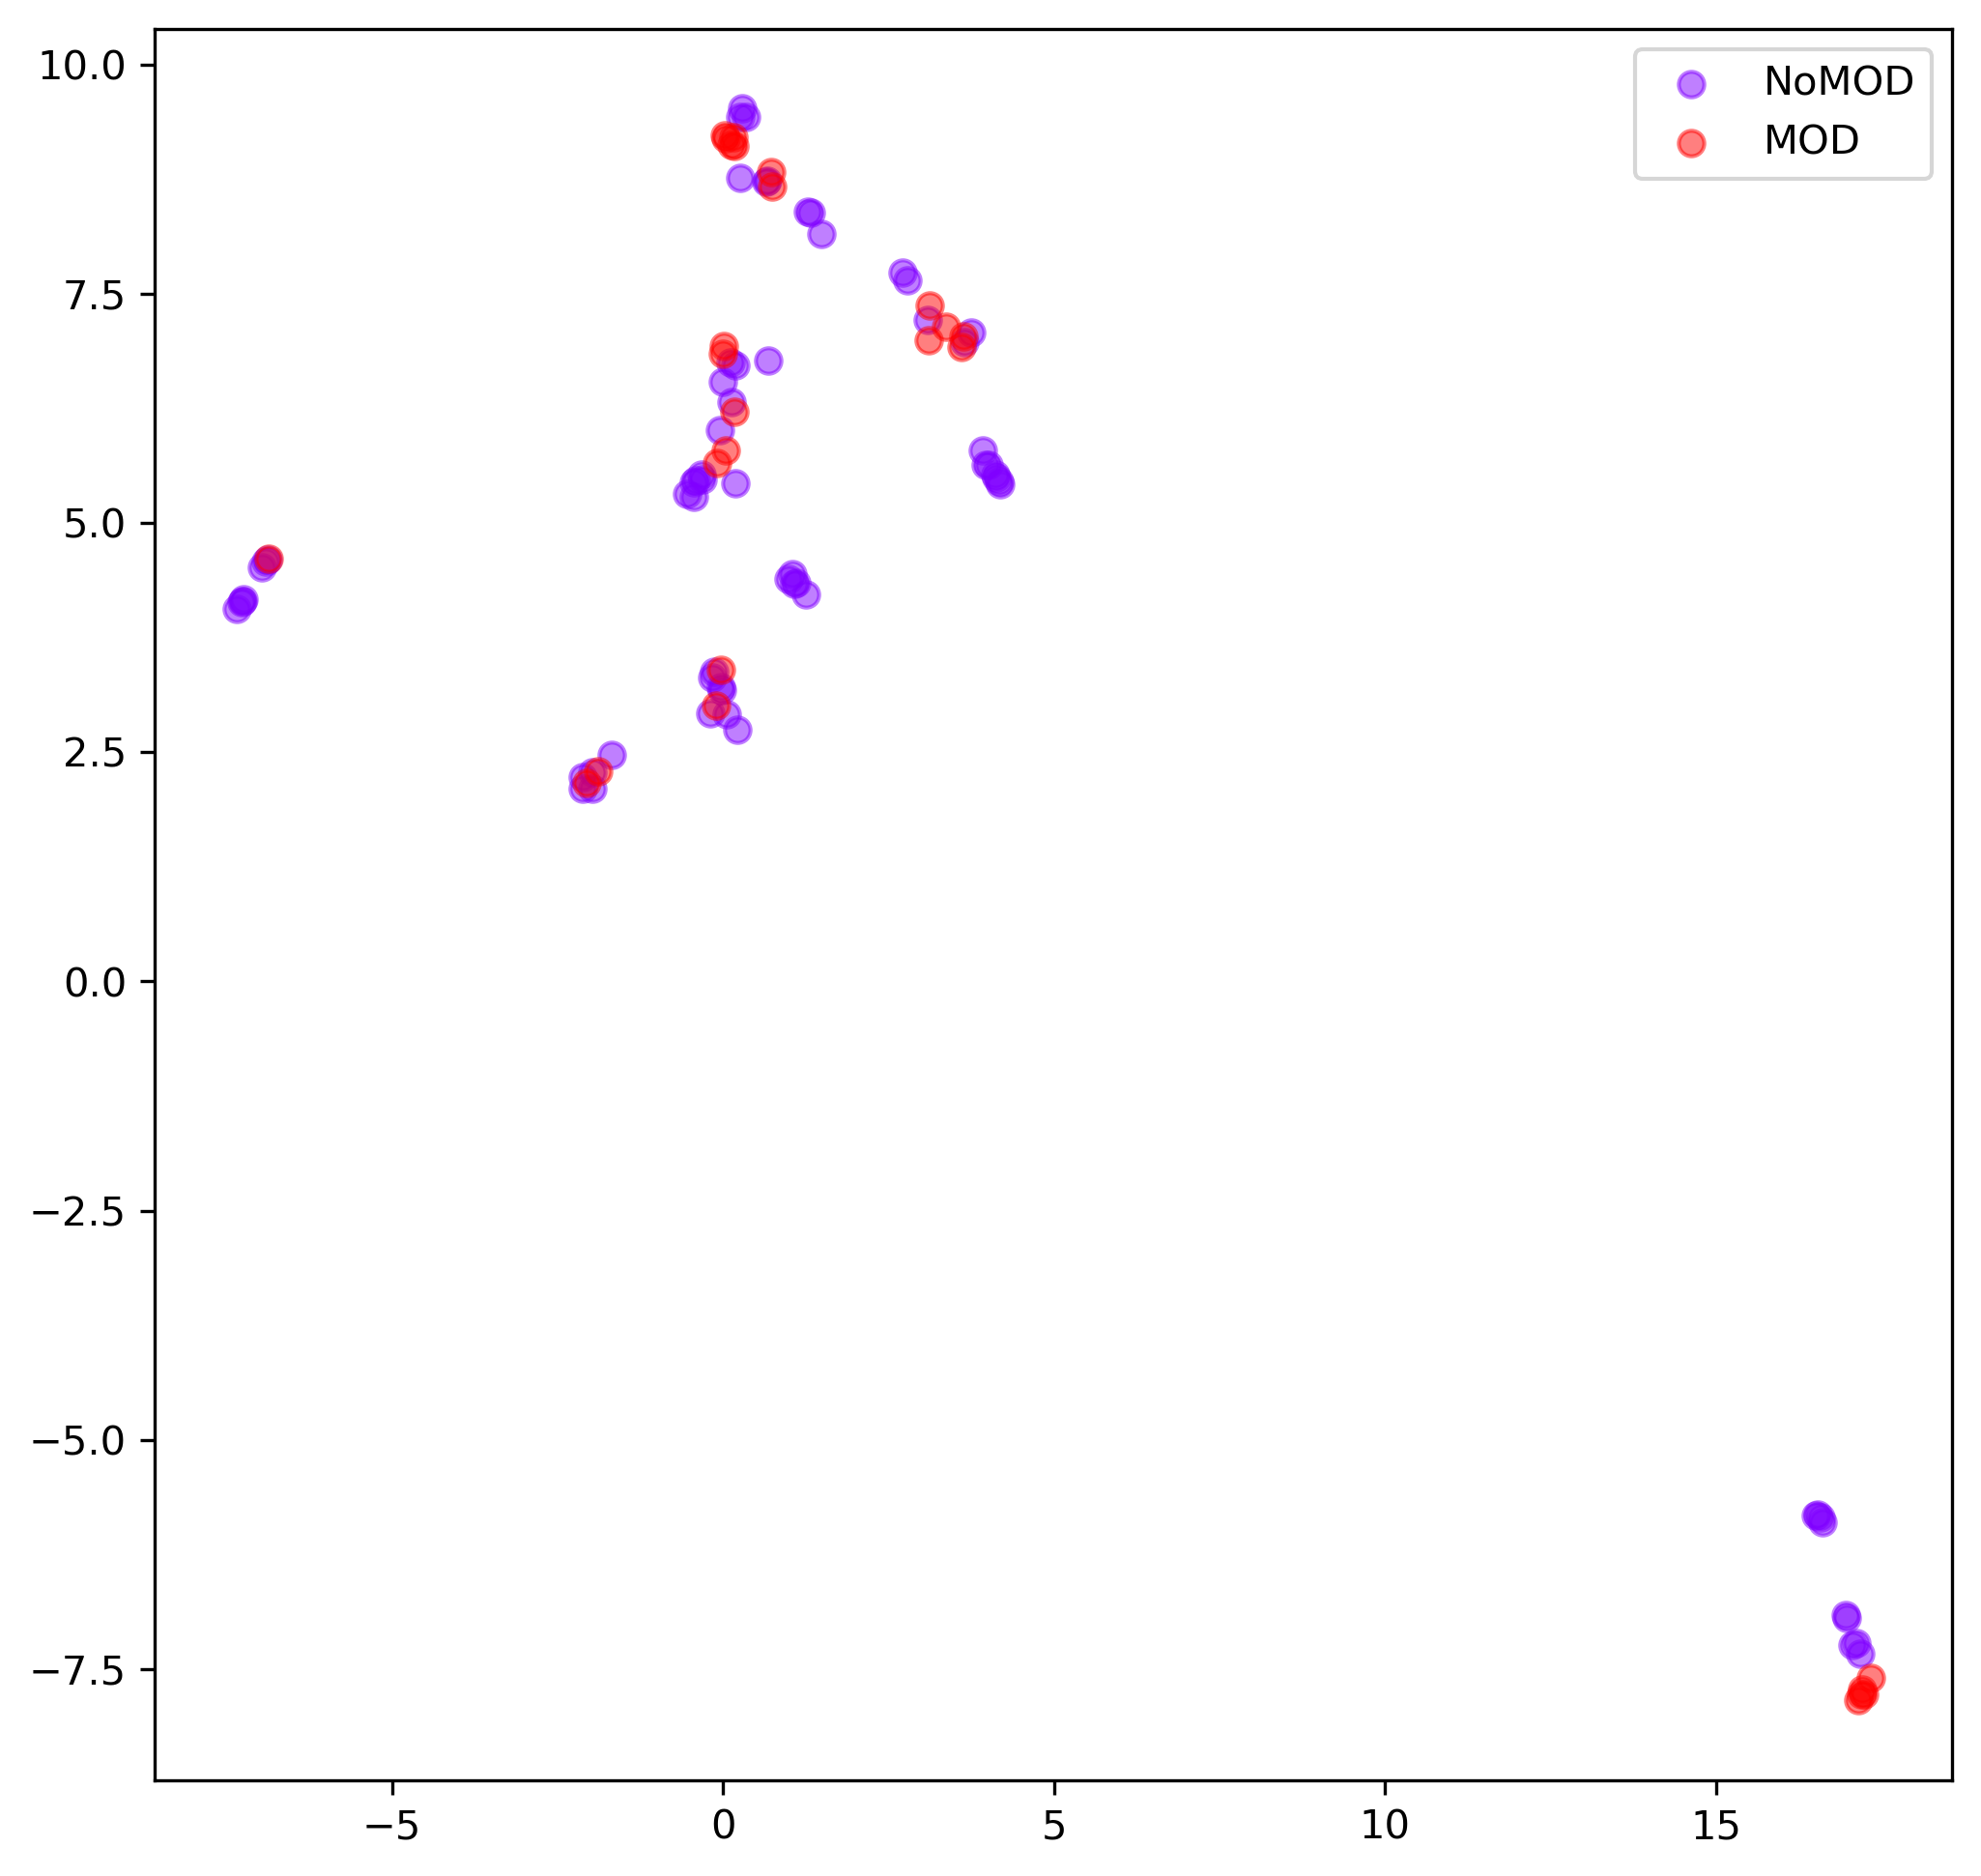

In [312]:
umap_plot_label(X[select_feats],y,1,7,['NoMOD','MOD']);

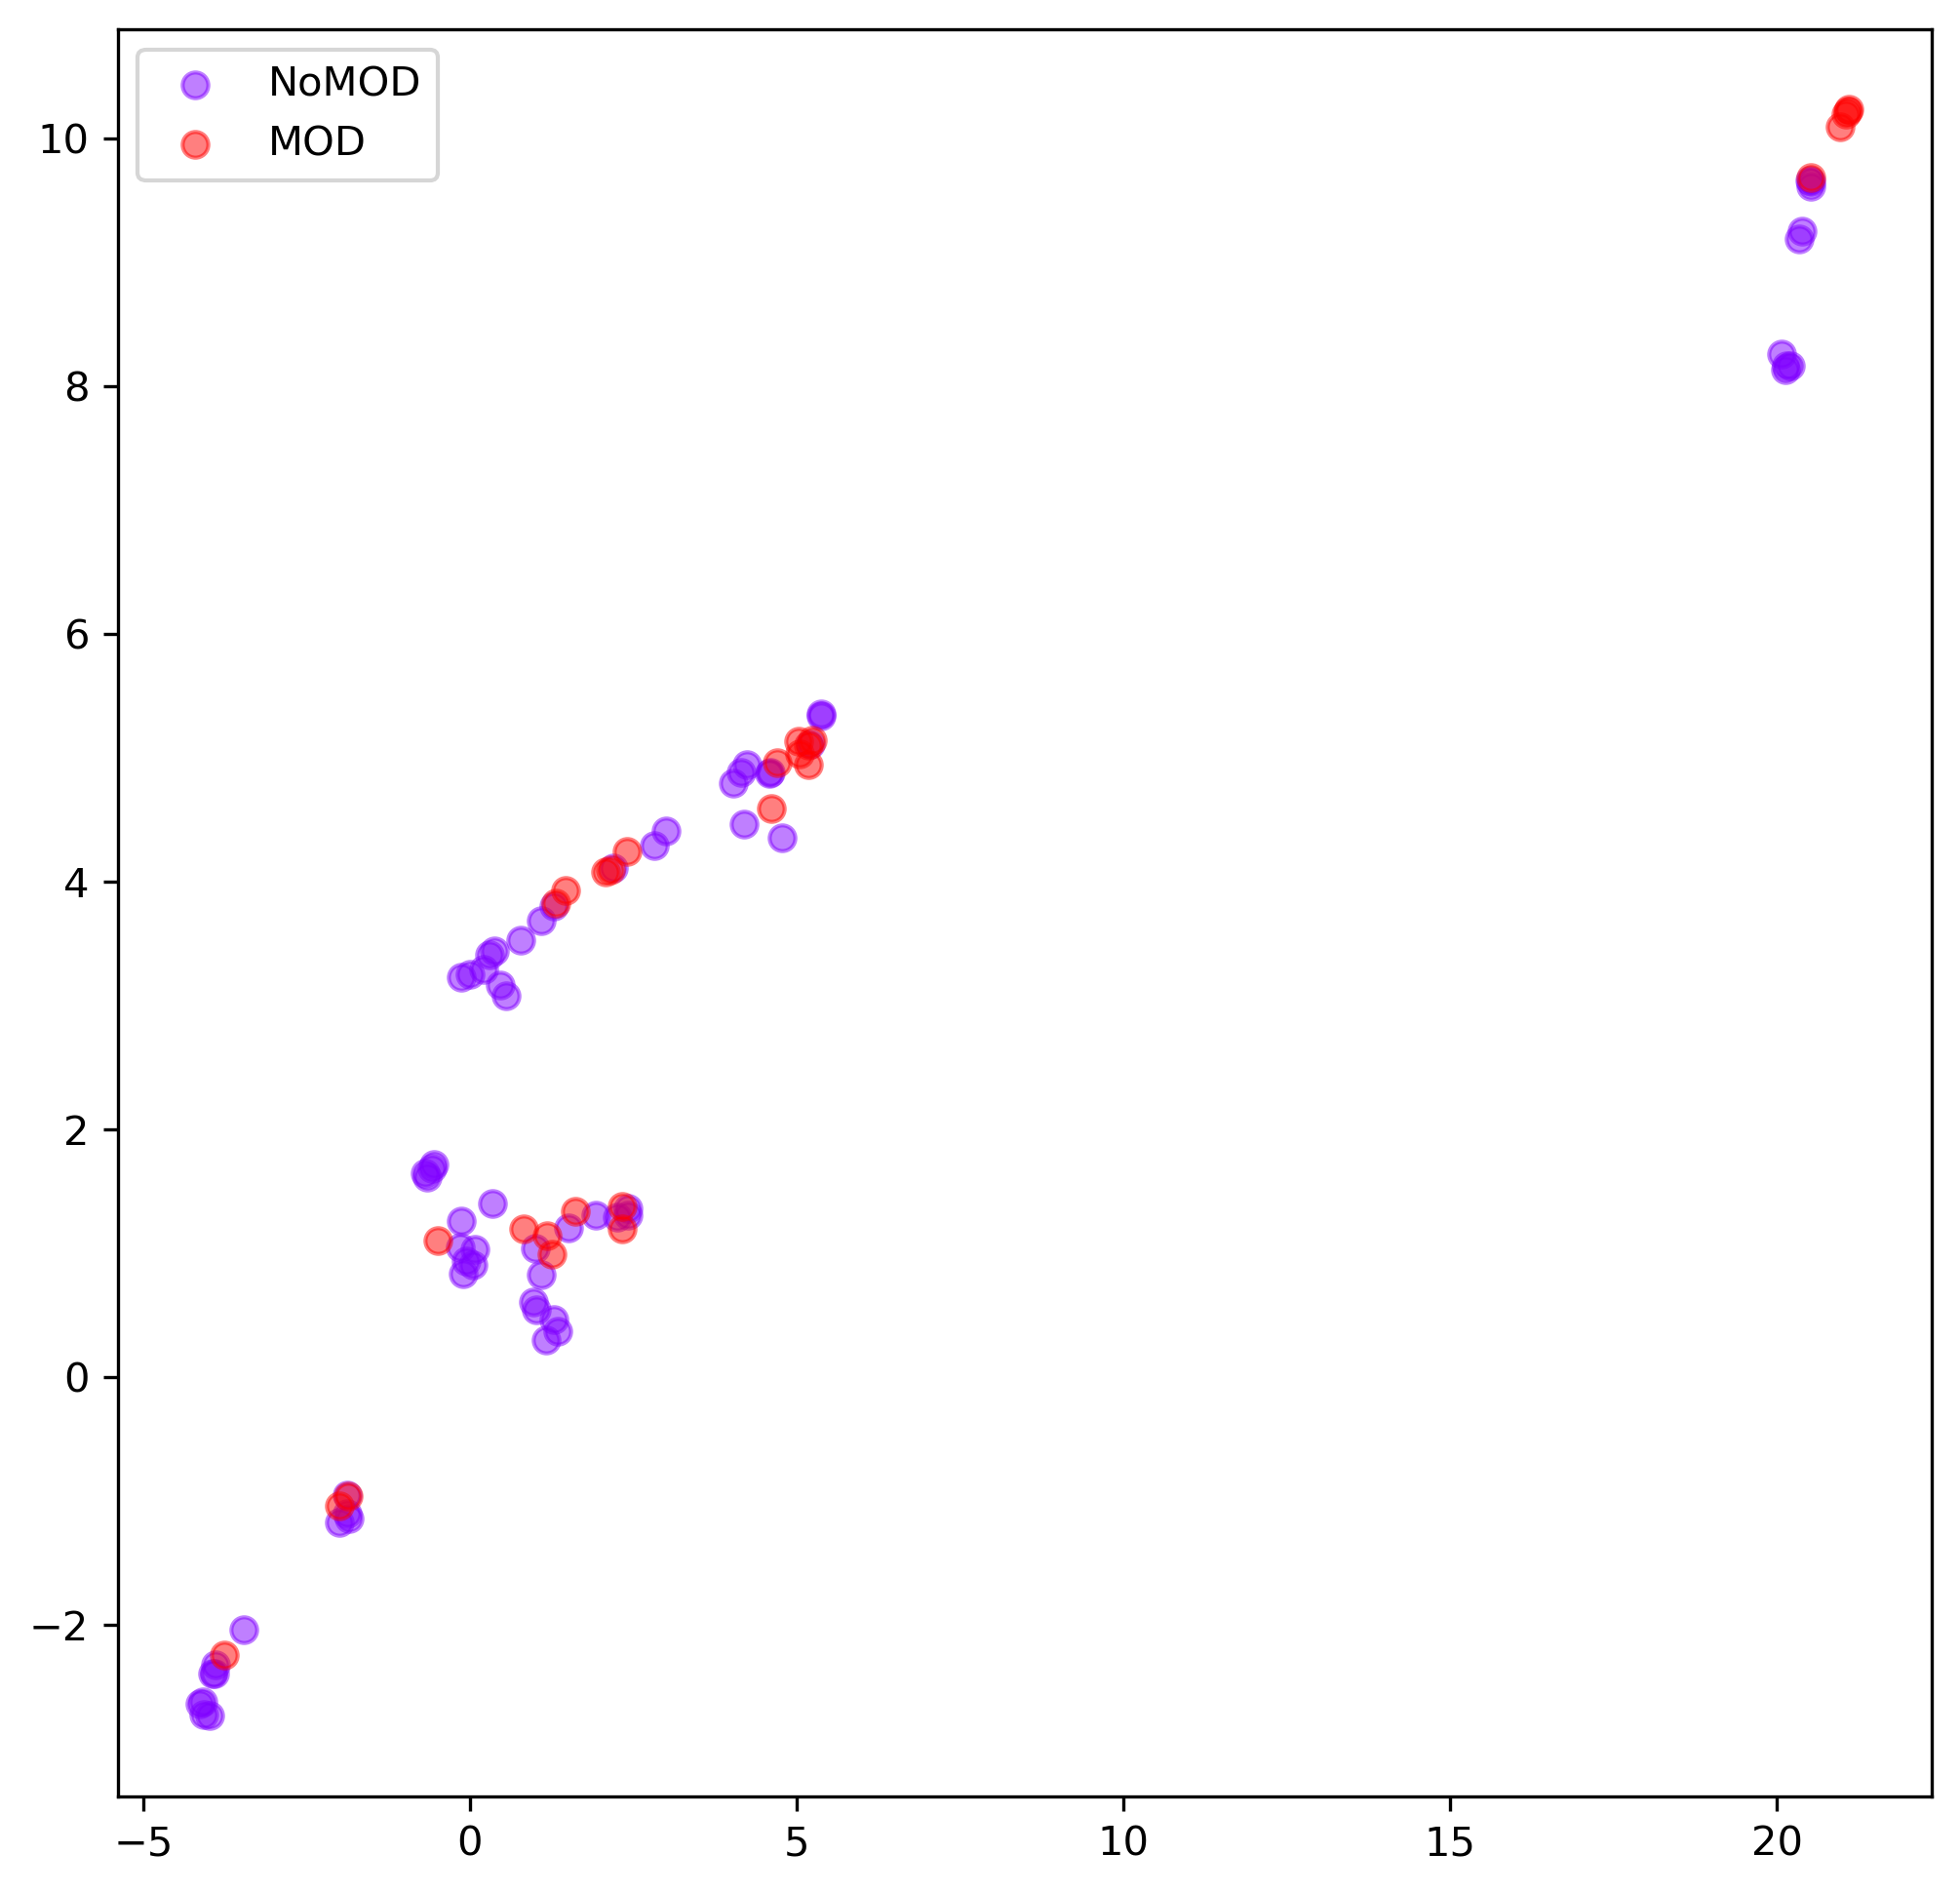

In [313]:
umap_plot_label(X,y,1,7,['NoMOD','MOD']);

In [314]:
# which MODs are we unable to pick up with this model?
ypred = clf.predict(X)
mistakes = df6.iloc[(ypred==0) & (y==1)].PtSSN

In [ ]:
abpain_df[abpain_df.PtSSN.isin(mistakes)][['PtSSN','CaseSummaryER']]

In [ ]:
df6[df6.PtSSN==nnnnnnn]

In [189]:
# when were antibiotics started? at first visit or a subsequent visit


Index(['PtSSN', 'label', 'age', 'ed_duration', 'ed_inp_delta', 'visits',
       'new_race_ALASKA/PACIFIC', 'new_race_ASIAN',
       'new_race_BLACK OR AFRICAN AMERICAN', 'new_race_UNKNOWN',
       'new_race_WHITE', 'Gender', 'Ethnicity', 'sodium_min', 'sodium_max',
       'potassium_min', 'potassium_max', 'chloride_min', 'chloride_max',
       'creat_min', 'creat_max', 'lactate_count', 'troponin_count',
       'amylase_count', 'urine_count', 'PULSE', 'TEMPERATURE', 'SBP', 'DBP',
       'RESPIRATION', 'num_xr', 'num_abnormal_xr', 'num_ct', 'num_abnormal_ct',
       'num_contrast', 'num_us', 'PMHMentalHealth', 'GENERAL SURGERY', 'EKG',
       'CHART CONSULT', 'UROLOGY CLINIC', 'GASTROENTEROLOGY', 'GI ENDOSCOPY',
       'CARDIOLOGY'],
      dtype='object')

In [282]:
# add diagnosis at discharge from ED fields

df7 = pd.merge(df6,icd_dx_labeled_df,on=['PtSSN','label'])

X = df7[df7.columns[2:]]
y = np.array([1 if x=='MOD' else 0 for x in df7['label']])

# best value for C is 0.1
for C in np.arange(0.1,1.1,0.1):
    print('-------------------- C = ', C)
    build_L1_model(X,y,C)


-------------------- C =  0.1
(122, 47) (122,)
AUC =  0.6270877100840335 0.1720725644548781
F1 =  0.6077264824633245 0.12519061018605612
Accuracy =  0.7286666666666666 0.0787781695649245
Confusion matrix:
[[79  5]
 [23 15]]
9  features chosen by L1 model.
-------------------- C =  0.2
(122, 47) (122,)
AUC =  0.6306066176470588 0.17685955165804443
F1 =  0.5480274012109698 0.13831294034982167
Accuracy =  0.688 0.10631922581442069
Confusion matrix:
[[81  3]
 [22 16]]
11  features chosen by L1 model.
-------------------- C =  0.30000000000000004
(122, 47) (122,)
AUC =  0.6328256302521008 0.1701311364116657
F1 =  0.5536786568622255 0.13696801531841996
Accuracy =  0.696 0.10075603097471525
Confusion matrix:
[[81  3]
 [23 15]]
16  features chosen by L1 model.
-------------------- C =  0.4
(122, 47) (122,)
AUC =  0.6271271008403361 0.15881158842277407
F1 =  0.5424718456554143 0.14051146692996772
Accuracy =  0.6799999999999999 0.1138761510491893
Confusion matrix:
[[81  3]
 [23 15]]
20  features

(122, 47) (122,)
AUC =  0.634860819327731 0.1699745717025522
F1 =  0.6077264824633245 0.12519061018605612
Accuracy =  0.7286666666666666 0.0787781695649245
Confusion matrix:
[[79  5]
 [23 15]]
9  features chosen by L1 model.


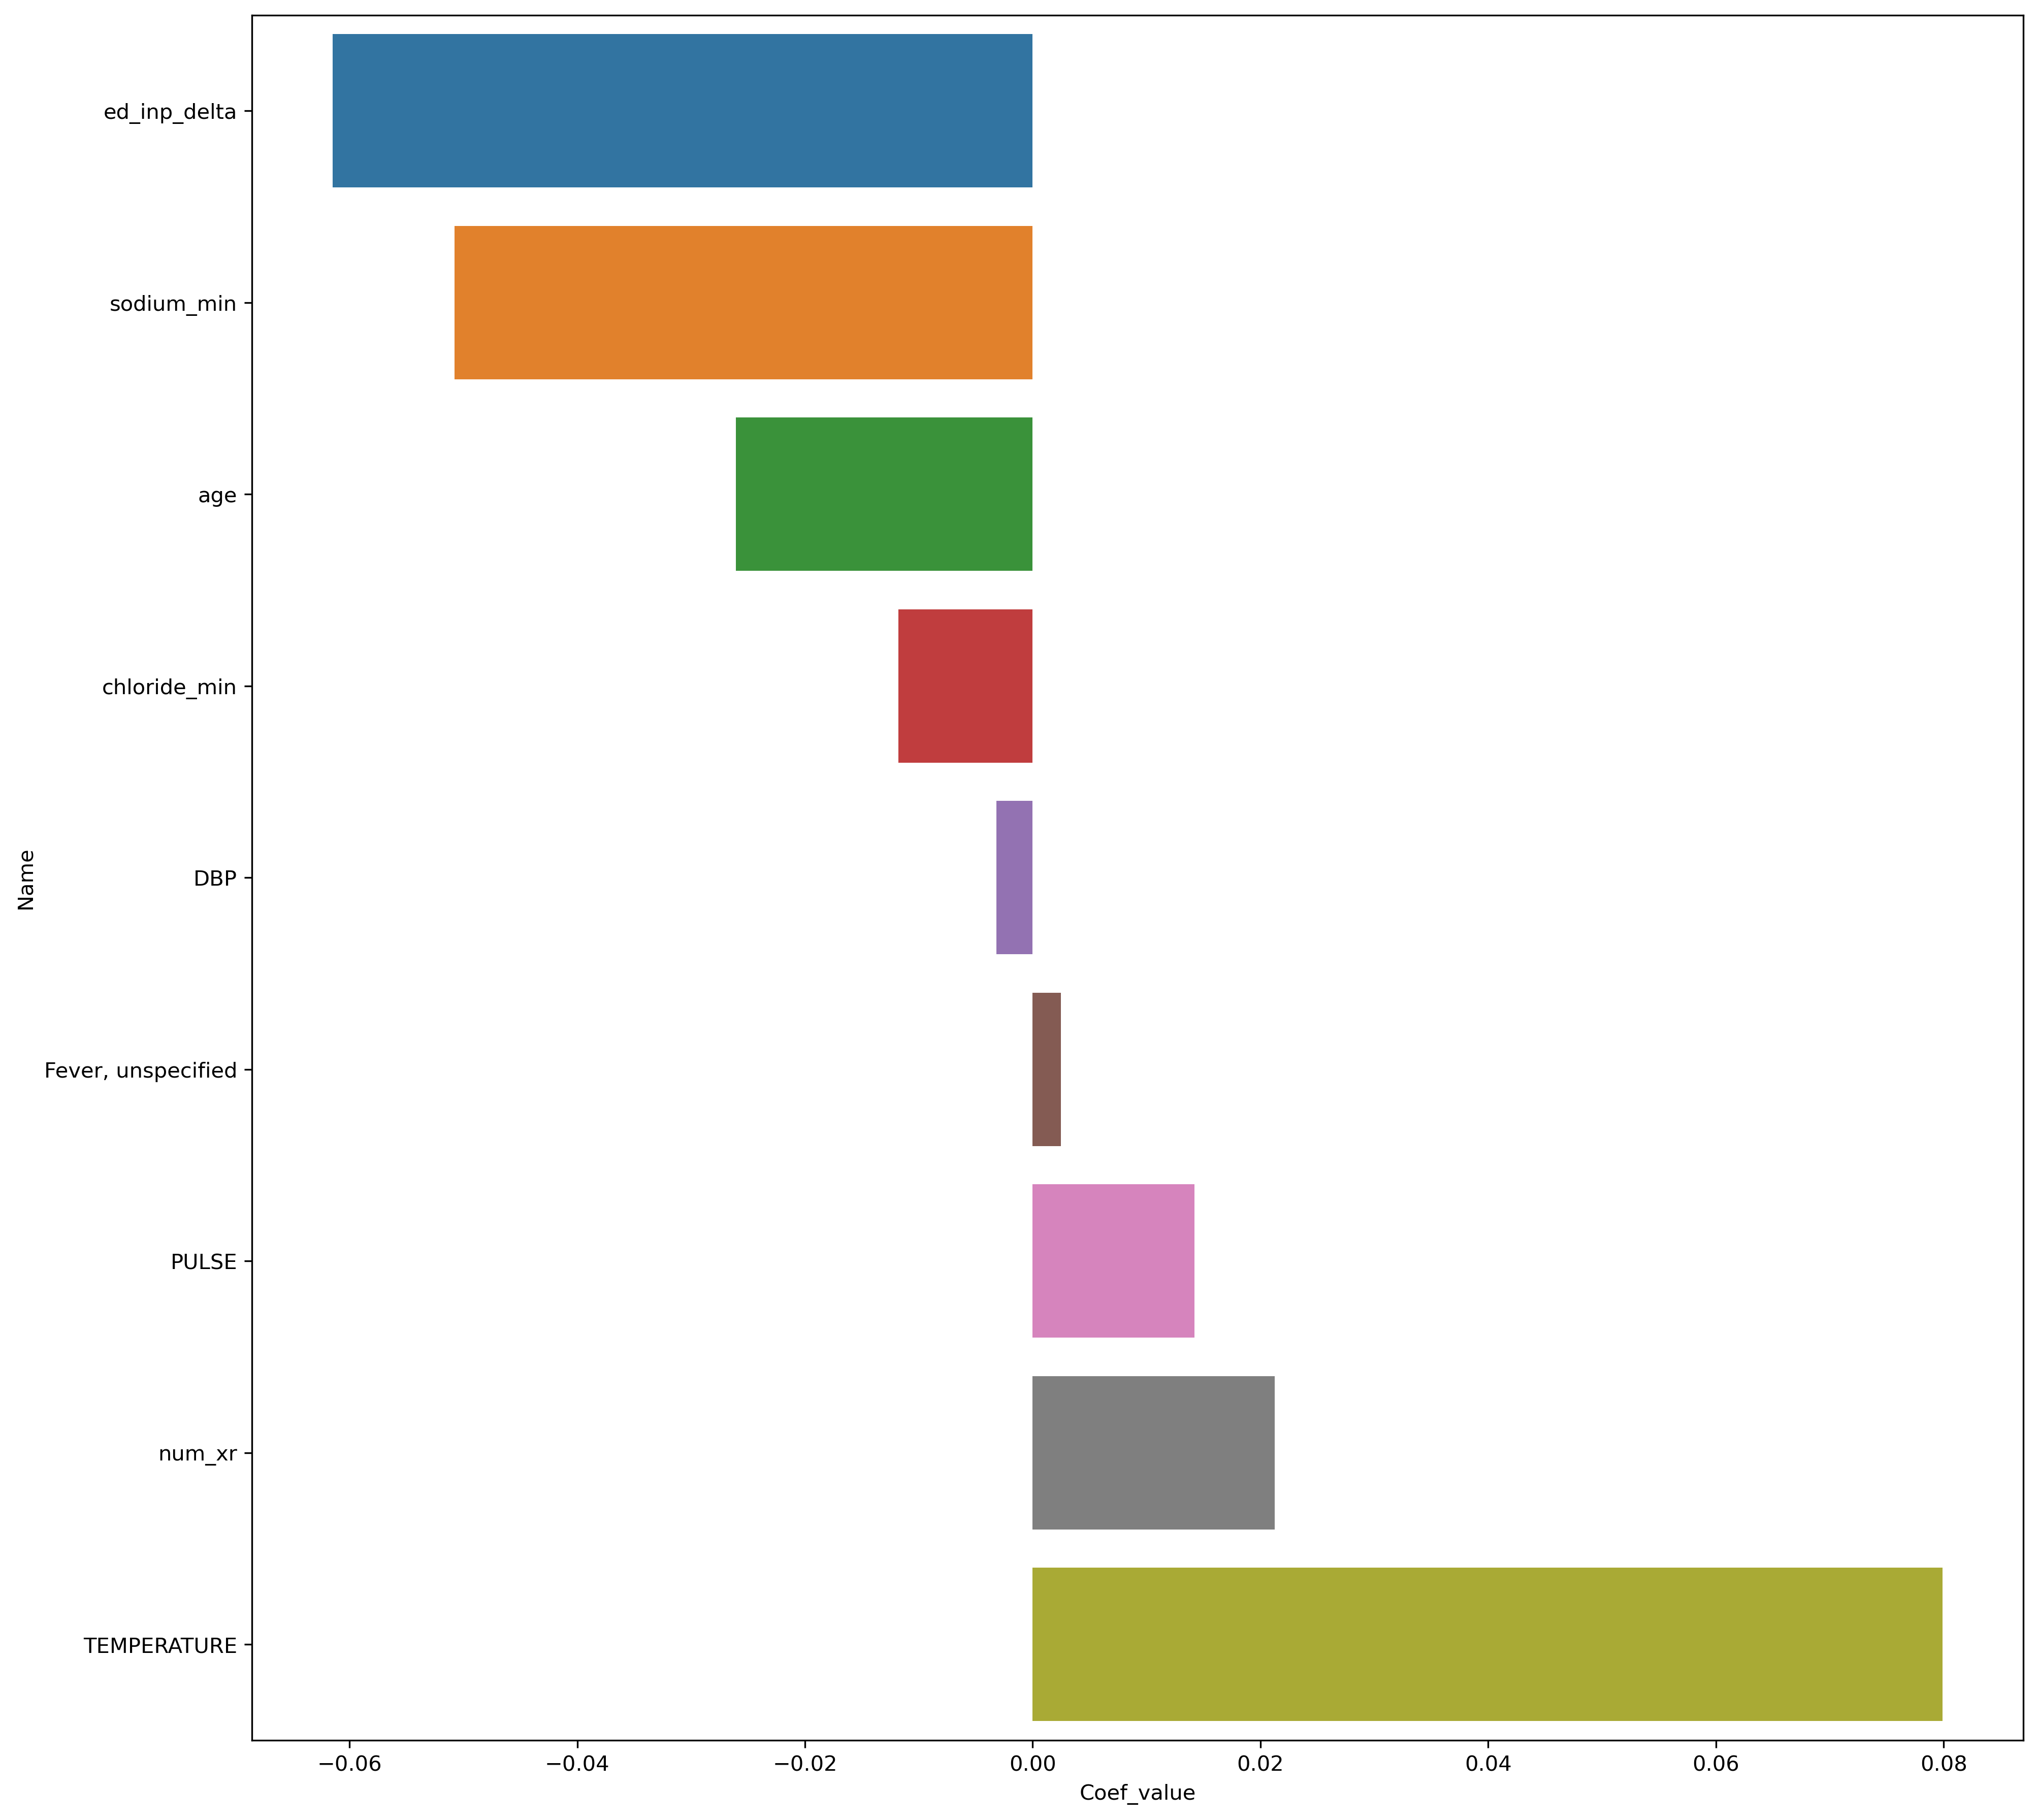

In [285]:
clf,select_feats = build_L1_model(X,y,0.09)
visualize_model(clf,select_feats)

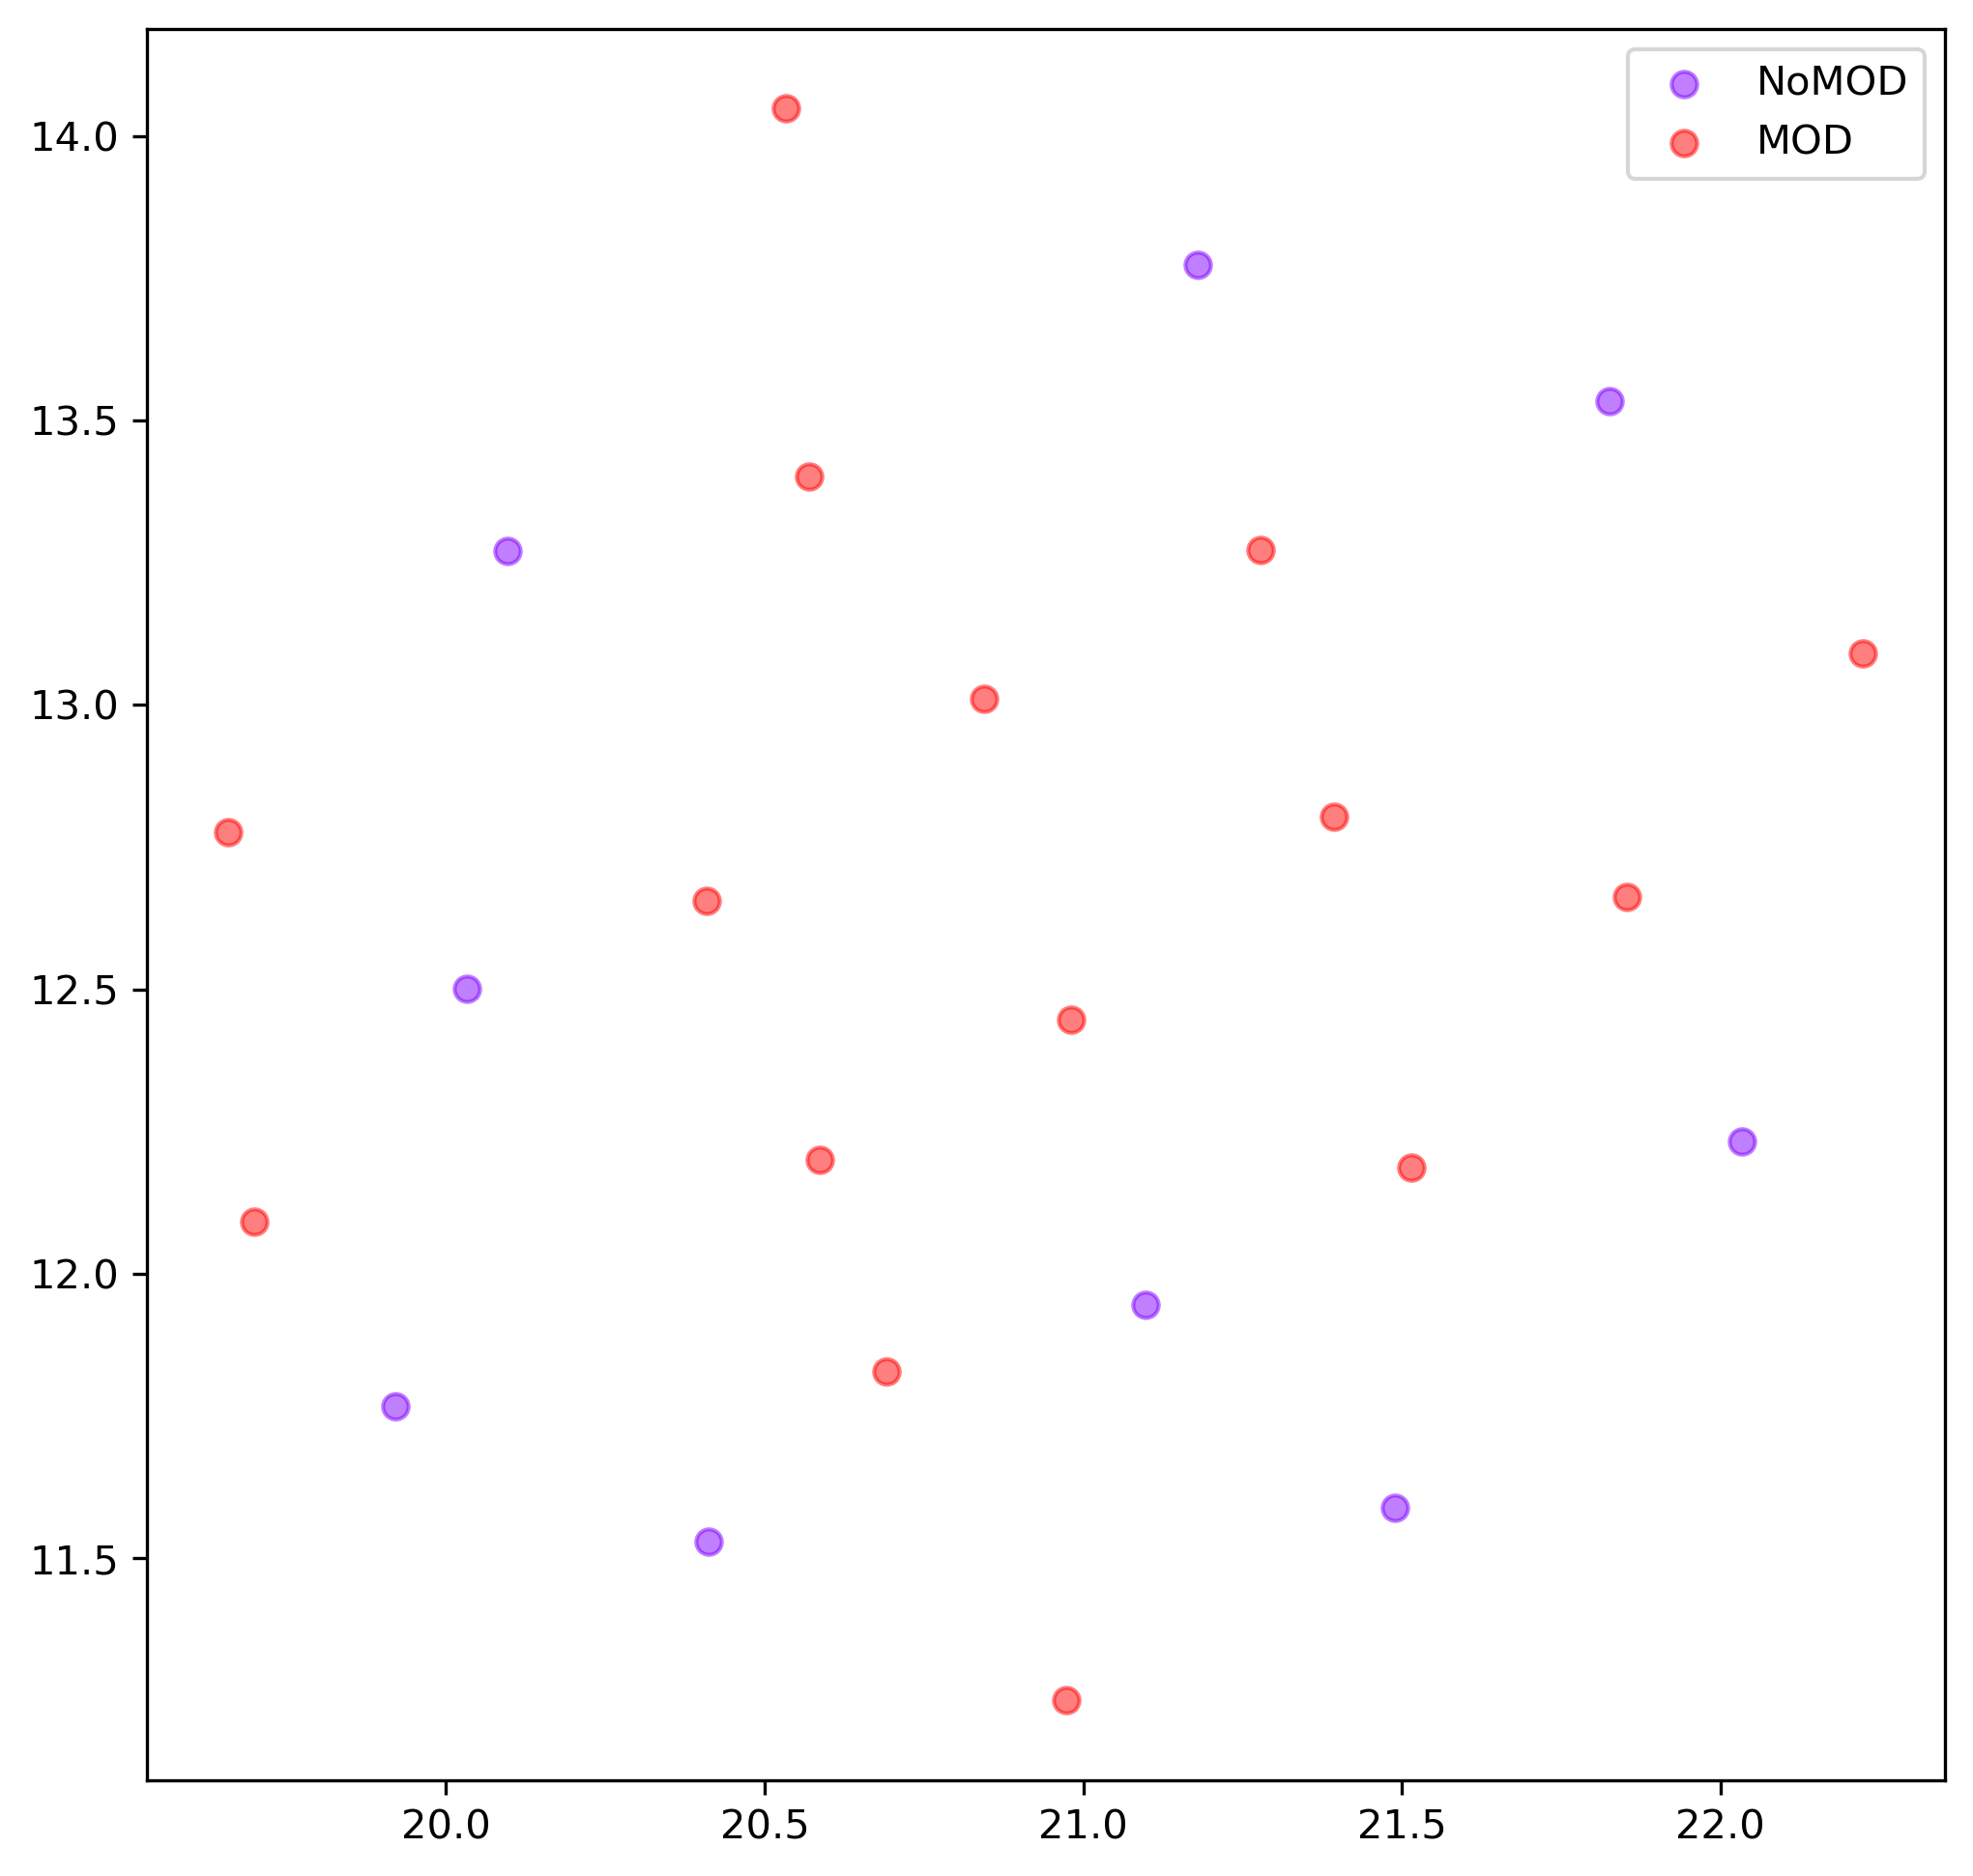

In [99]:
umap_plot_label(X[select_feats],y,2,7,['NoMOD','MOD']);

In [95]:
# many of the MODs are missed sepsis
sepsis_subset = clean_df3[(clean_df3.TEMPERATURE > 100.0) & (clean_df3.PULSE > 90)]
sepsis_subset.label.value_counts()

MOD      15
NoMOD     9
Name: label, dtype: int64

In [96]:
# what difference in any of the MOD and NoMOD that meet sepsis criteria
# sodium_min, sodium_max, chloride_min, SBP, DBP
for field in clean_df3.columns[2:]:
    tstat,pval = scipy.stats.ttest_ind(sepsis_subset[sepsis_subset.label=='MOD'][field].dropna(),
                                      sepsis_subset[sepsis_subset.label=='NoMOD'][field].dropna())
    print(field,pval)

age 0.15052501562648005
ed_duration 0.9173747074451035
ed_inp_delta 0.4289800249696798
visits 0.27205020524228574
new_race_ALASKA/PACIFIC 0.4508565460531444
new_race_ASIAN nan
new_race_BLACK OR AFRICAN AMERICAN 0.9022097979098213
new_race_UNKNOWN nan
new_race_WHITE 0.8176418809331217
Gender 0.5910674151011331
Ethnicity 0.38566621849038185
sodium_min 0.0007067018042203041
sodium_max 0.0004486816890058131
potassium_min 0.10857755793562479
potassium_max 0.06248849106519262
chloride_min 0.04960083571318704
chloride_max 0.11740859196450518
creat_min 0.15151481042659487
creat_max 0.15151481042659487
lactate_count 0.7712854423751431
troponin_count 0.24173819583066342
amylase_count 0.5817965644058296
urine_count 0.817641880933122
PULSE 0.5272121546413042
TEMPERATURE 0.20857459915464155
SBP 0.020188996168339118
DBP 0.0027197560623062472
RESPIRATION 0.10393821760286052


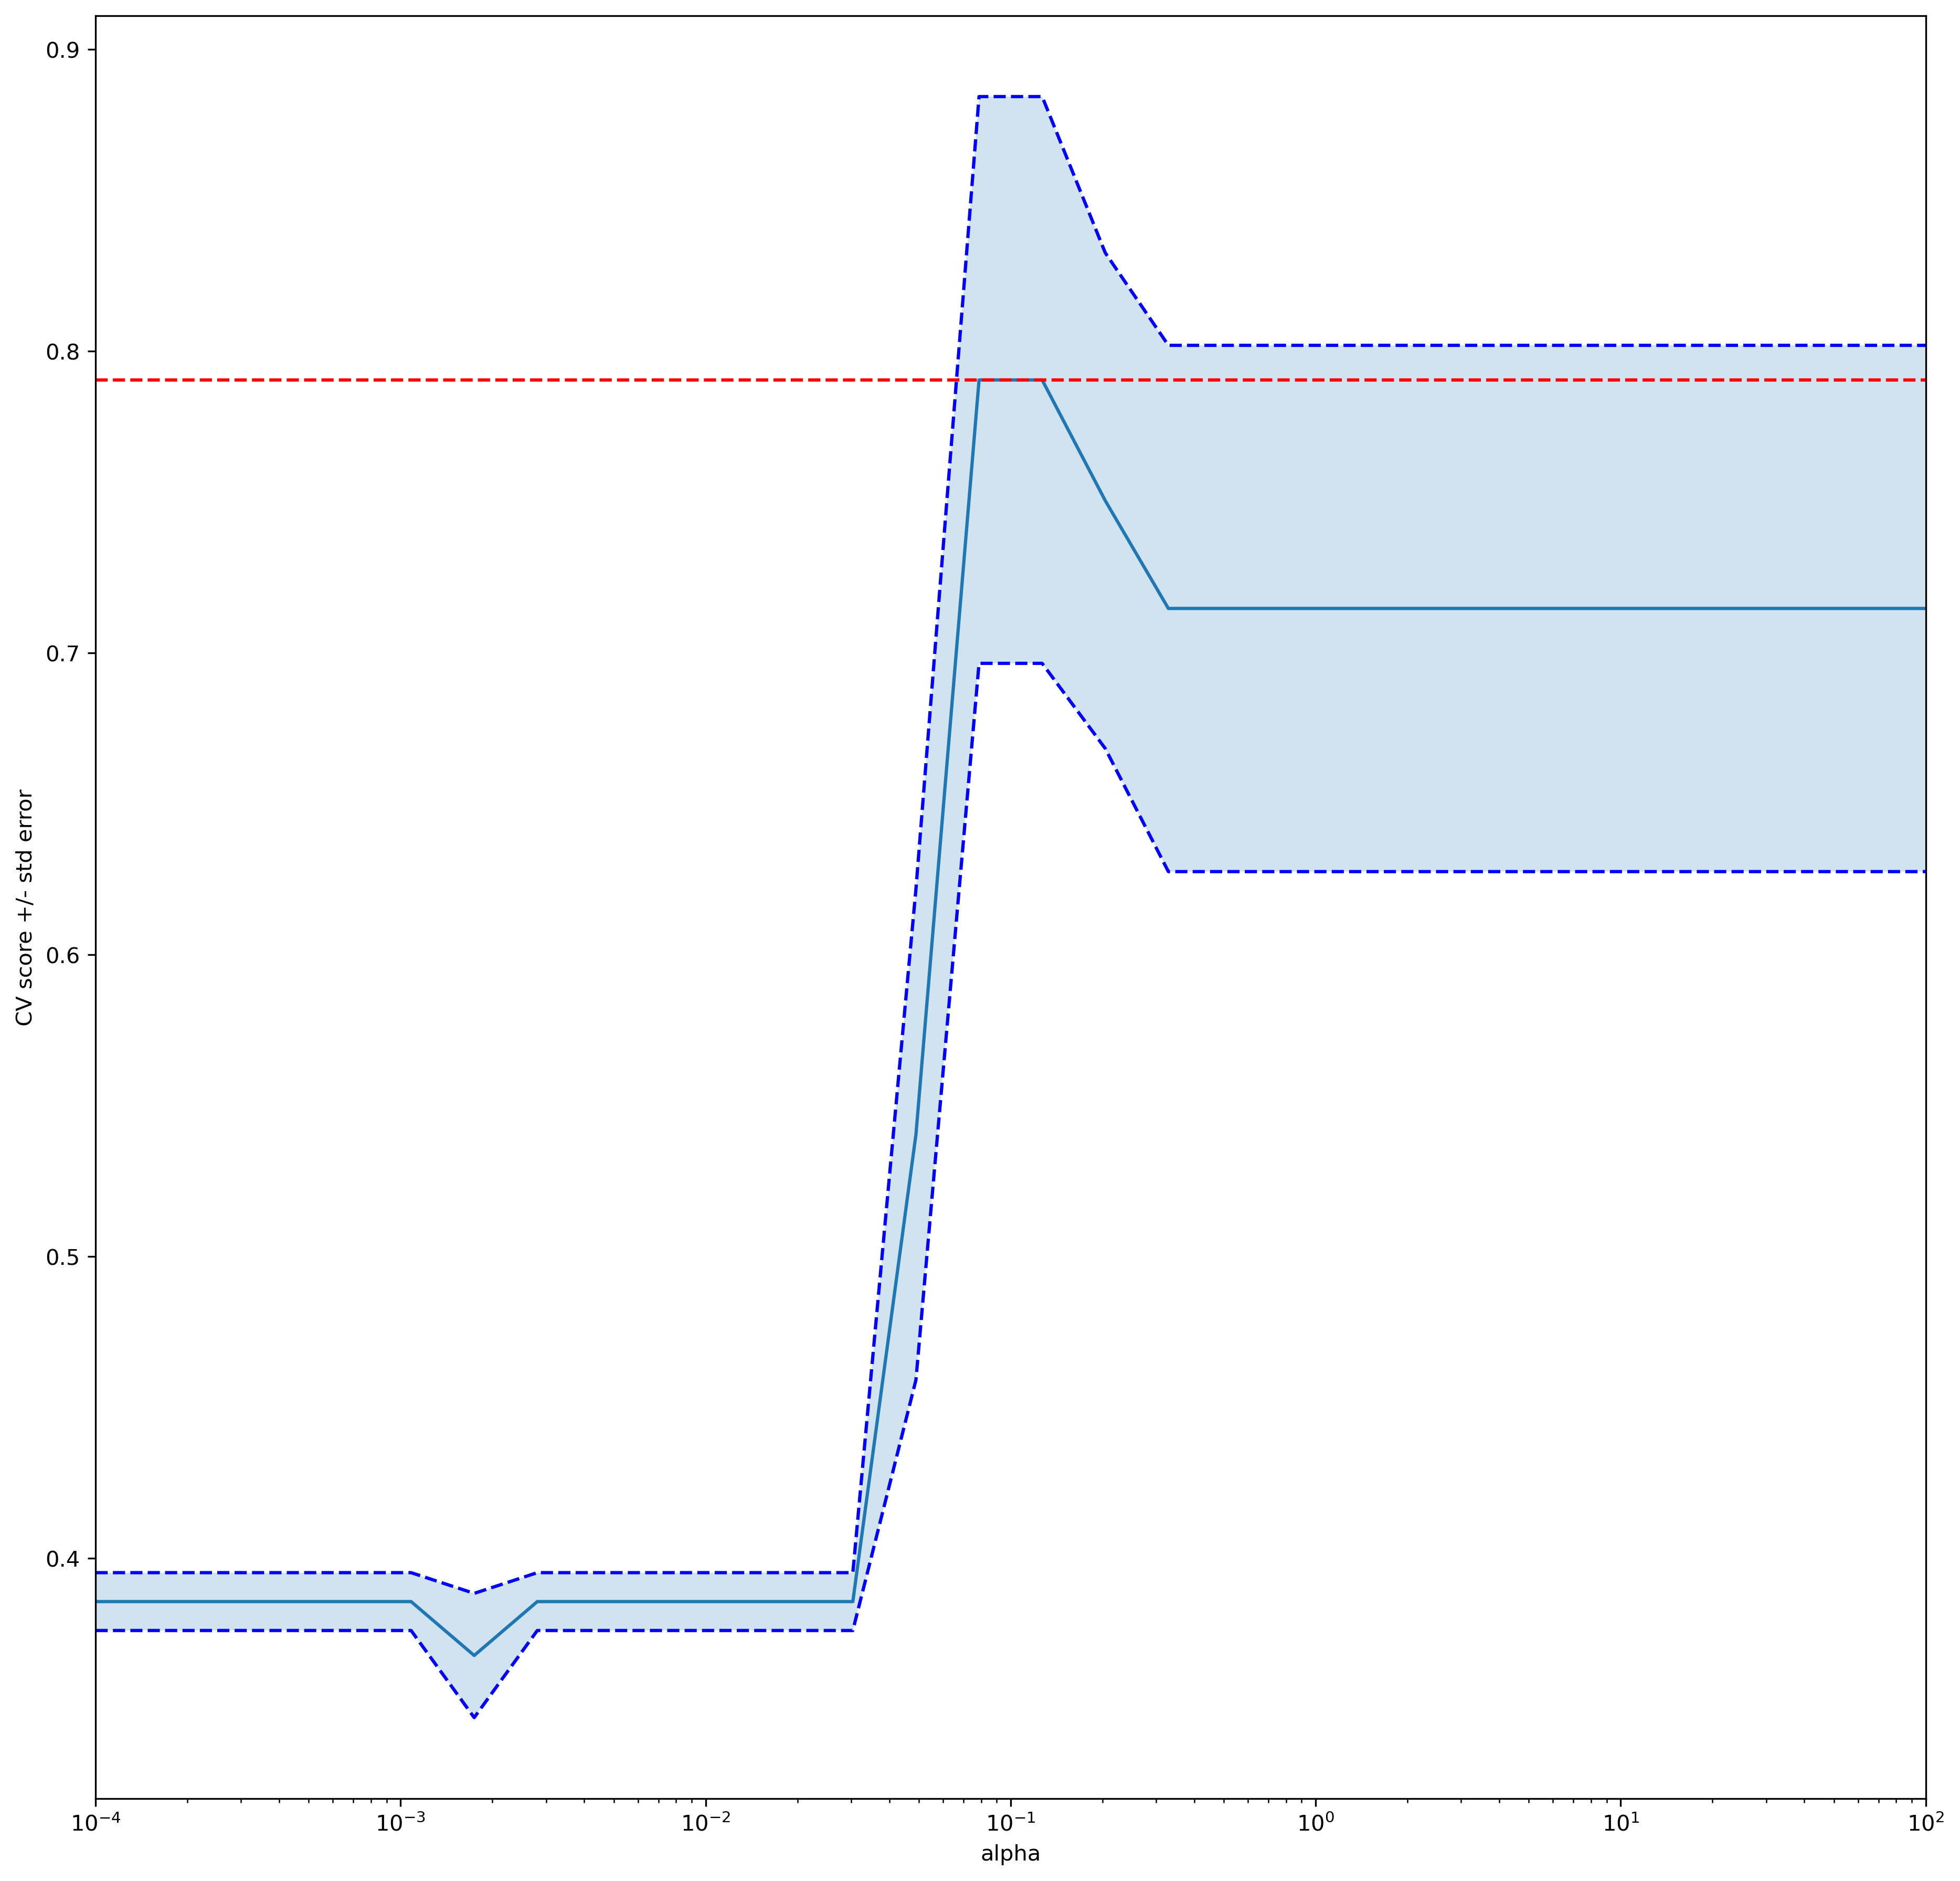

In [97]:
good_fields = ['sodium_min','sodium_max','chloride_min','SBP','DBP']

X = sepsis_subset[good_fields]
y = np.array([1 if x=='MOD' else 0 for x in sepsis_subset['label']])

clf = tune_model(X,y)

(24, 5) (24,)
AUC =  0.7666666666666666 0.2
F1 =  0.7904761904761904 0.20995626366712955
Accuracy =  0.8699999999999999 0.10770329614269006
Confusion matrix:
[[ 6  3]
 [ 0 15]]
2  features chosen by L1 model.


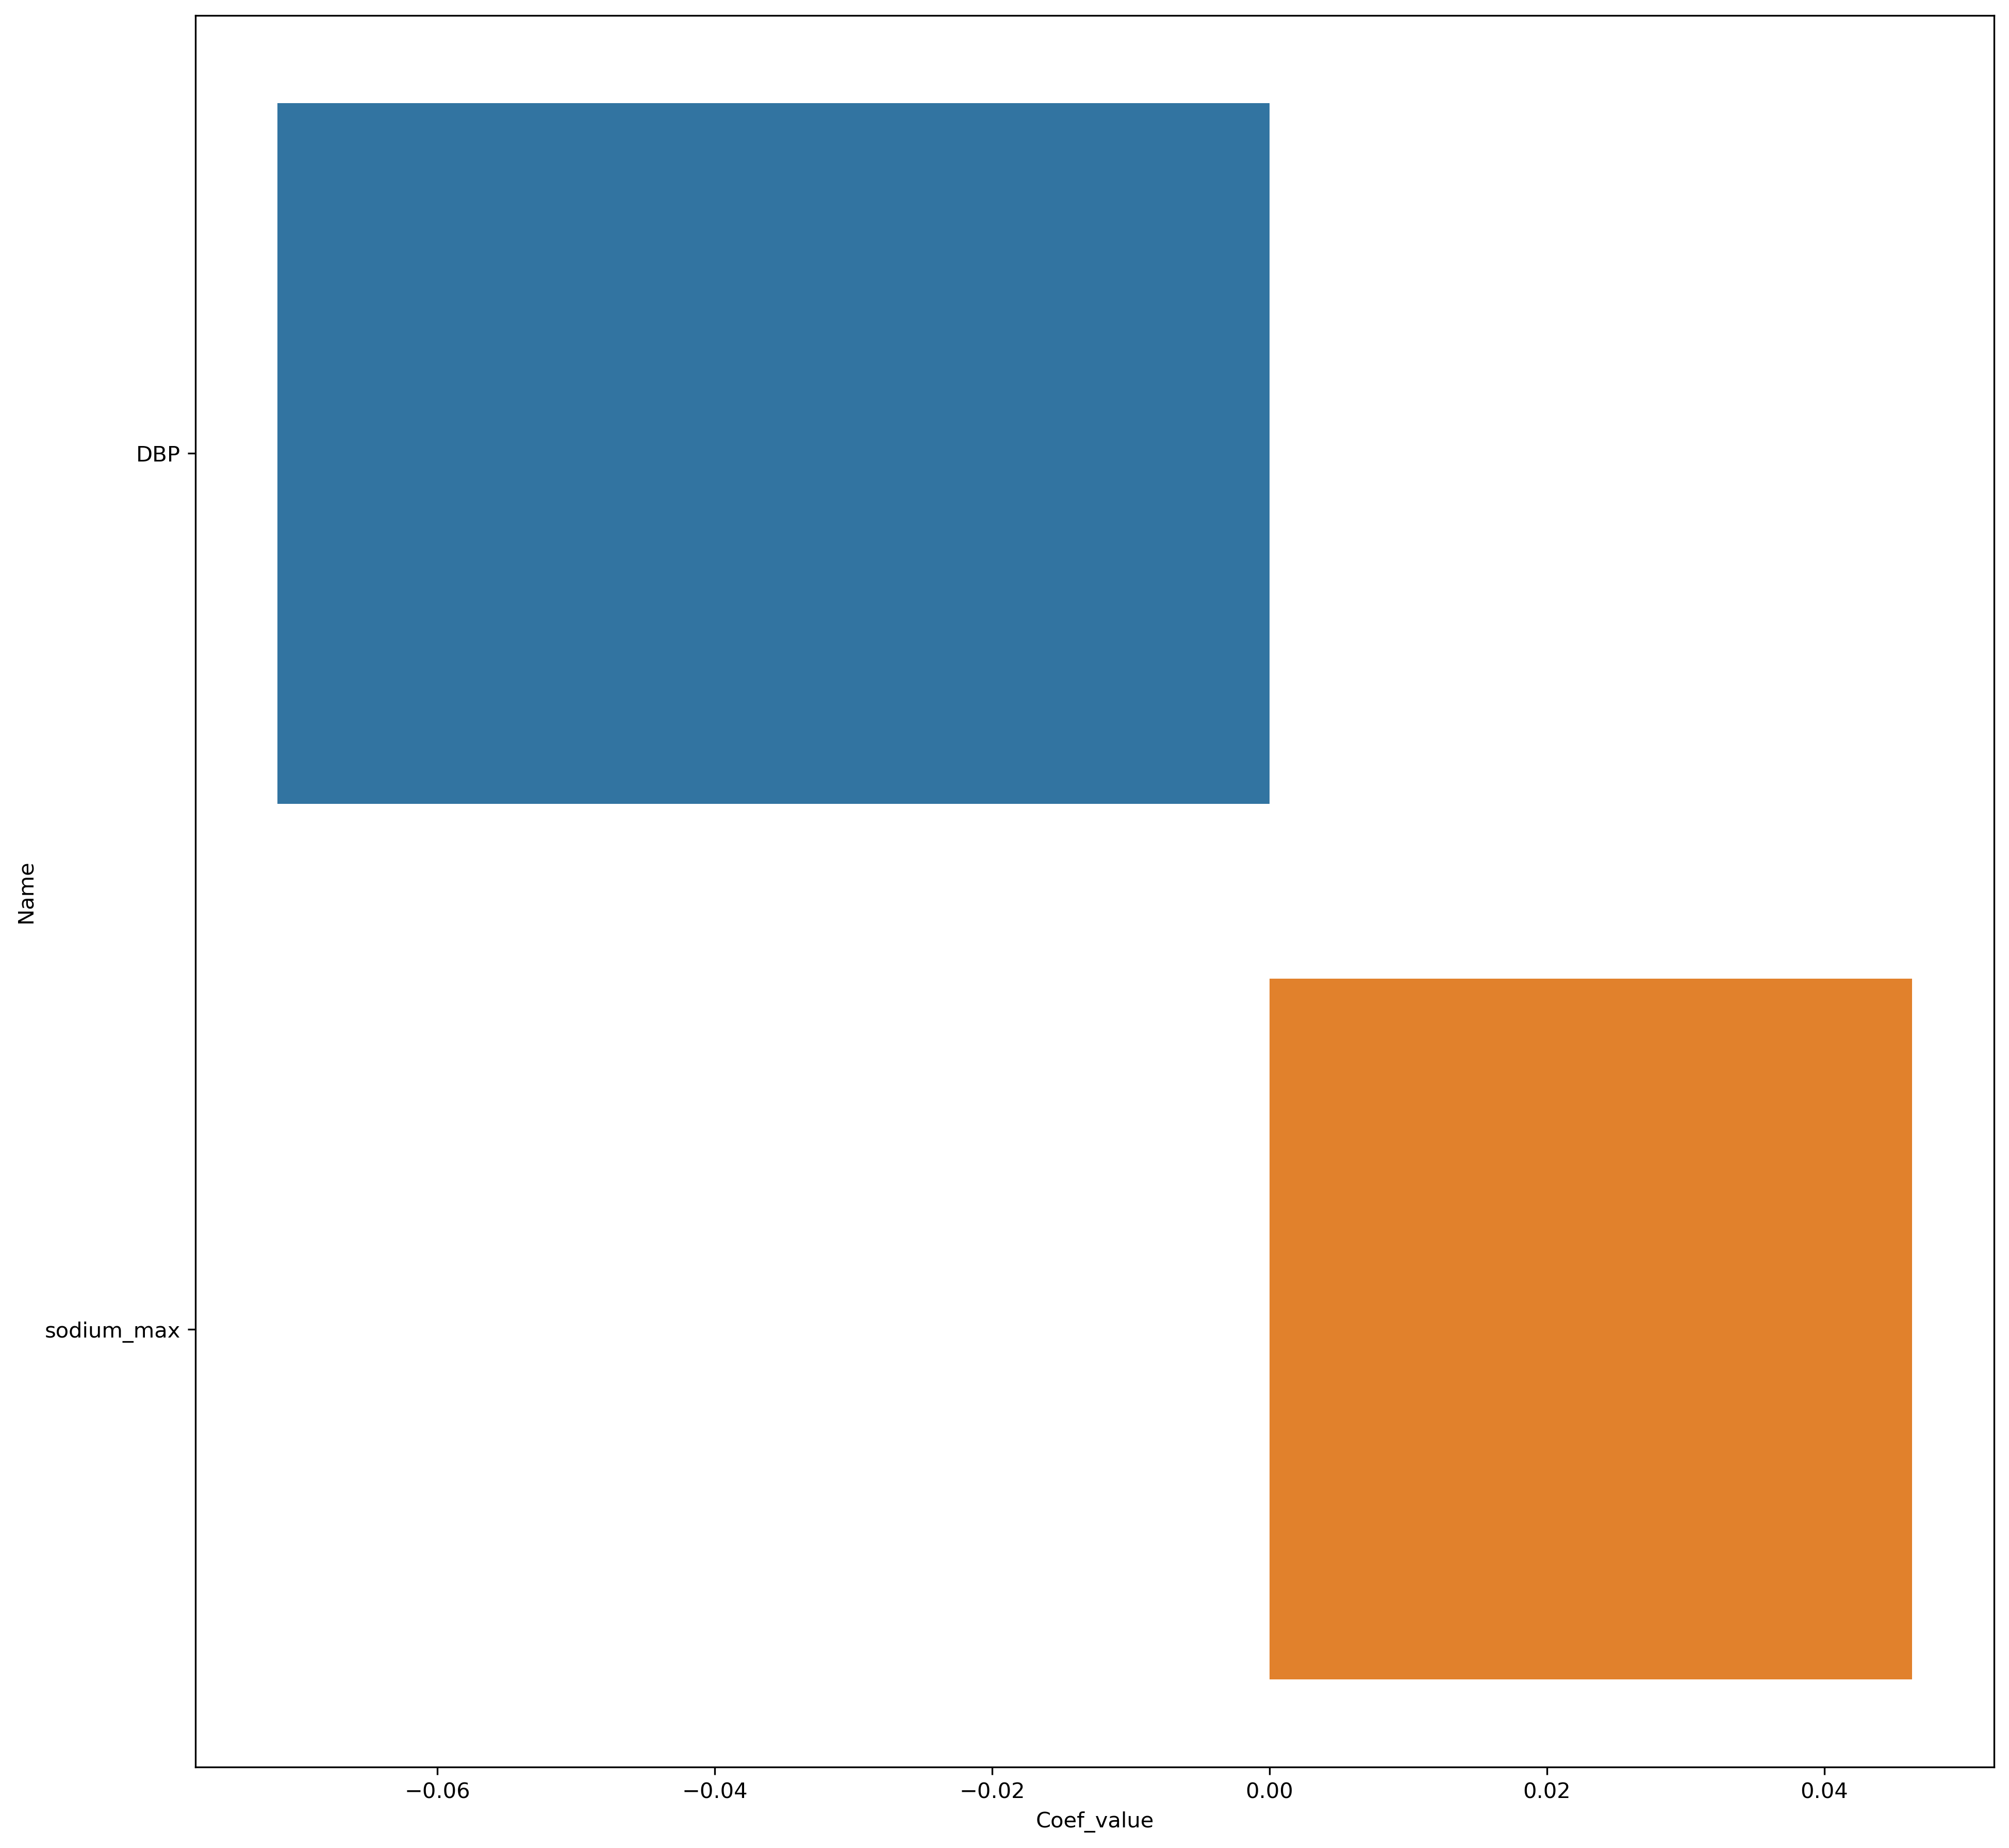

In [98]:
clf,select_feats = build_L1_model(X,y,clf.best_params_['C'])
visualize_model(clf,select_feats)

In [1]:
# how to get prior history? From ICD table

abpain_icd1.shape


NameError: name 'abpain_icd1' is not defined

# Do a quick analysis of the case summary notes

In [ ]:
for PtSSN in abpain_labels_df[abpain_labels_df.label=='MOD'].PtSSN:
    print(PtSSN)
    display(abpain_df[abpain_df.PtSSN==PtSSN].CaseSummaryER)